# Retinal OCT Fluid Segmentation

# 1. Introdction

We will present what retinal OCT fluids are, describe the segmentation task for retinal OCT fluids, and propose various solutions based on deep learning. 

From purchasing products at a store, reading a book, visiting family, writing a notebook summary at a DS workshop, and playing basketball - vision accompanies us, humans, in many aspects of our lives.
Damage to vision, even the least significant one, can have many effects on the patient's life and disrupt their daily routine.
One of the most important components in the process of vision is the retina - the part of the eye that translates light that enters the eye, into images that we eventually see. Due to the retina's importance in the process of vision, diseases that affect the retina can lead to severe vision damage.
There are several diseases that affect the retina, which is caused by the accumulation of fluids in the retina. In some of these diseases, the main risk factor is age (such as age-related macular degeneration, AMD, which is the leading cause of blindness in the developed world), and in others, there are different risk factors (such as diabetes, which can cause diabetic macular edema, DME).


The identification of retinal diseases is mostly carried out by analyzing retinal scans - OCT (Optical Coherence Tomography) scans. OCT is a technique to create detailed cross-sectional images of the retina, which allows a deep analysis of the retina.
In order to identify the disease, specify it, and determine its current status - identification and quantification of the retinal liquids are done by a professional by analyzing the image. However, manual analysis is slow, prone to errors, and does not allow accurate analysis and quantification of retinal liquids.

Due to the difficulty in manually analyzing retinal liquids, algorithms for analyzing retinal scans have been developed to automate the process. These algorithms perform segmentation - identifying liquid pixels in the scan, and also by the type of liquid when few liquid types exist. With the development of the field of deep learning, a significant improvement has been made in the performance of these algorithms, and currently, the leading methods for segmenting retinal liquids are deep learning methods. 

The rest of the notebook is organized as follows: At the second chapter, we will discuss the motivation for the problem and how we arrived at addressing it. Next, in Chapter 3, we will examine the data and the specific task we try to solve, and the evaluation method. In Chapter 4, we will present our various solutions to the task. Chapter 5 will cover the conclusion and future thoughts and directions.

# 2. Problem Motivation

There are several reasons why I find this project particularly exciting and motivating. First and foremost, this project has the potential to make a real difference in the lives of patients suffering from retinal diseases. Accurate and efficient segmentation of OCT images can help clinicians diagnose and monitor these conditions more effectively, leading to better treatment outcomes and improved quality of life for patients.

Secondly, this project offers a fascinating opportunity to explore the cutting-edge field of medical imaging and its applications in clinical practice. By developing and implementing advanced algorithms and techniques for OCT image analysis, we can gain deeper insights into the underlying mechanisms of retinal diseases and contribute to the development of new diagnostic and therapeutic tools.

# 3. Data and evaluation method

The dataset we use is made up of OCT scans of patients with DME (Diabetic Macular Edema, a common eye disease among diabetic patients). The dataset, which is made up of 1000 OCT scans of patients, is manually labeled by professionals so that each pixel is marked as containing fluid CME or not containing fluid CME. CME fluids or Cystoid macular edema affects the central retina (macula). Multiple cyst-like (cystoid) areas of fluid appear in the macula and cause retinal swelling or edema. DME, which causes excess fluids in the macula, eventually causes blurred or decreased central vision, which can affect significantly the patient's life. The dataset has been arranged and categorized under the supervision of the medical experts at Liaquat University of Medical and Health Sciences (LUMHS) Jamshoro, Pakistan, that are trained to identify CME and its progression and provide a confirmatory diagnosis of CME. 
The data collection and tagging were a part of [1] article, and the dataset is described and accessible via Kaggle.

The task we are facing is fluid segmentation - given an image (OCT scan), predict for each pixel, if it contains fluid - or not. 

The most common evaluation metric in the medical image segmentation world, and in the fluid segmentation in OCT scans as well, is the dice coefficient (/loss). It is used to evaluate the similarity between a predicted segmentation and the ground truth segmentation - the manual fluid segmentation done by professionals. Therefore, we will evaluate all of our models with dice loss.
The Dice coefficient is calculated as the ratio of the intersection of the predicted and ground truth segmentation to the union of the two. The Dice loss is the complement of the Dice coefficient, so it ranges from 0 to 1, with 0 indicating a perfect overlap between the predicted and ground truth segmentations, and 1 indicating no overlap. 

# 4. Problem solutions 

With the current strength of deep learning models in the images field and the fact that in the last year, all of the SOTA solutions in the fluid segmentation field were based on deep learning - we chose to focus on building deep learning models to face the task. This notebook will describe several efforts that were made, in order the achieve the best results. We will also present one classic algorithm.

In [1]:
!pip install segmentation_models_pytorch -q
!pip install torchinfo

In [2]:
%config Completer.use_jedi = False

In [3]:
import os
import numpy as np
from tqdm import tqdm       
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize
import pandas as pd
import random
import cv2
import pickle
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torchinfo import summary
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics
import segmentation_models_pytorch.utils.losses
from dataclasses import dataclass
import gc

## 4.0. Data Loading

In [4]:
# NOTEBOOK CONFIG FOR CONVENIENCE
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

NEW_IMG_SIZE = 64

EPOCHS = 40

We will load pickle files that contain the images and the fluid mask.  
Notice that we resize the images from the original size of 320x320 to 64x64. This is due to hardware limits - the Kaggle & Google Colab GPU notebooks were not able to process large images successfully, with CNNs. 64x64 was the largest image size we were able to run our networks on.

In [5]:
X_train_path = "/kaggle/input/intraretinal-cystoid-fluid/X_train_1006.pickle"
pickle_in = open(X_train_path,"rb")
x_data = pickle.load(pickle_in)
x_data = resize(x_data, (x_data.shape[0], NEW_IMG_SIZE, NEW_IMG_SIZE, IMG_CHANNELS))
print("X_data shape {}".format(x_data.shape))

Y_train_path = "/kaggle/input/intraretinal-cystoid-fluid/Y_train_1006.pickle"
pickle_in = open(Y_train_path,"rb")
y_data = pickle.load(pickle_in)
y_data = resize(y_data, (y_data.shape[0], NEW_IMG_SIZE, NEW_IMG_SIZE, 1))
print("Y_data shape {}".format(y_data.shape))

X_data shape (1006, 64, 64, 3)
Y_data shape (1006, 64, 64, 1)


## 4.1. EDA

We will first create some functions to help us visualize the data.

In [6]:
def display_random_sample(X_data, Y_data):
    assert X_data.shape[0] == Y_data.shape[0], "Train and test number of elements is not equal."
    
    num_images = X_data.shape[0]
    random_image_index = np.random.randint(0, num_images)

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.imshow(X_data[random_image_index])
    ax1.set_title('Original image')
    
    ax2.imshow(Y_data[random_image_index])
    ax2.set_title('Mask')

    plt.show()

In [7]:
def display_predictions(image1, image2, image3, description1='', description2='', description3='', size=(8,3)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=size)

    ax1.imshow(image1)
    ax1.set_title(description1)

    ax2.imshow(image2)
    ax2.set_title(description2)

    ax3.imshow(image3)
    ax3.set_title(description3)

    plt.show()

In [8]:
def display_image(image, description=''):
    plt.imshow(image)
    plt.axis('off')
    
    plt.title(description)
    
    plt.show()

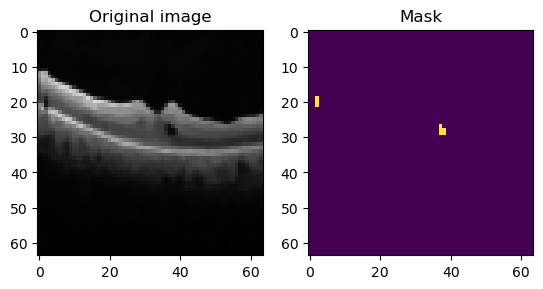

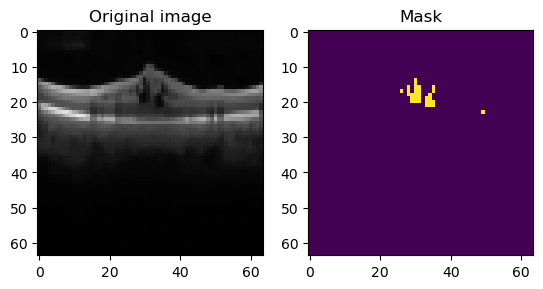

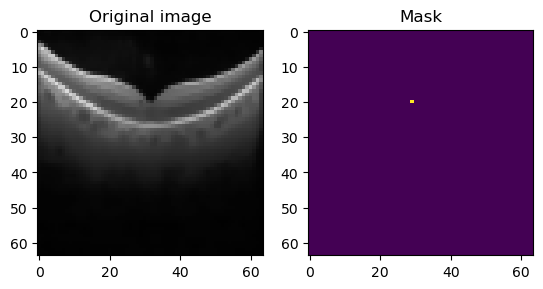

In [9]:
display_random_sample(x_data, y_data)
display_random_sample(x_data, y_data)
display_random_sample(x_data, y_data)

We can observe that the GT fluid mask contains a relatively small amount of fluid. In addition, we can see that the fluids look like "holes" (actually, cystoids) in the retina.

In [10]:
def heat_map(images, title=''):
    aggregated_image = np.mean(images, axis=0)

    plt.imshow(aggregated_image[:,:,0], cmap='hot')
    plt.title(title)
    plt.colorbar()

    plt.show()

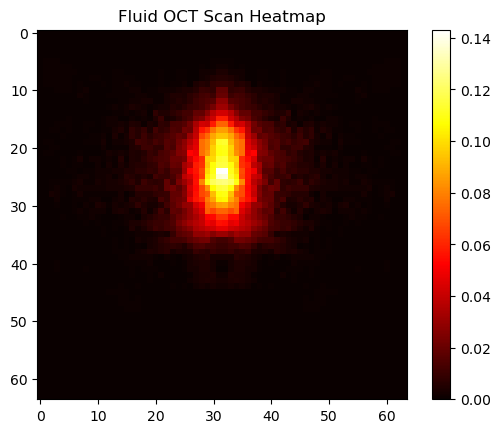

In [11]:
heat_map(y_data, "Fluid OCT Scan Heatmap")

The majority of the fluids are in the center of the retina - the macula. They are spread equally horizontally.

In [12]:
def display_histogram(image_array, title=''):
    all_true_values = []
    for i in range(image_array.shape[0]):
        true_values = image_array[i][image_array[i] == True].ravel()
        all_true_values.append(len(true_values))
    sns.histplot(all_true_values, kde=True, bins=range(np.max(all_true_values)+2))
    plt.xlabel("Number of true values")
    plt.ylabel("Number of images")
    plt.title(title)
    plt.show()

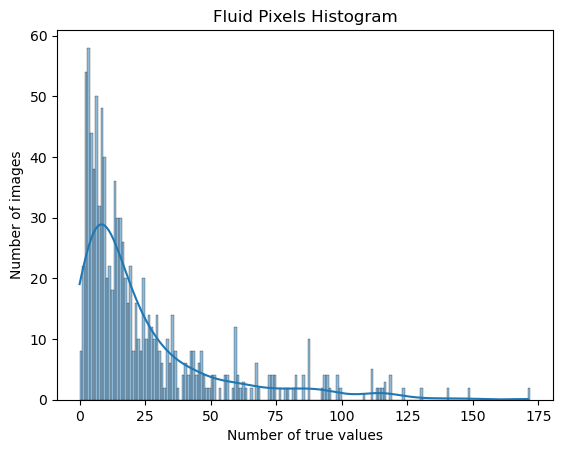

In [13]:
display_histogram(y_data, title='Fluid Pixels Histogram')

In most of the OCT scans, there isn't much fluid presence - between 1-25 pixels only.
Although there are some anomalies - we can see that there are scans that have no fluid at all, and scan with more than 120 fluid pixels. Let's visualize some "normal" data, and some anomalies, to understand the data better.

In [14]:
def display_image_mask(x_data, y_data, num_fluid, num_images_to_display, image_title, mask_title):
    indices = np.where(np.count_nonzero(y_data, axis=(1,2)) == num_fluid)

    selected_indices = np.random.choice(indices[0], num_images_to_display, replace=False)

    fig, axes = plt.subplots(num_images_to_display, 2, figsize=(num_images_to_display*2+10, num_images_to_display*2+10))
    for i in range(num_images_to_display):
        axes[i, 0].imshow(x_data[selected_indices[i]])
        axes[i, 1].imshow(y_data[selected_indices[i]].squeeze())

    axes[0, 0].set_title(image_title)
    axes[0, 1].set_title(mask_title)
    plt.show()

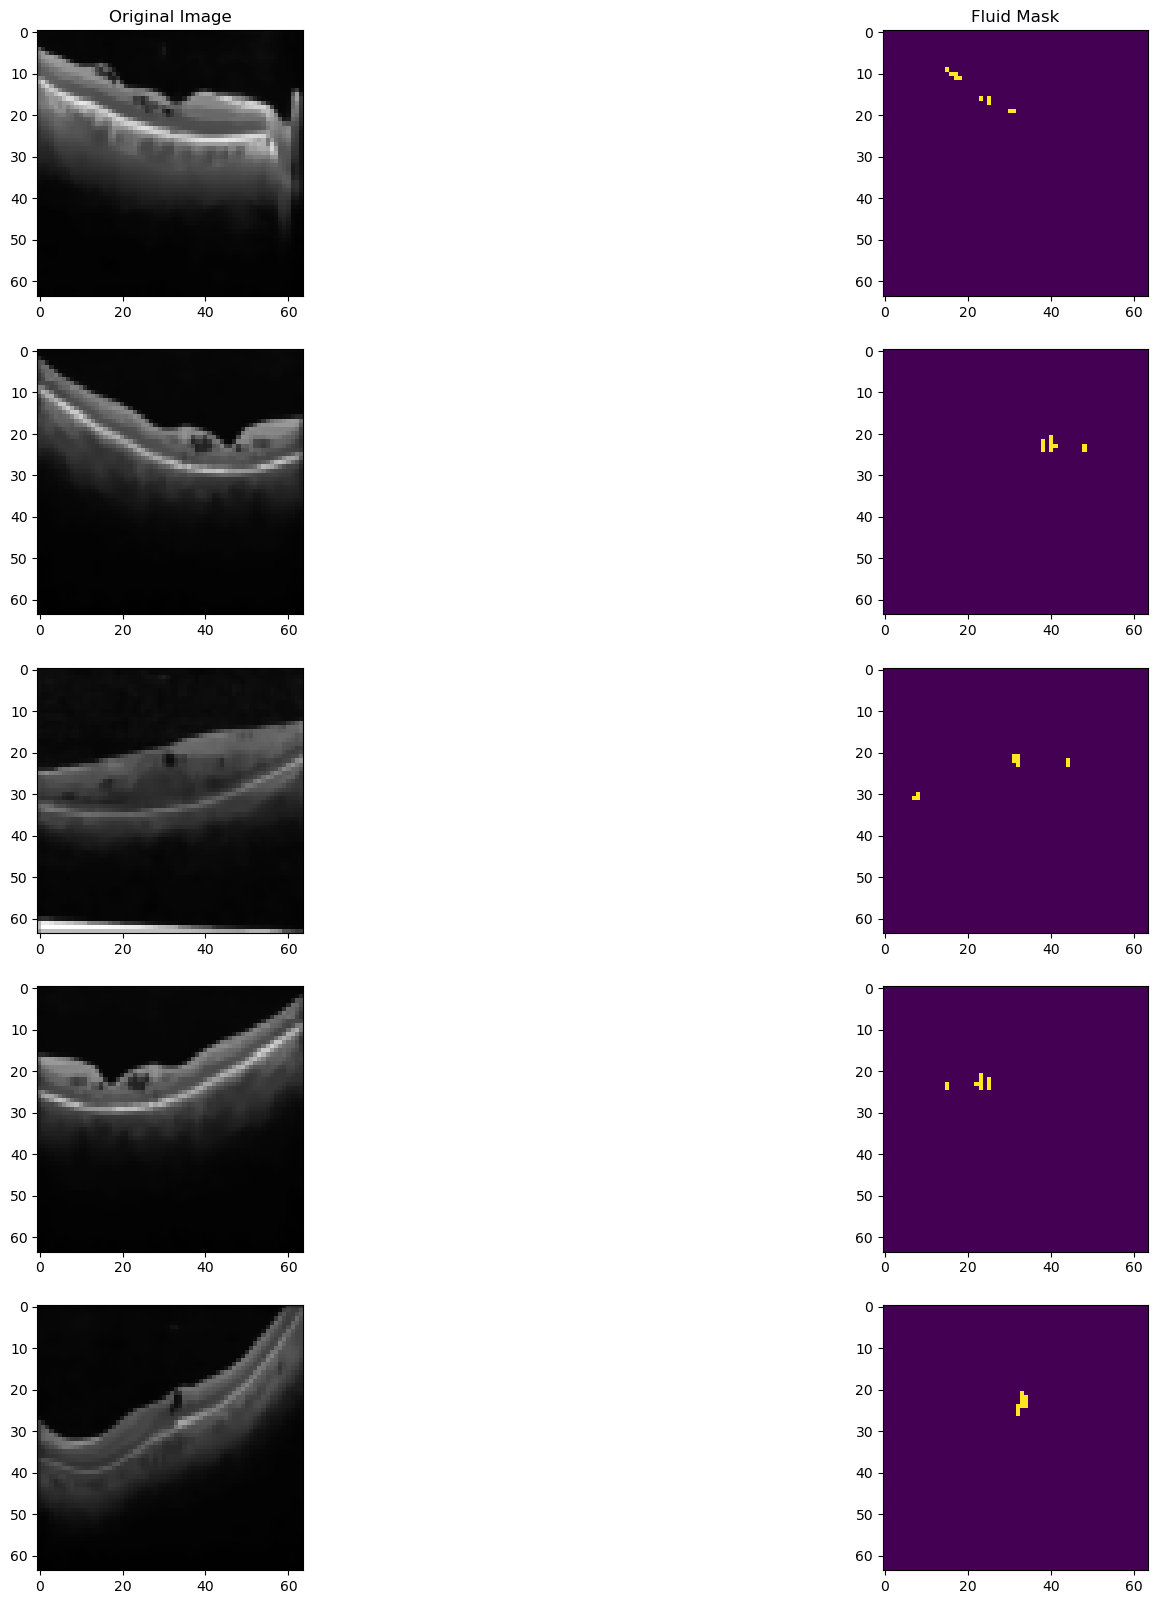

In [15]:
display_image_mask(x_data, y_data, num_fluid=10, num_images_to_display=5, image_title="Original Image", mask_title="Fluid Mask")

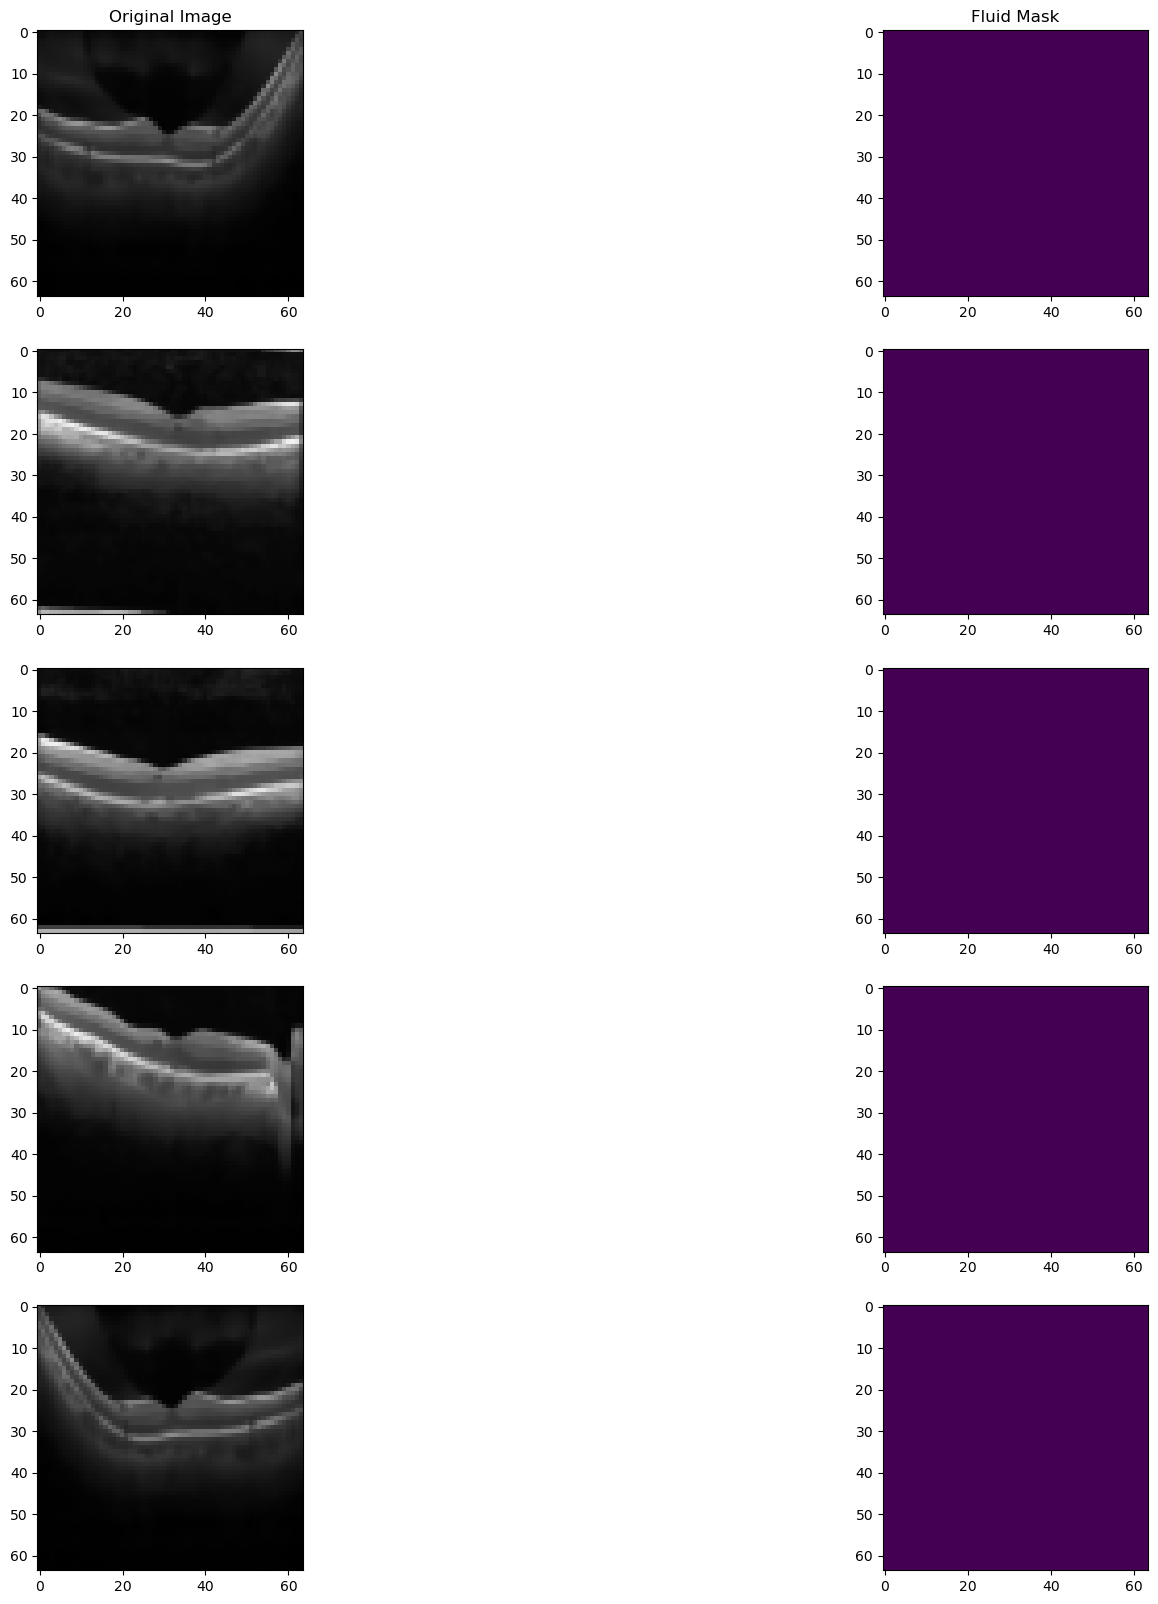

In [16]:
display_image_mask(x_data, y_data, num_fluid=0, num_images_to_display=5, image_title="Original Image", mask_title="Fluid Mask")

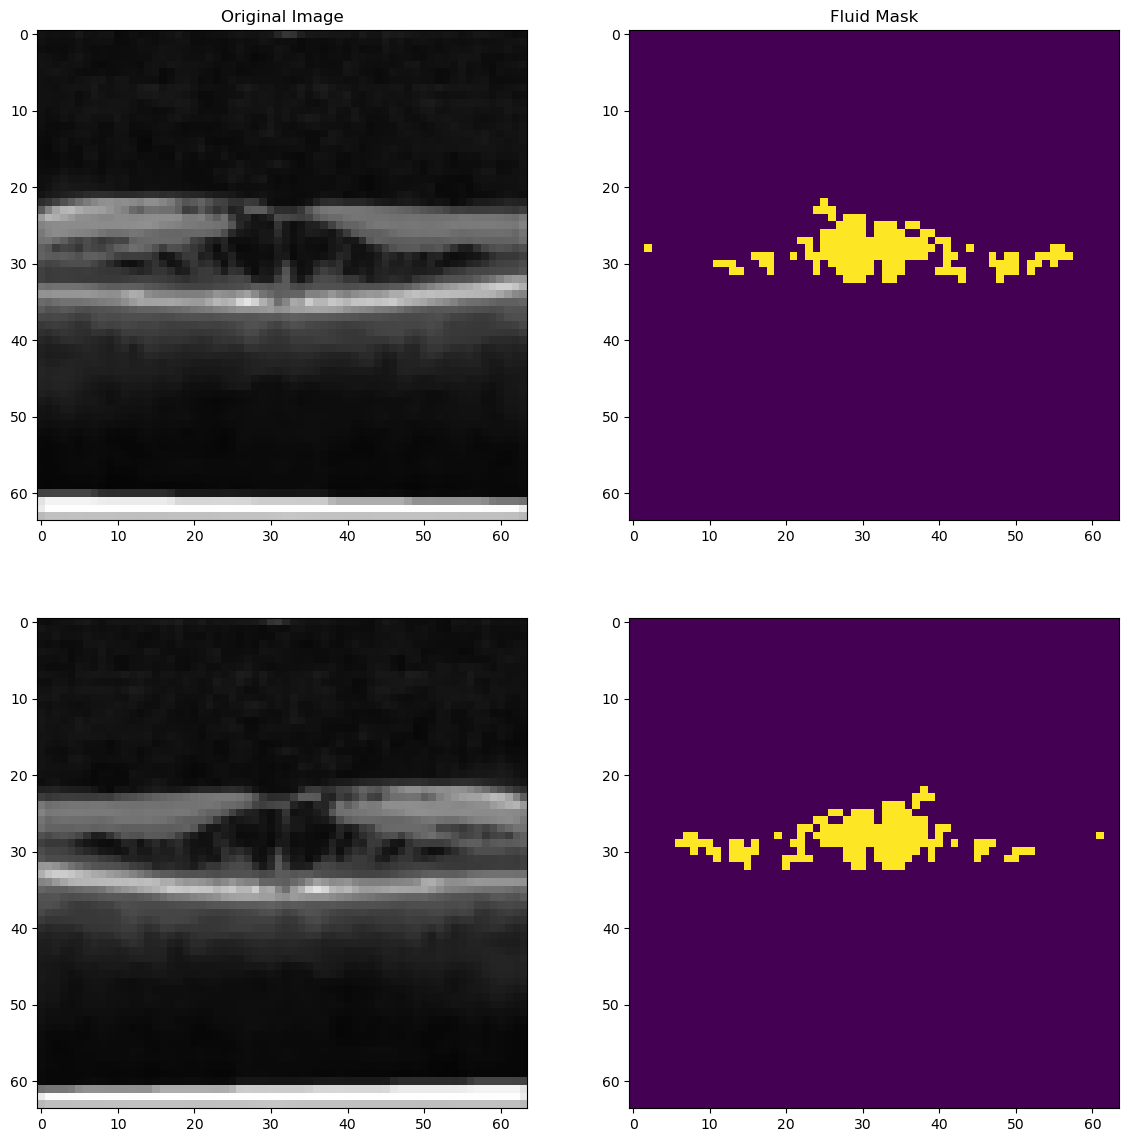

In [17]:
display_image_mask(x_data, y_data, num_fluid=148, num_images_to_display=2, image_title="Original Image", mask_title="Fluid Mask")

We observe that the pattern is consistent - in the images with excessive fluid presence, there are large cystoids in the retina. OCT scan that does not contain fluids, does not have cystoids in them. On top of that, the anomalies do not have any kind of special behavior - the scans were performed the same way, and the data is proper.

In [18]:
def plot_piechart(images_data, title):
    n_images = images_data.shape[0]
    n_true_images = np.count_nonzero(np.any(images_data, axis=(1, 2)))
    n_false_images = n_images - n_true_images
    labels = ['No fluid', 'Fluid exists']
    values = [n_false_images, n_true_images]
    plt.figure(figsize=(7, 7))
    plt.pie(values, labels=labels, autopct='%1.1f%%', colors = ['#4F6272', '#B7C3F3'])
    plt.title(title)
    plt.show()

Let's visualize precisely how many scans with no fluid exists in our dataset. Many images with no fluid will change how we handle the task.

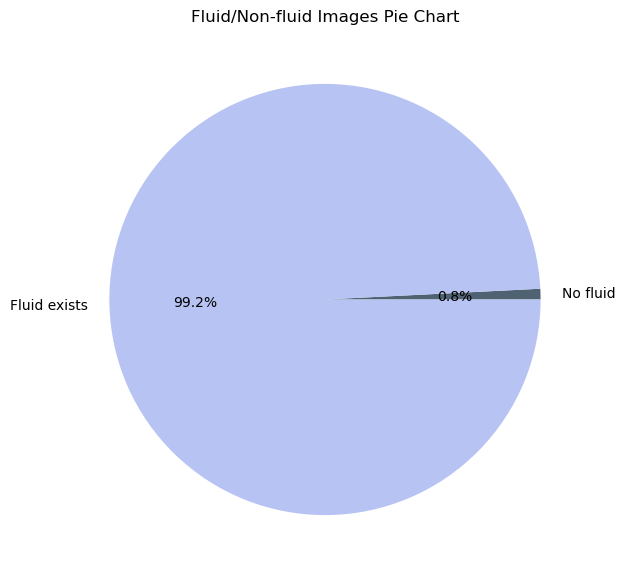

In [19]:
plot_piechart(y_data, "Fluid/Non-fluid Images Pie Chart")

We can see that the number of scans with no fluid is relatively small, and not very significant.

Now let's explore our images using some classic feature descriptor techniques. We will try extract some features using these descriptors, reduce their dimensions, and cluster our images based on these descriptor.

Let's implement the histogram of oriented gradients. HOG is a feature descriptor technique used in computer vision and image processing for object detection and recognition. HOG works by analyzing the gradient orientations in an image. HOG divides the image into small, overlapping cells, and for each cell, it computes the gradient orientation histogram, which counts the number of pixels that fall into each orientation bin. The histogram of each cell is then normalized, and the histograms from neighboring cells are combined to form a feature vector that represents the entire image.

In [20]:
winSize = (32,32)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

winStride = (8,8)
padding = (8,8)
locations = ((10,20),)

In [21]:
img_hog = []
for img in x_data[:]:
    grey = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    hist = hog.compute(grey,winStride,padding,locations)
    img_hog.append(hist)

img_hog = np.array(img_hog)

Plotting the HOG features just to see what we're working with

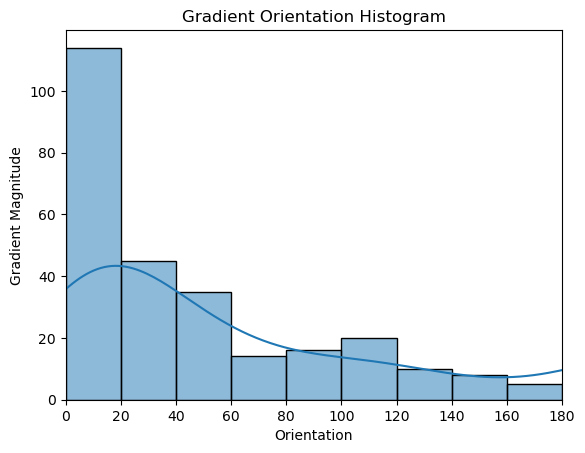

In [22]:
sns.histplot(img_hog[0]*(32), kde=True, bins=range(10))
x_ticks = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]
plt.xlabel("Orientation")
plt.ylabel("Gradient Magnitude")
plt.title("Gradient Orientation Histogram")
plt.xlim(0,9)
plt.xticks(range(len(x_ticks)), x_ticks)
plt.show()

We can see that the largest gradient magnitudes fall between 0-20 angles

Here we're implementing the Scale-Invariant Feature Transform aka SIFT. SIFT works by identifying and describing distinctive features in an image, known as "keypoints" or "interest points". These keypoints are selected based on their uniqueness, stability, and repeatability across different images, viewpoints, and scales.

In [23]:
sift = cv2.SIFT_create()

img_sift = []
for img in x_data[:]:
    grey = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    kp, des = sift.detectAndCompute(grey,None)
    m = np.mean(des, axis=0)
    s = np.std(des, axis=0)
    d = m/(s+0.0001)
    img_sift.append(d)
    
img_sift = np.array(img_sift)


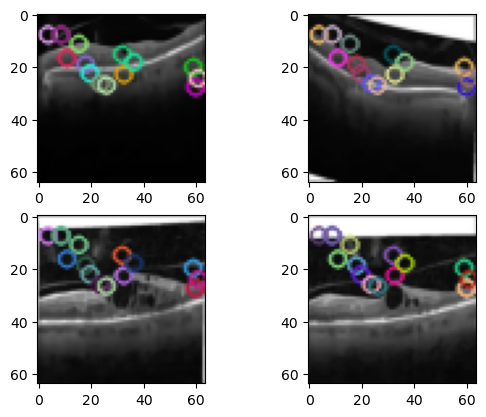

In [24]:
fig, axs = plt.subplots(2, 2)
for i in range(4):
    grey = cv2.cvtColor((x_data[i]*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    img_1 = cv2.drawKeypoints(grey,kp,x_data[i])
    axs[i // 2, i % 2].imshow(img_1)
plt.show()

We can see the diffrent keypoints our SIFT descriptor is finding. 

Here we are implementing brightness feature extraction

In [25]:
img_color = []
for img in x_data[:]:
    grey = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    hist = cv2.calcHist([grey], [0], None, [256], [0, 256])
    img_color.append(hist)
img_color = np.array(img_color).squeeze()

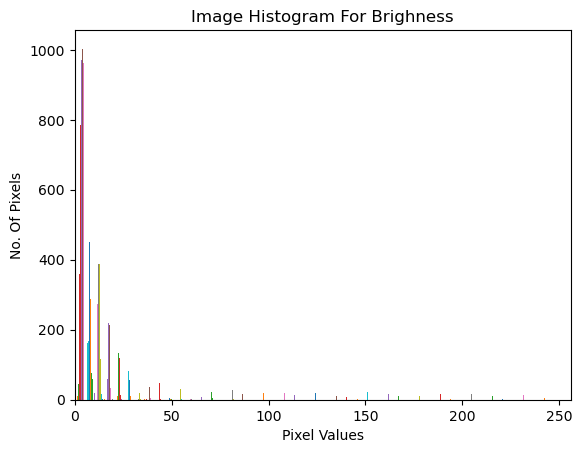

In [26]:
plt.hist(img_color, bins=256)
plt.xlim(0,256)
plt.xlabel("Pixel Values")
plt.ylabel("No. Of Pixels")
plt.title('Image Histogram For Brighness')
plt.show()

We can see that most of the images is around 0 i.e on the darker side.

Here we're concatenating all our features

In [27]:
con_data = np.concatenate([img_hog, img_sift, img_color], axis=1, out=None, dtype=None, casting="same_kind")

In [28]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

Here we are implementing a dimension reduction using principal component analysis aka PCA. PCA works by transforming high-dimensional data into a lower-dimensional space while retaining most of the variation in the original data.
It does this by finding the principal components of the data, which are the directions in which the data varies the most.

In [29]:
def dimension_reduction(data, n_components):
    pca = PCA(n_components)
    data_pca = pca.fit_transform(data)
    X_projected = pca.inverse_transform(data_pca)
    X_projected2 = data_pca.dot(pca.components_) + pca.mean_
    loss = np.sum((data - X_projected) ** 2, axis=1).mean()
    print(f"pca loss: {loss}")
    return data_pca

Here we're performing the PCA on images descriptors

In [30]:
pca_data = dimension_reduction(con_data, 2)

pca loss: 92491.8828125


As we can see we're getting a high loss, but it's something to be expected with such an aggressive dimensions reduction.

Plotting the PCA

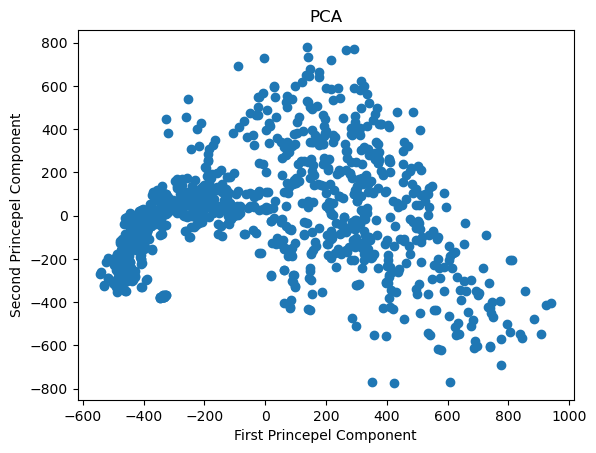

In [31]:
plt.scatter(pca_data[:,0],pca_data[:,1])
plt.title('PCA')
plt.xlabel("First Princepel Component")
plt.ylabel("Second Princepel Component")
plt.show()

Here we're calculating the Within-Cluster-Sum of Squared Errors (WSS). A measure used to evaluate the quality of clustering results.
It calculates the sum of squared distances between each point and its assigned cluster centroid.
The WSS quantifies the variation of data points within a cluster, and the aim of clustering is to minimize this metric.

In [32]:
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

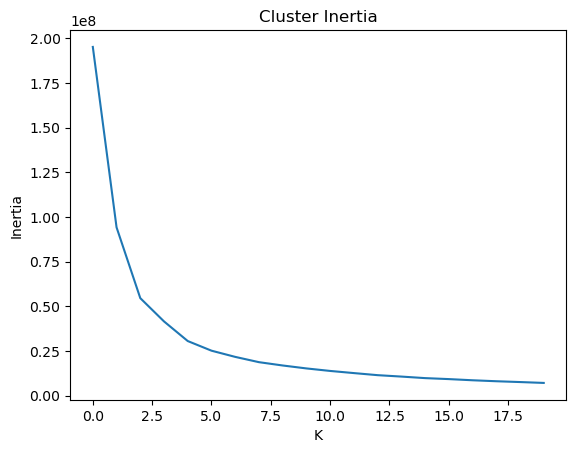

In [33]:
sse = calculate_WSS(pca_data, 20)
plt.plot(sse)
plt.title('Cluster Inertia')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

We can see that the "elbow" is aroud 3 so we can estimate that this is optimal number of clusters.

Now after preforming the PCA and finding the K we are ready to implement the K-means algorithm.
K-means is a type of unsupervised machine learning algorithm used for clustering or grouping similar data points together in a dataset.
The algorithm works by iteratively partitioning a dataset into k clusters.
The goal of the algorithm is to minimize the sum of squared distances between the data points and their assigned cluster centers.

In [34]:
kmean = KMeans(3)
clusters = kmean.fit_transform(pca_data)
cl = np.argmin(clusters, axis=-1)
print(np.bincount(cl))

[264 494 248]


We can see our data is pretty evenly clustered, so our choice was not too bad.

Let's plot this.

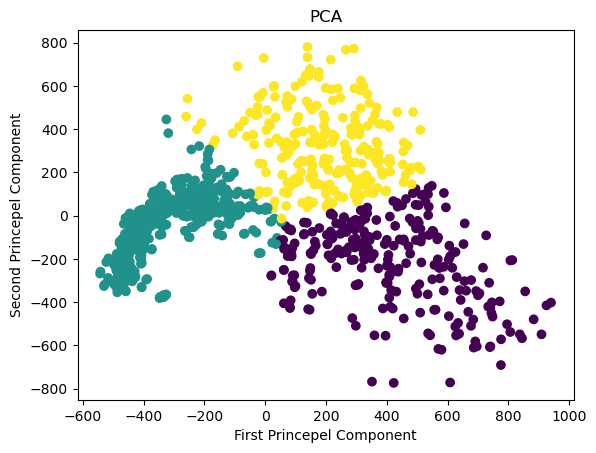

In [35]:
plt.scatter(pca_data[:,0],pca_data[:,1], c=cl)
plt.title('PCA')
plt.xlabel("First Princepel Component")
plt.ylabel("Second Princepel Component")
plt.show()

We can see 3 distinct clustters based on our feature extraction

Let's plot some images from our 3 clusters.

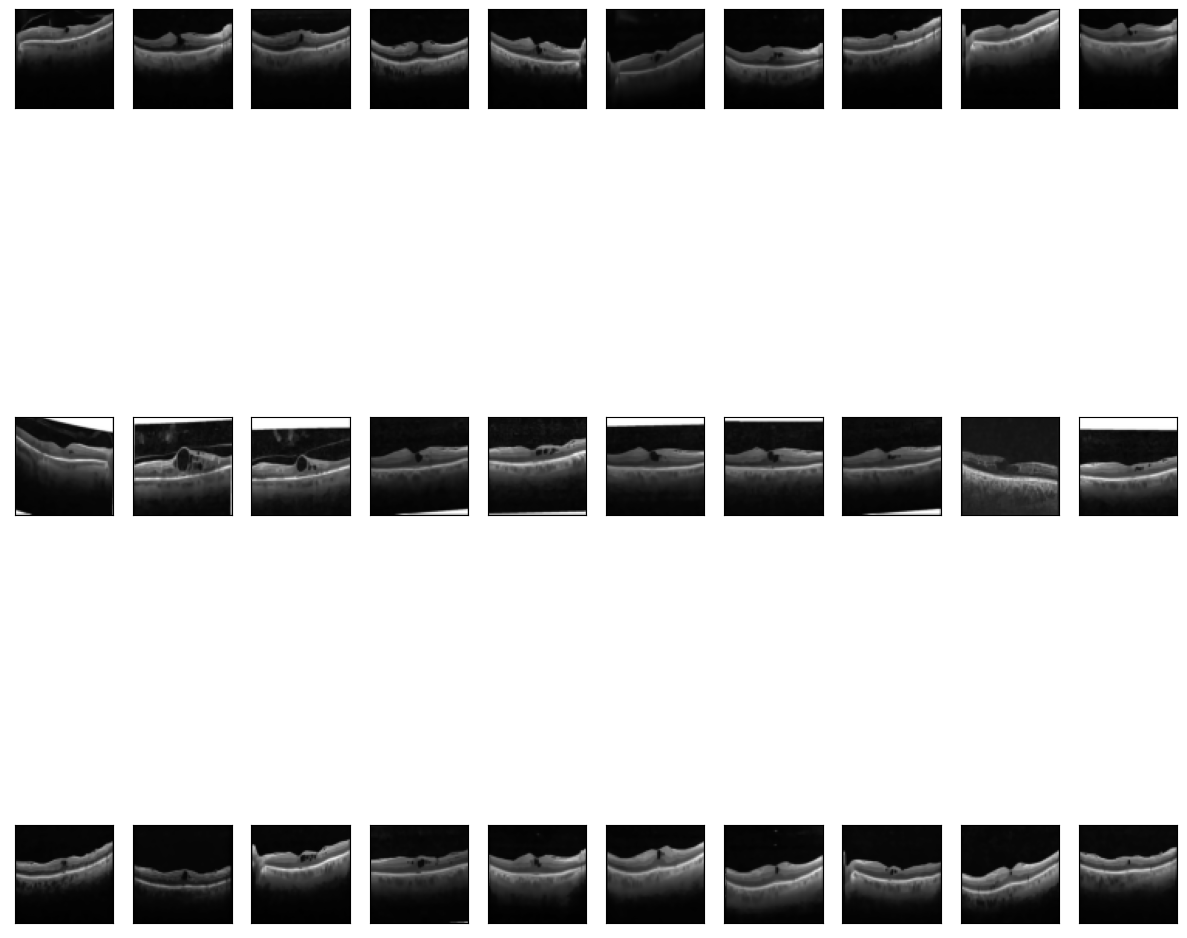

In [36]:
idxs = []
for i in range(np.max(cl)+1):
    idx = np.where(cl==i)[0]
    idxs.append(idx)

plt.figure(figsize=(15,15))
for i in range(3):
    for j in range(10):
        plt.subplot(3, 10, 1+i*10+j)
        tmp = idxs[i][j]
        plt.imshow(x_data[tmp])
        plt.xticks([])
        plt.yticks([])
plt.show()

By looking at the images we can see some pattern by which the images was divided into classes. The brightness levels are simillar in each cluster and also the positioning and angle of the retina is simillar for each class.
so we can conclude that the data is clustered around 3 clussters when HOG, SIFT and brightness are taken into account. 

Now that we have our 3 clusters let's see if there's a difference between them in regards the number of images that containing a fluid.   

In [37]:
def count_non_fluids(images_data, idxs):
    images_data = images_data[idxs]
    n_images = images_data.shape[0]
    n_true_images = np.count_nonzero(np.any(images_data, axis=(1, 2)))
    n_false_images = n_images - n_true_images
    return n_false_images

In [38]:
fluids_in_cl1 = len(idxs[0]) - count_non_fluids(y_data, idxs[0])
fluids_in_cl2 = len(idxs[1]) - count_non_fluids(y_data, idxs[1])
fluids_in_cl3 = len(idxs[2]) - count_non_fluids(y_data, idxs[2])
fluids_in_clusters = [fluids_in_cl1, fluids_in_cl2, fluids_in_cl3]
size_of_clusters = [len(idxs[0]), len(idxs[1]), len(idxs[2])]

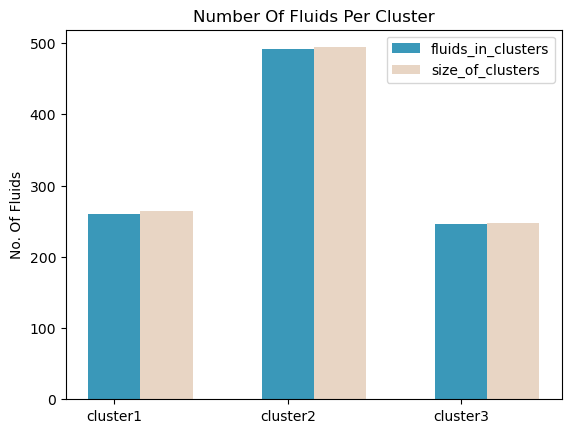

In [39]:
labels = ['cluster1', 'cluster2', 'cluster3']
plt.xticks(range(len(fluids_in_clusters)), labels)
plt.ylabel('No. Of Fluids')
plt.title('Number Of Fluids Per Cluster')
width = 0.3
plt.bar(np.arange(len(fluids_in_clusters)), fluids_in_clusters, width=width, label='fluids_in_clusters', color='#3A98B9')
plt.bar(np.arange(len(size_of_clusters))+ width, size_of_clusters, width=width, label='size_of_clusters', color='#E8D5C4')
plt.legend()
plt.show()

We can see that there isn't significant difference between the clusters in regards to images with fluids and without.

Let's check if there is a diffrence between the clusters in regards of fluid amount

In [40]:
fluid_pixls_cl1= np.count_nonzero(np.any(y_data[idxs[0]], axis=(1, 2)))
fluid_pixls_cl2= np.count_nonzero(np.any(y_data[idxs[1]], axis=(1, 2)))
fluid_pixls_cl3= np.count_nonzero(np.any(y_data[idxs[2]], axis=(1, 2)))

total_pixels_cl1 = y_data[idxs[0]].size
total_pixels_cl2 = y_data[idxs[1]].size
total_pixels_cl3 = y_data[idxs[2]].size

In [41]:
avg_amount_of_pixels_cl1 = fluid_pixls_cl1/total_pixels_cl1
avg_amount_of_pixels_cl2 = fluid_pixls_cl2/total_pixels_cl2
avg_amount_of_pixels_cl3 = fluid_pixls_cl3/total_pixels_cl3
avg_amount_of_pixels = [avg_amount_of_pixels_cl1, avg_amount_of_pixels_cl2, avg_amount_of_pixels_cl3]

In [42]:
def plot_clusters(data, labels, ylebel=None, xlabel=None , title=None, color=None):
    #plt.xticks(range(len(data)), labels)
    plt.ylabel(ylebel)
    plt.title(title)
    plt.bar(labels, data, color= color)
    plt.show()

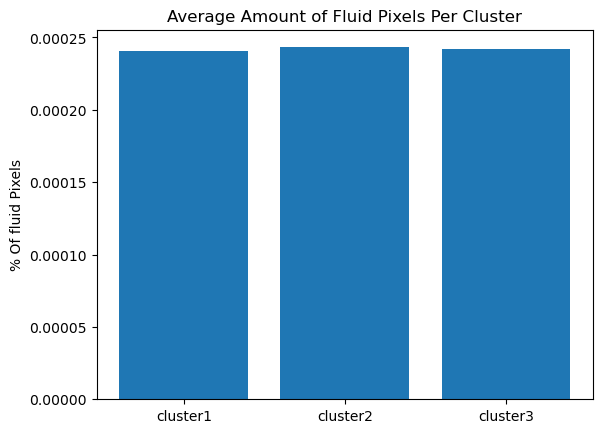

In [43]:
labels = ['cluster1', 'cluster2', 'cluster3']
plot_clusters(avg_amount_of_pixels, labels, ylebel='% Of fluid Pixels', title='Average Amount of Fluid Pixels Per Cluster')

We can see that there isn't significant difference between the clusters in regards to the average amount of pixels of fluid.

Let's calculate the brightness per cluster

In [44]:
def calc_brightness(idxs):
    img_color = []
    for img in range(len(idxs)):
        grey = cv2.cvtColor((x_data[idxs[i]]*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        img_color.append(grey)
    return img_color

In [45]:
cl1_sum = calc_brightness(idxs[0])
s1 = np.sum(cl1_sum)
img_num_cl1 = len(idxs[0])

cl2_sum = calc_brightness(idxs[1])
s2 = np.sum(cl1_sum)
img_num_cl2 = len(idxs[1])

cl3_sum = calc_brightness(idxs[2])
s3 = np.sum(cl1_sum)
img_num_cl3 = len(idxs[2])

In [46]:
brightness_per_cl = [s1//img_num_cl1, s2//img_num_cl2, s3//img_num_cl3]

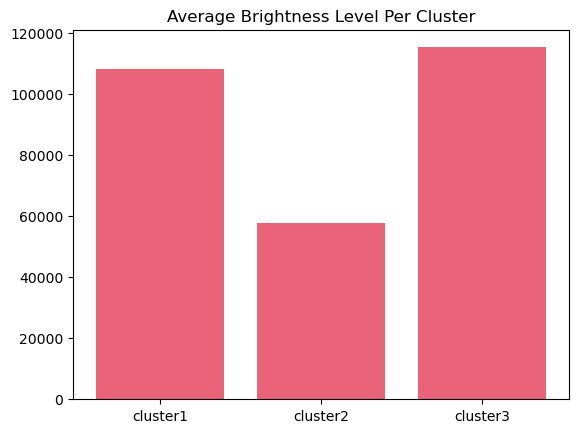

In [47]:
labels = ['cluster1', 'cluster2', 'cluster3']
plot_clusters(brightness_per_cl, labels, title='Average Brightness Level Per Cluster', color='#E96479')

As we mentioned above, just by looking at the images in every cluster, we can see that cluster 1 much brighter than the other two.

In [48]:
cm1 = []

cm2 = []
for i in range(3):
    c_hog = img_hog[idxs[i]]
    c_hog = c_hog.reshape(-1,36,9)
    cm1.append(np.mean(c_hog))
    cm2.append(np.std(c_hog))

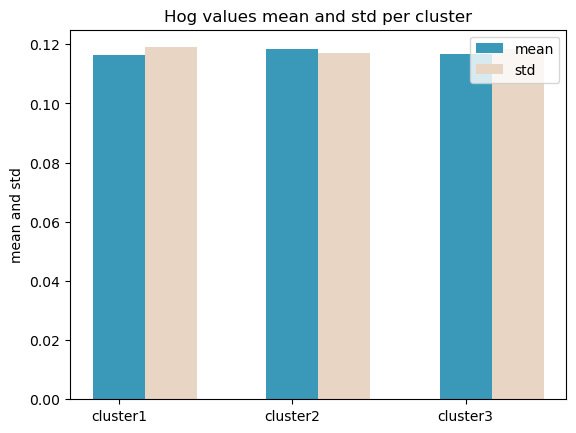

In [49]:
labels = ['cluster1', 'cluster2', 'cluster3']
plt.xticks(range(len(fluids_in_clusters)), labels)
plt.ylabel('mean and std')
plt.title('Hog values mean and std per cluster')
width = 0.3
plt.bar(np.arange(len(fluids_in_clusters)), cm1, width=width, label='mean', color='#3A98B9')
plt.bar(np.arange(len(size_of_clusters))+ width, cm2, width=width, label='std', color='#E8D5C4')
plt.legend()
plt.show()

We can see that most hog values in each cluster reside in the simillar range

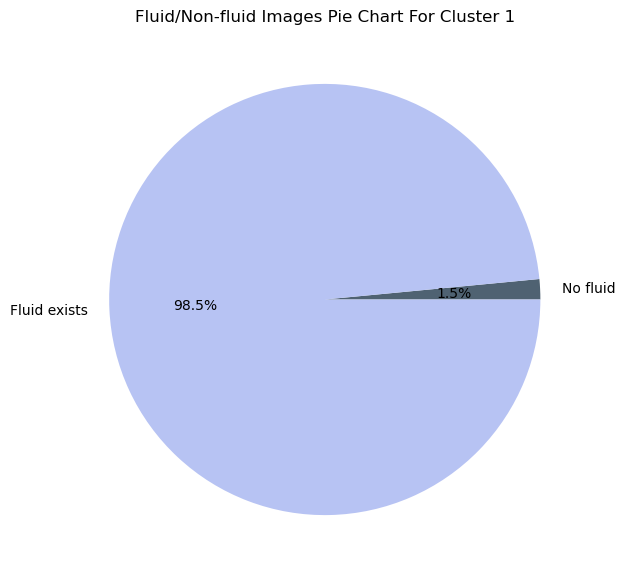

In [50]:
plot_piechart(y_data[idxs[0]], "Fluid/Non-fluid Images Pie Chart For Cluster 1")

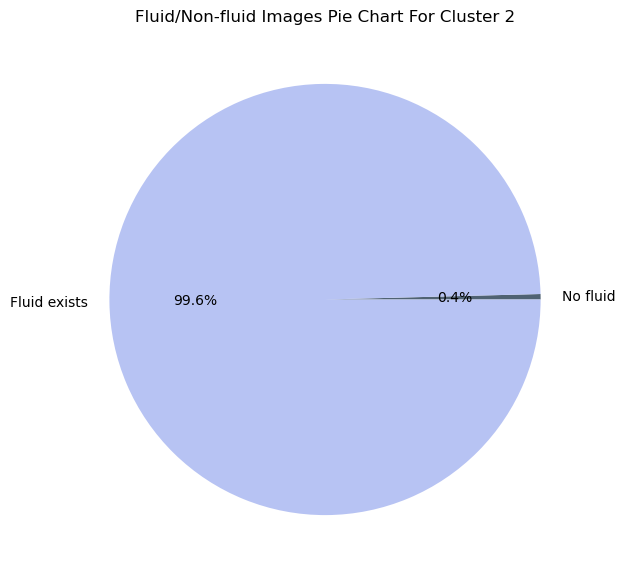

In [51]:
plot_piechart(y_data[idxs[1]], "Fluid/Non-fluid Images Pie Chart For Cluster 2")

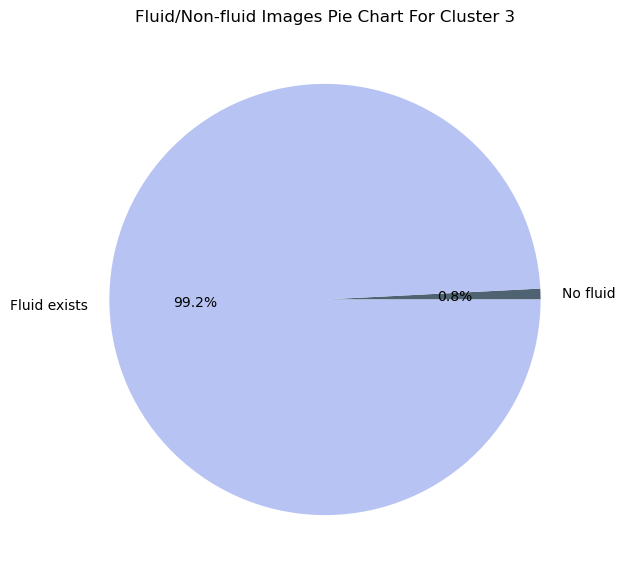

In [52]:
plot_piechart(y_data[idxs[2]], "Fluid/Non-fluid Images Pie Chart For Cluster 3")

As we can see there's a minor difference between the clusters in regards the fluid containing images, that is to be somewhat expected considering the fact that more than 99% of the total number of images containing fluids.

## 4.2. Dataset and Dataloaders

In [53]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We split the 1006 samples into the train-validation group and the testing group. We keep the test dataset aside, for now.   

The original dataset does in fact contains 149 test samples, but provided the images alone, without the fluid musk, so we can not evaluate our models on this data.

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)

In [55]:
class OCTDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        self.mean = x.mean()
        self.std = x.std()
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
                
        x = (x - self.mean) / self.std

        if self.transform:
            x = self.transform(x)
        
        return x, y

We now create our dataloaders, creating one for training data and one for validation during training.  
Our batch size will be 100, based on trial and error, and the hardware limits.

In [56]:
TRAIN_VALIDATION_PERC_SPLIT = 0.8

transformations = transforms.Compose([
    transforms.ToTensor()
    ])

full_dataset = OCTDataset(x_train, y_train, transform=transformations)

train_size = int(TRAIN_VALIDATION_PERC_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False)

We will now create the test dataset and test dataloader.

In [57]:
print("X test shape {}".format(x_test.shape))
print("Y test shape {}".format(y_test.shape))
test_dataset = OCTDataset(x_test, y_test, transform=transformations)
test_dataloader = DataLoader(test_dataset)

X test shape (202, 64, 64, 3)
Y test shape (202, 64, 64, 1)


## 4.3. Training and evaluation functions

We will create a few functions to help us automate the training process. We will use smp (segmentation models pytorch) open source as our training & validation engine.  
As defined before, our loss function will be dice loss.  
As for the optimizer, our trial and error have led us to choose AdamW with a learning rate of 0.0008. It showed consistent and good results.

In [58]:
def get_run_configs(model):
    loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=False)
    loss.__name__ = 'Dice_loss'
    
    metrics = [
        smp.utils.metrics.Recall(),
        smp.utils.metrics.Precision()
    ]
    
    optimizer = torch.optim.AdamW([ 
        dict(params=model.parameters(), lr=0.0008),
    ])
    
    return loss, metrics, optimizer

In [59]:
def get_train_epoch(model, loss, metrics, optimizer, device, verbose=True):
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=device,
        verbose=verbose
    )
    return train_epoch

def get_val_epoch(model, loss, metrics, optimizer, device, verbose=True):
    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=verbose
    )
    
    return valid_epoch

We next define the main train function. It trains a model on the given train data, and validates it after each epoch using the validation data. In addition, in each epoch is checks if the current dice loss on the validation data is the best - hence the model is the best - and saves it, in that case. For convenience reason we will always save the best current model on "./best_model.pth" and load it from that path. 

In [60]:
def train(model, train_dataloader, val_dataloader, epochs = 10, verbose=False):
    model.train()
    
    loss, metrics, optimizer = get_run_configs(model)
    train_epoch = get_train_epoch(model, loss, metrics, optimizer, DEVICE, verbose)
    valid_epoch = get_val_epoch(model, loss, metrics, optimizer, DEVICE, verbose)
    
    best_dice_loss = 1
    train_logs_list, valid_logs_list = [], []

    for current_epoch in range(1, epochs+1):
        print('\nEpoch: {}'.format(current_epoch))
        train_logs = train_epoch.run(train_dataloader)
        valid_logs = valid_epoch.run(val_dataloader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        print('Dice loss of {:.3f}'.format(valid_logs['Dice_loss']))
        if valid_logs['Dice_loss'] < best_dice_loss:
            best_dice_loss = valid_logs['Dice_loss']
            print('This is a new best model!')
            torch.save(model, './best_model.pth')
                
    
    return train_logs_list, valid_logs_list

In [61]:
def load_current_best_model(device):
    return torch.load('./best_model.pth', map_location=DEVICE)

We now create a "DB" (dictionary, actually) and accompanying functions to save model test results. We want to keep track of the models' performance, to be able to observe throughout the notebook which model gave the best results.  

We create a dataclass called "ModelTest", which will help us store model test results.

In [62]:
@dataclass
class ModelTest:
    test_name: str
    model_name: str
    score: float
    description: str

In [63]:
MODEL_TEST_TRACKER = {}

We create a function that inserts a ModelTest object to the model test tracker. In addition, we create a function to visualize all of the results stroed in the model test tracker.

In [64]:
def insert_model_test(model_test: ModelTest):
    if model_test.test_name in MODEL_TEST_TRACKER:
        print("{} test is already in the model test tracker! Can't insert")
    else:
        MODEL_TEST_TRACKER[model_test.test_name] = model_test

def visualize_models_tests_scores():
    scores = []
    test_names = []
    model_names = []
    for test_name, model_test in MODEL_TEST_TRACKER.items():
        scores.append(model_test.score)
        test_names.append(test_name)
        model_names.append(model_test.model_name)

    data = {'test_name': test_names, 'model_name': model_names, 'score': scores}
    df = pd.DataFrame(data)
    df.sort_values(by='score', inplace=True, ascending=True)

    with sns.color_palette("pastel"), sns.axes_style("whitegrid"), sns.plotting_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5}):
        plt.figure(figsize=(20,10))
        sns.barplot(x='test_name', y='score', hue='model_name', data=df)
        plt.title("Model Test Scores")
        plt.ylabel("Score")
        plt.xlabel("Test Name")
        
        plt.tick_params(axis='x', labelsize=8)
        plt.legend(title="Model Name",loc='upper left')
        plt.xticks(rotation=15)
        plt.ylim(0, 1)
        
        plt.show()

We will now create a function to evaluate our models on the test dataset. The function receives a model and a data loader and runs in evaluation mode a test epoch.

In [65]:
def test_model(model, test_dataloader):
    model.eval()
    loss, metrics, optimizer = get_run_configs(model)
    test_epoch = get_val_epoch(model, loss, metrics, optimizer, DEVICE)
    
    test_logs = test_epoch.run(test_dataloader)
    
    return test_logs

For evaluation that doesn't happen as a part of a validation epoch, we will create a dice loss calculation function.

In [66]:
def dice_loss_calc(y_true, y_pred, smooth=1):
    intersection = (y_true * y_pred).sum(dim=(1, 2, 3))
    union = y_true.sum(dim=(1, 2, 3)) + y_pred.sum(dim=(1, 2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    loss = 1.0 - dice
    return loss.mean()

## 4.4. A Naive Guess

We will begin by making a rough estimate. First, we will calculate the average number of fluids in a scan, and then mark the top k (the average number of fluids) most common fluid pixels. This will provide us with a simple baseline to compare our models with.

In [67]:
def top_k_fluid_pixels(mask_data, k):
    num_images = mask_data.shape[0]
    
    height = mask_data.shape[1]
    width = mask_data.shape[2]
    
    flat_arr = mask_data.reshape((num_images, height * width))
    
    pixel_sums = np.sum(flat_arr, axis=0)
    
    top_pixel_indices = np.argsort(pixel_sums)[::-1][:k]

    top_pixels = np.zeros((mask_data.shape[1], mask_data.shape[2], mask_data.shape[3]), dtype=bool)
    top_pixels.flat[top_pixel_indices] = True
    
    return top_pixels

In [68]:
def avg_fluid_pixels(mask_data):
    num_images = mask_data.shape[0]
    
    height = mask_data.shape[1]
    width = mask_data.shape[2]
    
    flat_arr = mask_data.reshape((num_images, height * width))
    
    fluid_counts_per_image = np.sum(flat_arr, axis=1)
    
    avg_fluid_count = np.mean(fluid_counts_per_image)
    
    return avg_fluid_count

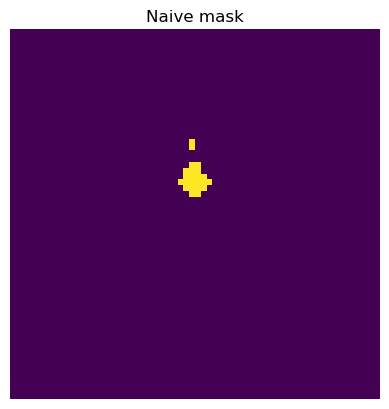

In [69]:
avg_fluids_num = avg_fluid_pixels(y_train)
naive_mask = top_k_fluid_pixels(y_train, int(avg_fluids_num))
display_image(naive_mask, "Naive mask")

## 4.5. Classic Algorithm

Here we're defining feature extractor for classic algorithem

In [70]:
winSize = (71,71)
blockSize = (8,8)
blockStride = (1,1)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

winStride = (2,2)
padding = (8,8)
padding = (8,8)
locations = ((20,20),)

Extracting train data features plus concatenating RGB brightness features. Also, reshaping for classic algorithem.

In [71]:
def preprocess_dataset(X, y):
    X_hog = []
    for img in X[:]:
        grey = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        hist = hog.compute(grey,winStride,padding,locations)
        X_hog.append(hist)

    X_hog = np.array(X_hog)
    X_hog = X_hog.reshape(-1,64,64,9)
    cv_data = np.concatenate([X/255., X_hog], axis=-1)
    cv_data_flat = cv_data.reshape(-1, 12)
    y_flat = y.reshape(-1,1)
    
    return cv_data_flat, y_flat
    

In [72]:
cv_train_data, y_train_flat = preprocess_dataset(x_train, y_train)
cv_test_data, y_test_flat = preprocess_dataset(x_test, y_test)

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

performing data standardization

In [74]:
scaler = StandardScaler()
cv_train_data = scaler.fit_transform(cv_train_data)
cv_test_data = scaler.transform(cv_test_data)

Training logistic regression classifier. We are defining the class weight to punish wrong predictions for class 0 and class 1. 
Since there are significantly less pixels from the "fluid" class, we want to increase the weight of miss detection error.

In [75]:
np.sum(y_train_flat[:,0]>0) / y_train_flat[:,0].shape[0]

0.005751576589707711

In [76]:
clf = LogisticRegression(class_weight={0:0.17, 1:5**1})
clf.fit(cv_train_data, y_train_flat[:,0].astype(int) )

LogisticRegression(class_weight={0: 0.17, 1: 5})

Making predictions on test data

In [77]:
y_pred_flat = clf.predict_proba(cv_test_data)

In [78]:
y_pred_flat_ratio = y_pred_flat[:,1]
np.sum(y_pred_flat_ratio>0.16)

448644

Total number of pixles predicted as fluid.

Defining the threshold for test predictions.

In [79]:
y_pred_flat_ratio = y_pred_flat[:,1]
y_pred_flat_ratio = y_pred_flat_ratio>0.16

y_pred = y_pred_flat_ratio.reshape(y_test.shape).astype(int)


Calculating evaluation metrics

In [80]:
y_test1 = y_test.astype(int)
print(np.sum(y_pred*y_test1)/np.sum(y_test1))

0.3069136745607334


Detection rate, the ratio of pixels with fluid label that are also predicted as fluid by the model.

Defining the loss function

In [81]:
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=False)

Evaluating prediction loss

In [82]:
loss = loss_fn(torch.from_numpy(y_pred), torch.from_numpy(y_test))
print(loss.item())
reg_loss = loss.item()

0.992918848991394


Since classical features algorithms cannot encapsulate neighbouring pixels values the learning phase does not take in to account the pixel surroundings,
so we can predict a poor result in segmentaion tasks.

In [83]:
insert_model_test(model_test=ModelTest("Classic Algorithm", "Logistic Regression", reg_loss, "NONE"))
print("Dice loss for test dataset: {:.3f}".format(reg_loss))

Dice loss for test dataset: 0.993


## 4.6. U-Net Model

### 4.6.1. U-Net Model Creation

We will now create our first model - the U-Net model. U-Net is a fully convolutional neural network architecture that was originally created for image segmentation tasks.  
The architecture of the U-Net model is characterized by its  "U" shaped structure, which allows the model to efficiently utilize both high and low-level features in an image. The model is composed of an encoder, which captures context through regular convolutional and max-pooling layers, and a decoder, which uses transposed convolutional layers to upscale the feature maps, and finally generate a segmentation mask using the segmentation head. Between the encoder and the decoder, there are few convolutional layers in what is called bottleneck or latent space. The encoder and the decoder parts are connected by a set of skip connections, which allows the model to propagate information from the encoder to the decoder, which improves the predicted segmentation.  
This model architecture is widely used in the OCT fluid segmentation task [4].

![u-net-architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

We can see in the model architecture the U shape and in the left half the encoder part - with multiple convolution and max pooling operations. At the bottom of the architecture image, is the latent space, and in the right half - is the decoder.  
In our model, after playing with the results and according to the latest standard, we added dropout layers.

In [84]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, pool_kernel_size=2):
        super(EncoderBlock, self).__init__()
        self.conv_block = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.Dropout2d(p=0.2),
                    torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
                    torch.nn.ReLU(),
                )
        self.down_sample = nn.MaxPool2d(pool_kernel_size)

    def forward(self, x):
        skip_out = self.conv_block(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)
    
    
class LatentSpaceBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(LatentSpaceBlock, self).__init__()
        self.conv_block = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.Dropout2d(p=0.1),
                    torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
                    torch.nn.ReLU()
                )

    def forward(self, x):
        x = self.conv_block(x)
        return x
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, conv_kernel_size=3, conv_transpose_kernel_size=2, stride=2, padding=1):
        super(DecoderBlock, self).__init__()
        self.up_sample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=conv_transpose_kernel_size, stride=stride)        
        self.conv_block = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=conv_kernel_size, padding=padding),
                    torch.nn.ReLU(),
                    torch.nn.Dropout2d(p=0.2),
                    torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=conv_kernel_size, padding=padding),
                    torch.nn.ReLU()
                )

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.conv_block(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.encoder_block1 = EncoderBlock(in_channels, 64)
        self.encoder_block2 = EncoderBlock(64, 128)
        self.encoder_block3 = EncoderBlock(128, 256)
        self.encoder_block4 = EncoderBlock(256, 512)
        
        self.latent_space_block = LatentSpaceBlock(512, 1024)

        self.decoder_block1 = DecoderBlock(1024, 512)
        self.decoder_block2 = DecoderBlock(512, 256)
        self.decoder_block3 = DecoderBlock(256, 128)
        self.decoder_block4 = DecoderBlock(128, 64)
        
        self.final_conv = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=1), nn.Sigmoid())

    def forward(self, x):
        x = x.double()
        x, skip1_out = self.encoder_block1(x)
        x, skip2_out = self.encoder_block2(x)      
        x, skip3_out = self.encoder_block3(x)
    
        x, skip4_out = self.encoder_block4(x)
        
        x = self.latent_space_block(x)
        x = self.decoder_block1(x, skip4_out)
        x = self.decoder_block2(x, skip3_out)
        x = self.decoder_block3(x, skip2_out)
        x = self.decoder_block4(x, skip1_out)
        
        x = self.final_conv(x)

        return x

### 4.6.2. U-Net Model Training

Our model is defined. We will now create an instance of it, and train it using the dataloaders we created earlier.  
Notice that we transform all of our models to have double values, and not float. This is due to memory issues we were facing, and the using doubles helped somewhat with that issue.

In [85]:
%%time
u_net = UNet(in_channels=3, out_channels=1)
u_net = u_net.double()
u_net = u_net.to(DEVICE)

train_logs_list, valid_logs_list = train(u_net, train_dataloader, val_dataloader, epochs=EPOCHS)


Epoch: 1
Dice loss of 0.975
This is a new best model!

Epoch: 2
Dice loss of 0.729
This is a new best model!

Epoch: 3
Dice loss of 0.735

Epoch: 4
Dice loss of 0.549
This is a new best model!

Epoch: 5
Dice loss of 0.541
This is a new best model!

Epoch: 6
Dice loss of 0.476
This is a new best model!

Epoch: 7
Dice loss of 0.436
This is a new best model!

Epoch: 8
Dice loss of 0.649

Epoch: 9
Dice loss of 0.413
This is a new best model!

Epoch: 10
Dice loss of 0.401
This is a new best model!

Epoch: 11
Dice loss of 0.339
This is a new best model!

Epoch: 12
Dice loss of 0.342

Epoch: 13
Dice loss of 0.306
This is a new best model!

Epoch: 14
Dice loss of 0.299
This is a new best model!

Epoch: 15
Dice loss of 0.288
This is a new best model!

Epoch: 16
Dice loss of 0.276
This is a new best model!

Epoch: 17
Dice loss of 0.264
This is a new best model!

Epoch: 18
Dice loss of 0.254
This is a new best model!

Epoch: 19
Dice loss of 0.242
This is a new best model!

Epoch: 20
Dice loss of

In [86]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

As we wrote before, we will use the "load current best model" function to load the best model which is last saved.

In [87]:
u_net_best_model = load_current_best_model(DEVICE)
print('Loaded the best UNet.')

Loaded the best UNet.


Good - we have trained successfully our model. Now we would like to see with our own eyes some of its predictions, against the mask GT. We shall remember that when creating our dataset, we normalized the image data, hence the colors may seem a bit weird, but it does not affect our evaluation. 

In [88]:
def display_random_predictions_from_dataset(trained_model, dataset, num_predictions=5):
    trained_model.eval()
    for idx in range(num_predictions):

        random_idx = random.randint(0, len(dataset)-1)
        image, gt_mask = dataset[random_idx]
        x_tensor = image.to(DEVICE).unsqueeze(0)
        
        pred_mask = trained_model(x_tensor)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy().round()
        
        image = np.transpose(image,(1,2,0))
        display_predictions(image, gt_mask, pred_mask, "Original image", "Mask", "Predicted mask")

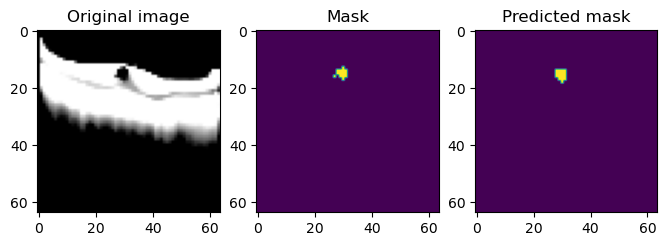

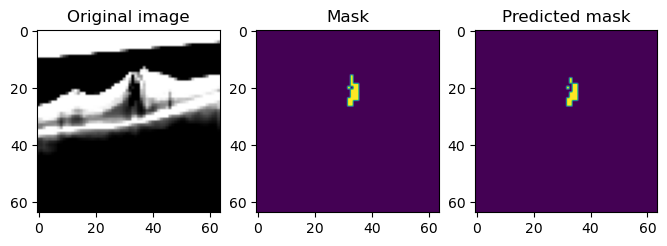

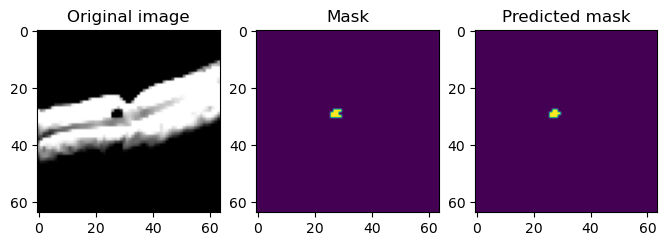

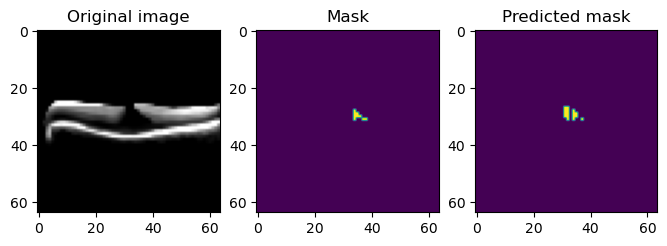

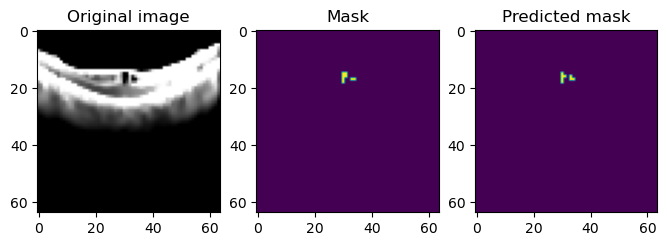

In [89]:
display_random_predictions_from_dataset(u_net_best_model, val_dataset)

Our model is not bad! Although it is our "first try", we observe that the U-Net model is a robust and strong model for medical imaging segmentation problems.  
It is not perfect - for the right medical treatment, the fluid segmentation must be perfect - be we have a good start.  
Now, we will visualize the train & validation loss, to see its progress through the epochs, learn about it, and try to detect overfitting.

In [90]:
def plot_train_scores(train_logs_df, valid_logs_df, metric_name, metric_display_name, title=None):
    if title is None:
        title = metric_display_name
    plt.figure(figsize=(20,8))
    train_indices = [x+1 for x in train_logs_df.index.tolist()]
    val_indices = [x+1 for x in valid_logs_df.index.tolist()]
    plt.plot(train_indices, train_logs_df[metric_name].tolist(), lw=3, label = 'Train')
    plt.plot(val_indices, valid_logs_df[metric_name].tolist(), lw=3, label = 'Valid')
    plt.xlabel('Epochs', fontsize=21)
    plt.ylabel('{}'.format(metric_display_name), fontsize=21)
    plt.title('{} Plot'.format(title), fontsize=21)
    
    plt.ylim(0, 1)
    plt.xlim(1, len(train_indices)+2)

    plt.legend(loc='best', fontsize=16)
    plt.grid()
    plt.savefig('{}_plot.png'.format(metric_name))
    plt.show()

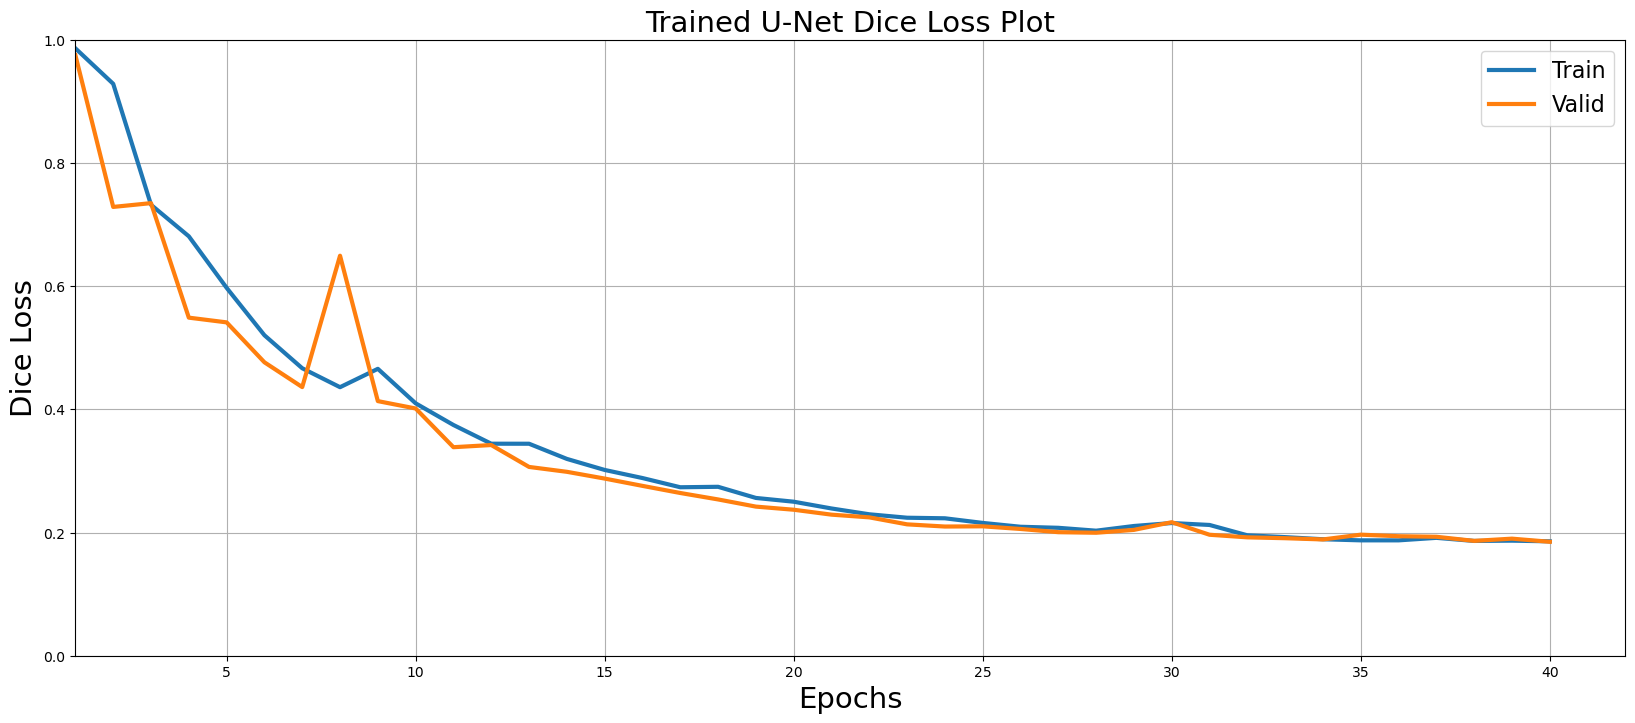

In [91]:
plot_train_scores(train_logs_df, valid_logs_df, "Dice_loss", "Dice Loss", "Trained U-Net Dice Loss")

We learn a few things from this plot:
1. Our model learning is proper, as expected.
1. The model has reached some kind of saturation - training more epochs will not bring a major improvement.
1. The model has generalized well - it has almost no overfitting, i.e. the train data loss is almost identical to the validation data loss. So when the model will predict new images he has never seen, as it should be used, its accuracy will stay the same.

Throughout our work, we encountered memory issues. Along the way, we figured that one way to handle them is to clean the memory.

In [92]:
def clean_memory():
    torch.cuda.empty_cache()
    gc.collect()

In [93]:
clean_memory()

### 4.6.3. U-Net Model Test Evaluation

Let's check our model prediction on a few samples from the test dataset - a dataset it has never seen.

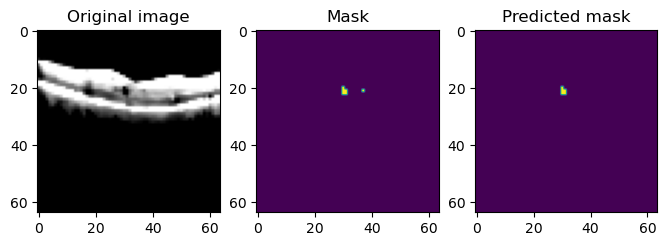

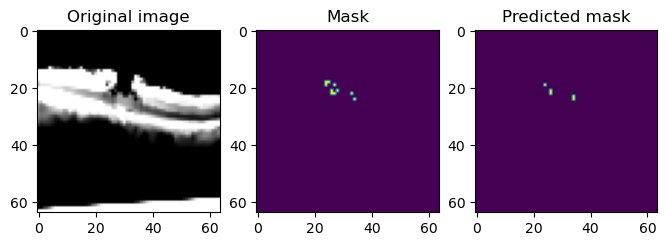

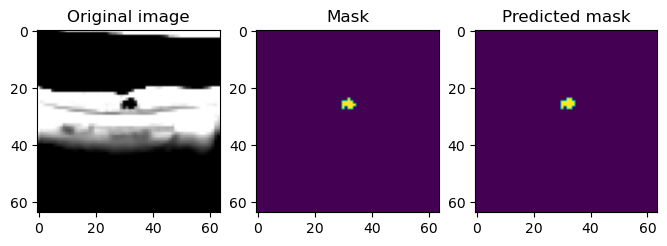

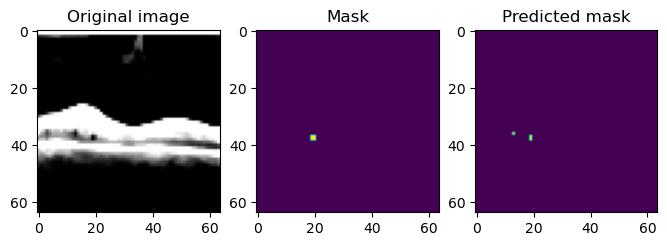

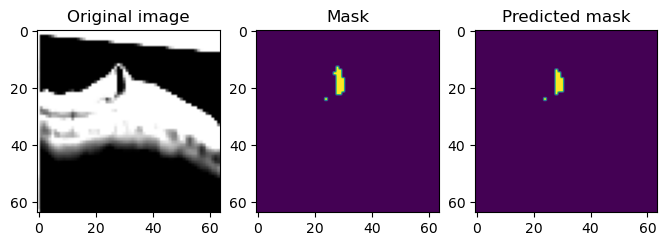

In [94]:
display_random_predictions_from_dataset(u_net_best_model, test_dataset, num_predictions=5)

Although not perfect, we see that the model is consistent, even on new data.

We will now create a function to evaluate our models on the test dataset. The function receives a model and a data loader and runs in evaluation mode a test epoch.

In [95]:
def test_model(model, test_dataloader):
    model.eval()
    loss, metrics, optimizer = get_run_configs(model)
    test_epoch = get_val_epoch(model, loss, metrics, optimizer, DEVICE)
    
    test_logs = test_epoch.run(test_dataloader)
    
    return test_logs

Using our freshly-defined function, let's evaluate the u-net model on the test dataset.

In [96]:
test_logs = test_model(u_net_best_model, test_dataloader)

valid: 100%|██████████| 202/202 [00:03<00:00, 51.98it/s, Dice_loss - 0.2199, recall - 0.7329, precision - 0.8102]


The test results are satisfying - the loss is 0.2, as we could expect from the learning curve above.   
We will take the Dice loss from the test logs, and insert the model test into the model test tracker.

In [97]:
insert_model_test(model_test=ModelTest("Original U-Net", "U-Net", test_logs['Dice_loss'], "U-Net that was created and trained only by the OCT dataset."))
print("Dice loss for test dataset: {:.3f}".format(test_logs['Dice_loss']))

Dice loss for test dataset: 0.220


## 4.7. Advanced Models

### 4.7.1. Pre-trained Advanced Models

Our U-Net gave us solid results. But how can we get any better? One thing that came across our minds was the fact that our training data had only a few hundred samples. Complex models, and neural networks, perform best when given many samples of data to train on. We are facing an issue - we don't have any more OCT scans and fluid masks. One solution we came up with is using pre-trained models. Using the smp library, we will define segmentation models (at first, U-Net), and use pre-trained encoders. The pre-trained encoders were of course not trained on OCT scans, but on regular image datasets (imagenet). 

At first, we will create an encoder of Resnet18.
ResNet, short for Residual Networks, is a deep learning architecture that was introduced in 2015. The key innovation of ResNet is the use of residual connections, which allows the network to learn a residual mapping from the input to the output, rather than trying to learn the entire mapping from scratch. This allows ResNet to be much deeper than traditional architectures without suffering from the problem of vanishing gradients. The Resnet18 has 11M parameters.

In [98]:
pre_trained_resnet18_model = smp.Unet(
    encoder_name="resnet18",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=1,                      
    activation='sigmoid',
)
pre_trained_resnet18_model = pre_trained_resnet18_model.double()
pre_trained_resnet18_model = pre_trained_resnet18_model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

We created our resnet18 model. It is pre-trained, has 11M parameters - sounds great!  
Now, let's visualize some predictions.

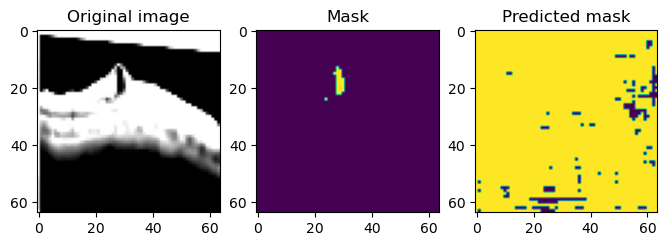

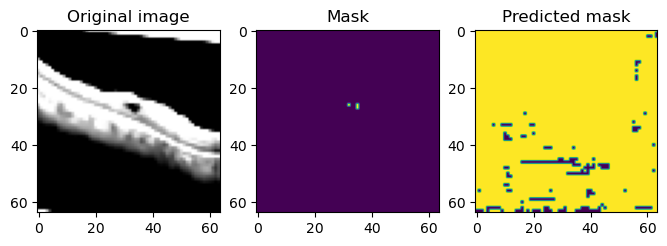

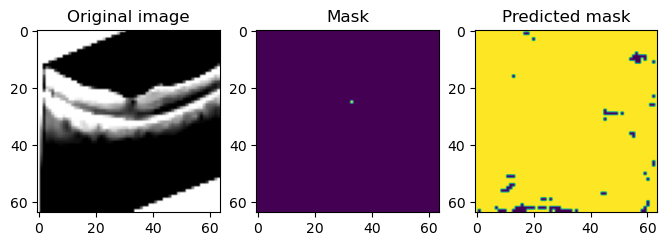

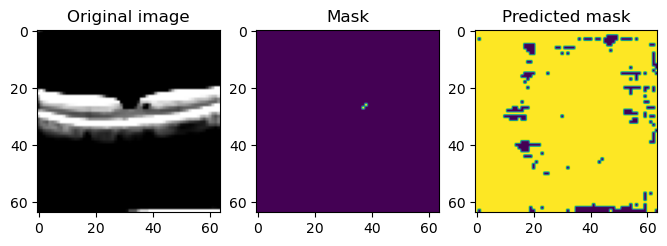

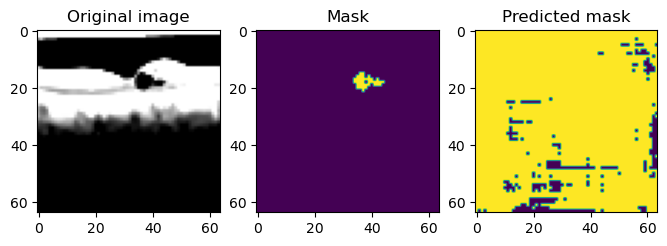

In [99]:
display_random_predictions_from_dataset(pre_trained_resnet18_model, test_dataset, num_predictions=5)

OK. That seems bad. Let's test it's dice loss.

In [100]:
pre_trained_resnet18_model_test_logs = test_model(pre_trained_resnet18_model, test_dataloader)
insert_model_test(model_test=ModelTest("PT Resnet18 imagenet only", "PT Resnet18 imagenet", pre_trained_resnet18_model_test_logs['Dice_loss'], "Pre-trained resnet18 which was trained on imagenet data, and was not trained on OCT data."))
print("Dice loss for test dataset with resnet18 model: {:.3f}".format(pre_trained_resnet18_model_test_logs['Dice_loss']))

valid: 100%|██████████| 202/202 [00:03<00:00, 59.09it/s, Dice_loss - 0.9766, recall - 59.93, precision - 0.4046]
Dice loss for test dataset with resnet18 model: 0.977


The dice loss results are indeed bad. Maybe the problem was the strength of the model? Let's try with a pre-trained Resnet152 as an encoder. The Resnet152 has 58M parameters.

In [101]:
MODEL_TEST_TRACKER

{'Classic Algorithm': ModelTest(test_name='Classic Algorithm', model_name='Logistic Regression', score=0.992918848991394, description='NONE'),
 'Original U-Net': ModelTest(test_name='Original U-Net', model_name='U-Net', score=0.21986911651114546, description='U-Net that was created and trained only by the OCT dataset.'),
 'PT Resnet18 imagenet only': ModelTest(test_name='PT Resnet18 imagenet only', model_name='PT Resnet18 imagenet', score=0.9766273187505171, description='Pre-trained resnet18 which was trained on imagenet data, and was not trained on OCT data.')}

In [102]:
pre_trained_resnet152_model = smp.Unet(
    encoder_name="resnet152",       
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=1,                      
    activation='sigmoid',
)
pre_trained_resnet152_model = pre_trained_resnet152_model.double()
pre_trained_resnet152_model = pre_trained_resnet152_model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [103]:
pre_trained_resnet152_model_test_logs = test_model(pre_trained_resnet152_model, test_dataloader)
insert_model_test(model_test=ModelTest("PT Resnet152 imagenet only", "PT Resnet152 imagenet", pre_trained_resnet152_model_test_logs['Dice_loss'], "Pre-trained resnet152 which was trained on imagenet data, and was not trained on OCT data."))
print("Dice loss for test dataset with resnet152 model: {:.3f}".format(pre_trained_resnet152_model_test_logs['Dice_loss']))

valid: 100%|██████████| 202/202 [00:12<00:00, 15.73it/s, Dice_loss - 0.9782, recall - 0.6107, precision - 0.1416]
Dice loss for test dataset with resnet152 model: 0.978


Even for Resnet152, the results are bad. When we think about it, it makes sense - our decoder isn't trained at all, and the model has never seen OCT scans and fluid and had a chance to learn how to segment correctly. 
So now, we will train our pre-trained Resnet18 model on our own OCT scans. 

In [104]:
train_logs_list, valid_logs_list = train(pre_trained_resnet18_model, train_dataloader, val_dataloader, epochs=EPOCHS, verbose=False)


Epoch: 1
Dice loss of 0.987
This is a new best model!

Epoch: 2
Dice loss of 0.968
This is a new best model!

Epoch: 3
Dice loss of 0.954
This is a new best model!

Epoch: 4
Dice loss of 0.944
This is a new best model!

Epoch: 5
Dice loss of 0.928
This is a new best model!

Epoch: 6
Dice loss of 0.926
This is a new best model!

Epoch: 7
Dice loss of 0.886
This is a new best model!

Epoch: 8
Dice loss of 0.844
This is a new best model!

Epoch: 9
Dice loss of 0.761
This is a new best model!

Epoch: 10
Dice loss of 0.737
This is a new best model!

Epoch: 11
Dice loss of 0.612
This is a new best model!

Epoch: 12
Dice loss of 0.542
This is a new best model!

Epoch: 13
Dice loss of 0.443
This is a new best model!

Epoch: 14
Dice loss of 0.389
This is a new best model!

Epoch: 15
Dice loss of 0.440

Epoch: 16
Dice loss of 0.350
This is a new best model!

Epoch: 17
Dice loss of 0.412

Epoch: 18
Dice loss of 0.336
This is a new best model!

Epoch: 19
Dice loss of 0.301
This is a new best mode

In [105]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

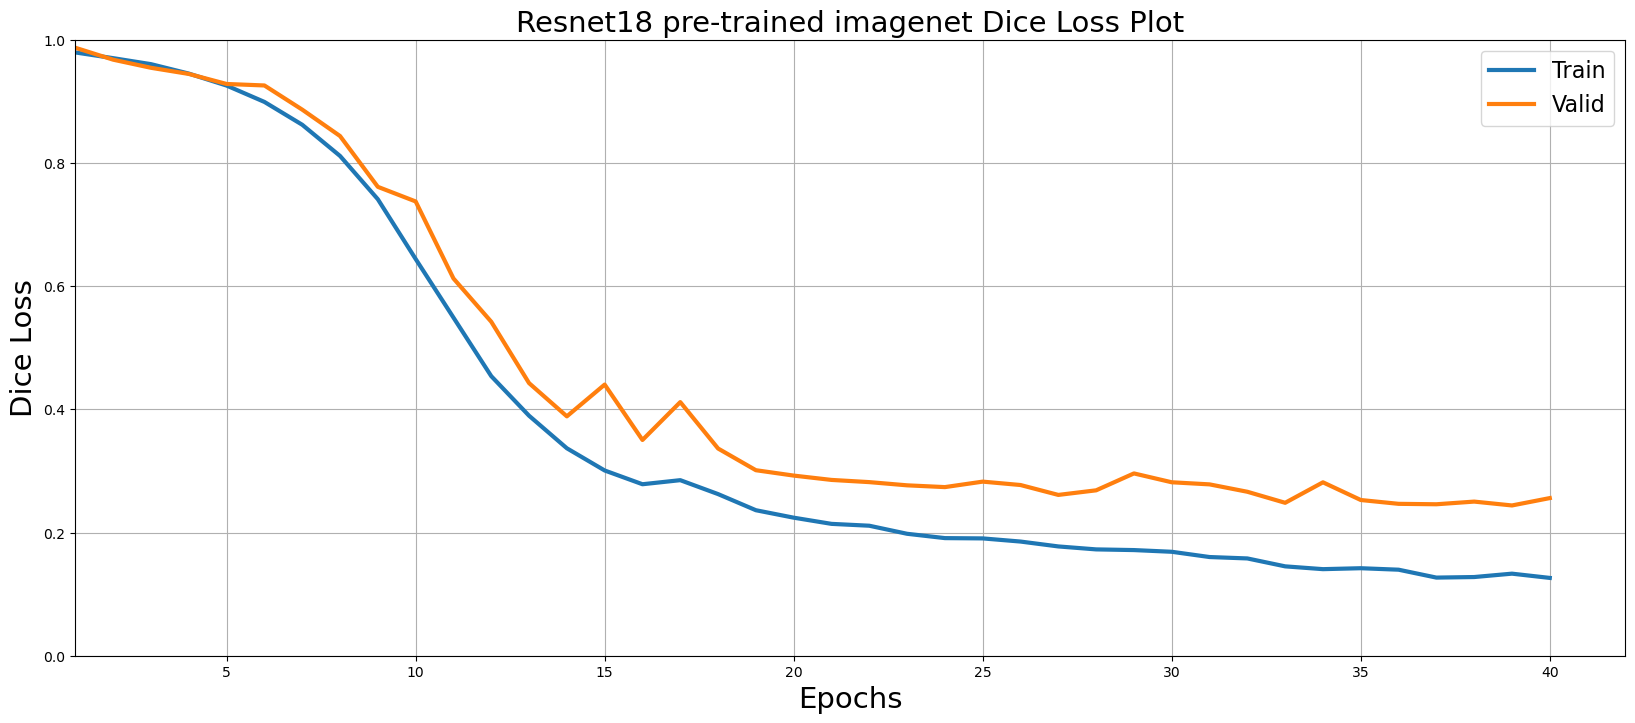

In [106]:
plot_train_scores(train_logs_df, valid_logs_df, "Dice_loss", "Dice Loss", "Resnet18 pre-trained imagenet Dice Loss")

In [107]:
trained_pt_resnet18_best_model = load_current_best_model(DEVICE)

In [108]:
trained_pt_resnet18_model_test_logs = test_model(trained_pt_resnet18_best_model, test_dataloader)
test_dice_loss = trained_pt_resnet18_model_test_logs['Dice_loss']
insert_model_test(model_test=ModelTest("PT Resnet18 imagenet + trained OCT ", "Resnet18 imagenet+OCT", test_dice_loss, "Pre-trained resnet18 which was pre-trained on imagenet data, and later was trained on OCT data."))
print("Dice loss for test dataset with trained resnet18 model: {:.3f}".format(test_dice_loss))

valid: 100%|██████████| 202/202 [00:03<00:00, 59.05it/s, Dice_loss - 0.307, recall - 0.8508, precision - 0.8335] 
Dice loss for test dataset with trained resnet18 model: 0.307


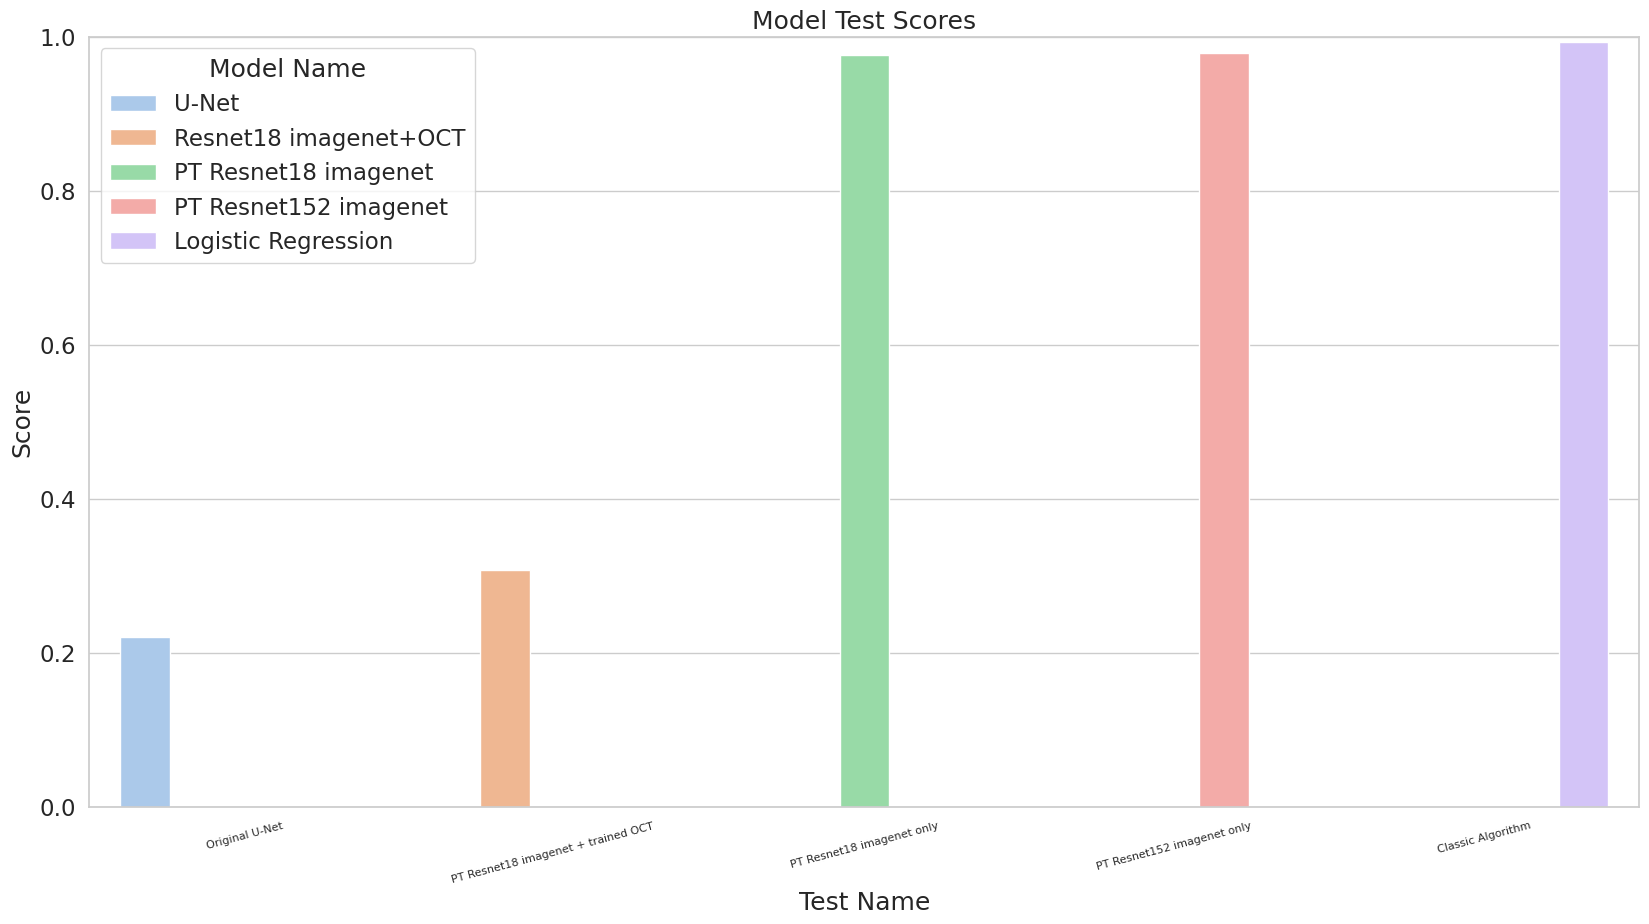

In [109]:
visualize_models_tests_scores()

Now, we will try the same things but with a deeper net - Resnet152.

In [110]:
train_logs_list, valid_logs_list = train(pre_trained_resnet152_model, train_dataloader, val_dataloader, epochs=EPOCHS, verbose=False)


Epoch: 1
Dice loss of 0.975
This is a new best model!

Epoch: 2
Dice loss of 0.980

Epoch: 3
Dice loss of 0.961
This is a new best model!

Epoch: 4
Dice loss of 0.930
This is a new best model!

Epoch: 5
Dice loss of 0.875
This is a new best model!

Epoch: 6
Dice loss of 0.813
This is a new best model!

Epoch: 7
Dice loss of 0.764
This is a new best model!

Epoch: 8
Dice loss of 0.728
This is a new best model!

Epoch: 9
Dice loss of 0.602
This is a new best model!

Epoch: 10
Dice loss of 0.474
This is a new best model!

Epoch: 11
Dice loss of 0.437
This is a new best model!

Epoch: 12
Dice loss of 0.395
This is a new best model!

Epoch: 13
Dice loss of 0.411

Epoch: 14
Dice loss of 0.526

Epoch: 15
Dice loss of 0.382
This is a new best model!

Epoch: 16
Dice loss of 0.297
This is a new best model!

Epoch: 17
Dice loss of 0.286
This is a new best model!

Epoch: 18
Dice loss of 0.280
This is a new best model!

Epoch: 19
Dice loss of 0.288

Epoch: 20
Dice loss of 0.270
This is a new best 

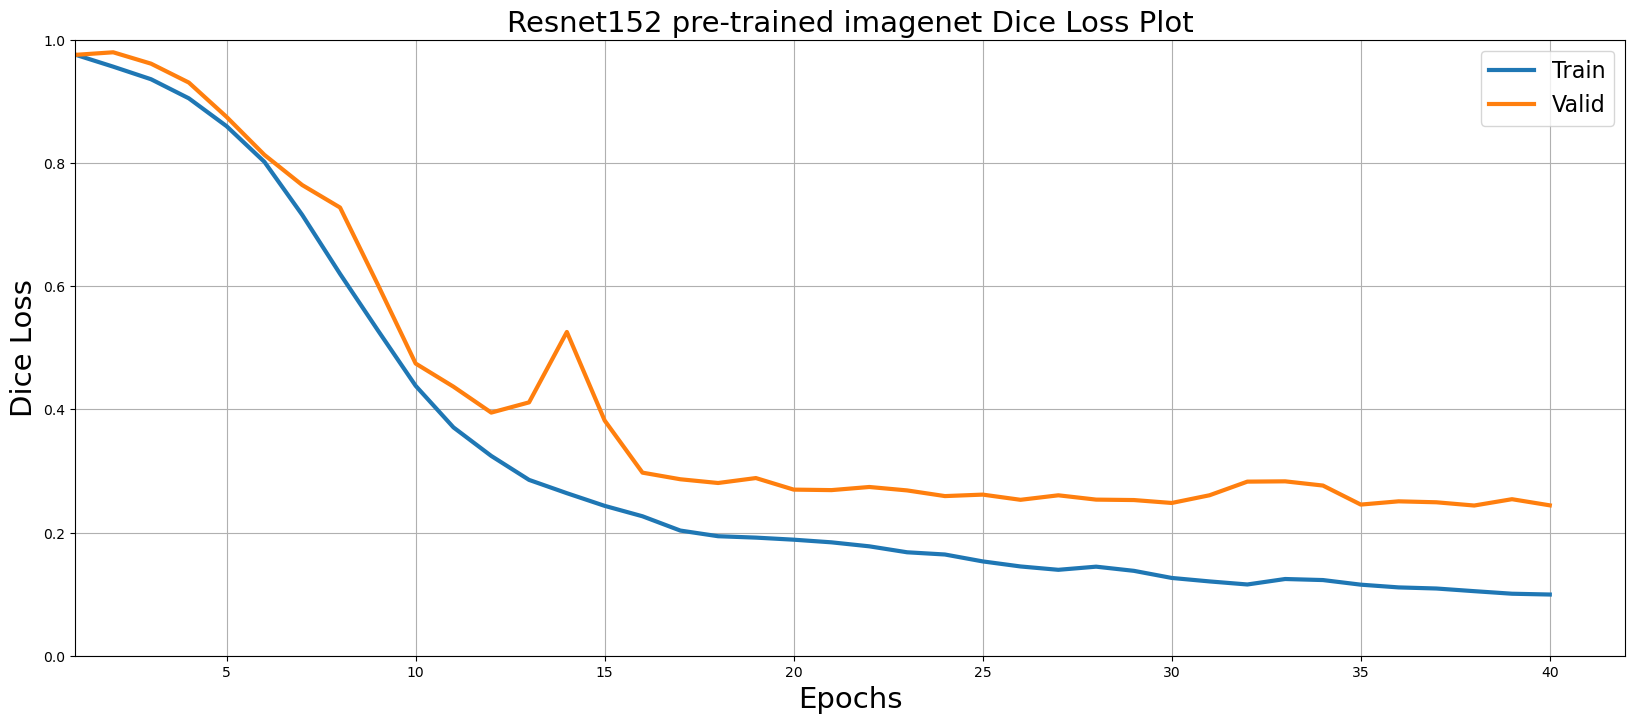

In [111]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)


plot_train_scores(train_logs_df, valid_logs_df, "Dice_loss", "Dice Loss", "Resnet152 pre-trained imagenet Dice Loss")

We can see that the "stronger" model does not mean it's the best model. With 58M parameters, the model has obviously over-fitted itself. 
In fact, from epoch ~20, we see no improvement in the validation loss.

In [112]:
trained_pt_resnet152_best_model = load_current_best_model(DEVICE)
trained_pt_resnet152_model_test_logs = test_model(trained_pt_resnet152_best_model, test_dataloader)
insert_model_test(model_test=ModelTest("PT Resnet152 imagenet + trained OCT ", "Resnet152 imagenet+OCT", trained_pt_resnet152_model_test_logs['Dice_loss'], "Pre-trained resnet152 which was pre-trained on imagenet data, and later was trained on OCT data."))
print("Dice loss for test dataset with trained pt resnet152 model: {:.3f}".format(trained_pt_resnet152_model_test_logs['Dice_loss']))

valid: 100%|██████████| 202/202 [00:12<00:00, 15.72it/s, Dice_loss - 0.3131, recall - 0.7436, precision - 0.8447]
Dice loss for test dataset with trained pt resnet152 model: 0.313


Now, using the smp library, we can choose a different model architecture. Instead of our well-known U-Net, we will now use DeepLabV3.
DeepLabV3 is an advanced segmentation model, that has achieved state-of-the-art performance on several popular semantic segmentation benchmarks and is widely used in many real-world applications.

In [113]:
pt_deeplabv3_model = smp.DeepLabV3(
    encoder_name="efficientnet-b0",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=1,                      
    activation='sigmoid',
)
pt_deeplabv3_model = pt_deeplabv3_model.double()
pt_deeplabv3_model = pt_deeplabv3_model.to(DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

We have learned from the past and will train the model right away.

In [114]:
train_logs_list, valid_logs_list = train(pt_deeplabv3_model, train_dataloader, val_dataloader, epochs=EPOCHS, verbose=False)


Epoch: 1
Dice loss of 0.988
This is a new best model!

Epoch: 2
Dice loss of 0.987
This is a new best model!

Epoch: 3
Dice loss of 0.974
This is a new best model!

Epoch: 4
Dice loss of 0.964
This is a new best model!

Epoch: 5
Dice loss of 0.985

Epoch: 6
Dice loss of 0.926
This is a new best model!

Epoch: 7
Dice loss of 0.881
This is a new best model!

Epoch: 8
Dice loss of 0.965

Epoch: 9
Dice loss of 0.954

Epoch: 10
Dice loss of 0.970

Epoch: 11
Dice loss of 0.922

Epoch: 12
Dice loss of 0.882

Epoch: 13
Dice loss of 0.945

Epoch: 14
Dice loss of 0.944

Epoch: 15
Dice loss of 0.890

Epoch: 16
Dice loss of 0.892

Epoch: 17
Dice loss of 0.918

Epoch: 18
Dice loss of 0.881
This is a new best model!

Epoch: 19
Dice loss of 0.890

Epoch: 20
Dice loss of 0.883

Epoch: 21
Dice loss of 0.903

Epoch: 22
Dice loss of 0.870
This is a new best model!

Epoch: 23
Dice loss of 0.828
This is a new best model!

Epoch: 24
Dice loss of 0.799
This is a new best model!

Epoch: 25
Dice loss of 0.831

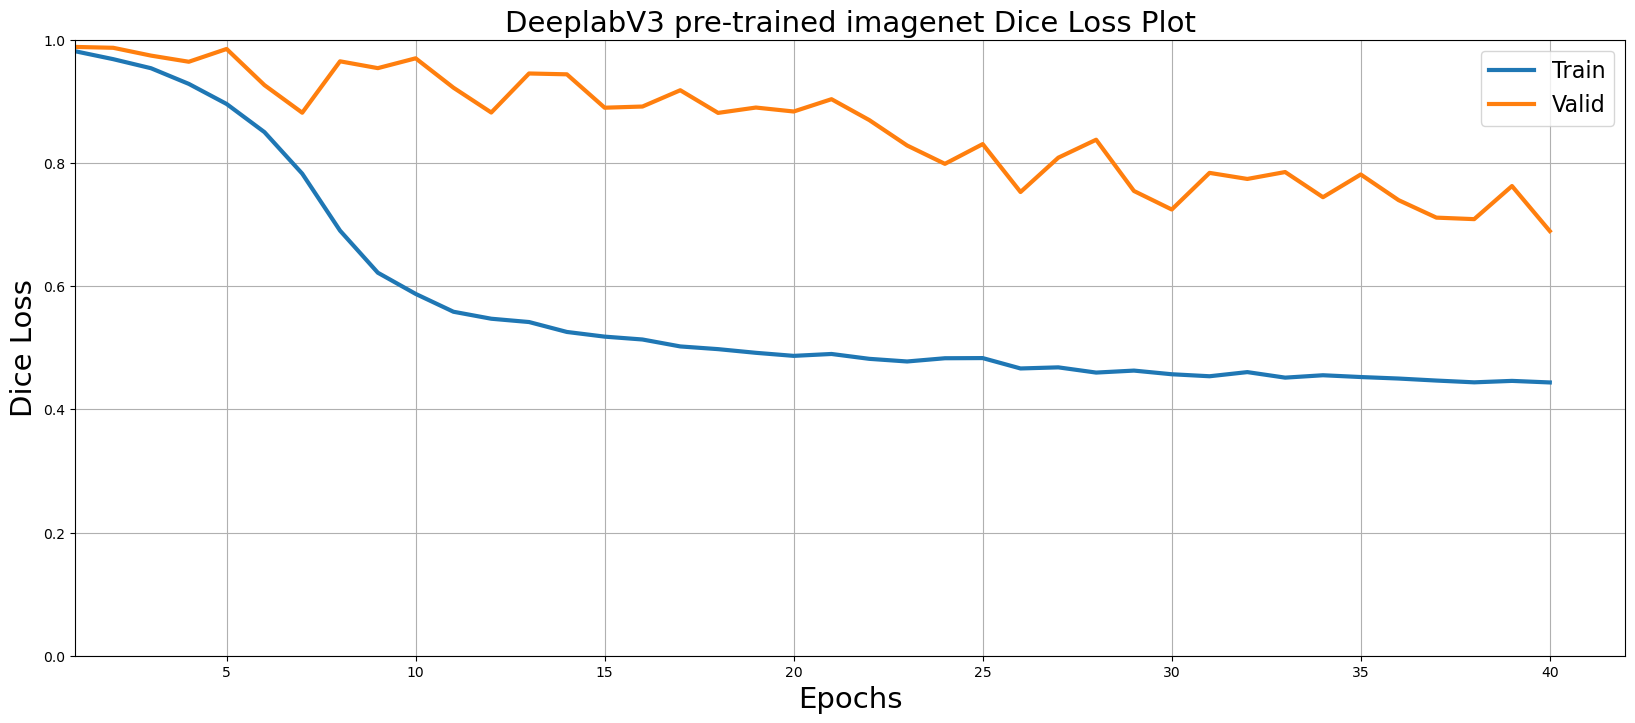

In [115]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
pt_deeplabv3_train_logs = train_logs_df
pt_deeplabv3_val_logs = valid_logs_df
plot_train_scores(pt_deeplabv3_train_logs, pt_deeplabv3_val_logs, "Dice_loss", "Dice Loss", "DeeplabV3 pre-trained imagenet Dice Loss")

In [116]:
pt_deeplabv3_best_model = load_current_best_model(DEVICE)
pt_deeplabv3_model_test_logs = test_model(pt_deeplabv3_best_model, test_dataloader)
insert_model_test(model_test=ModelTest("PT DeeplabV3 imagenet + trained OCT", "DeeplabV3 imagenet+OCT", pt_deeplabv3_model_test_logs['Dice_loss'], "Pre-trained DeeplabV3 which was trained on imagenet data, and was not trained on OCT data."))
print("Dice loss for test dataset with deeplabv3_model model: {:.3f}".format(pt_deeplabv3_model_test_logs['Dice_loss']))

valid: 100%|██████████| 202/202 [00:03<00:00, 52.19it/s, Dice_loss - 0.8638, recall - 0.4899, precision - 1.265]
Dice loss for test dataset with deeplabv3_model model: 0.864


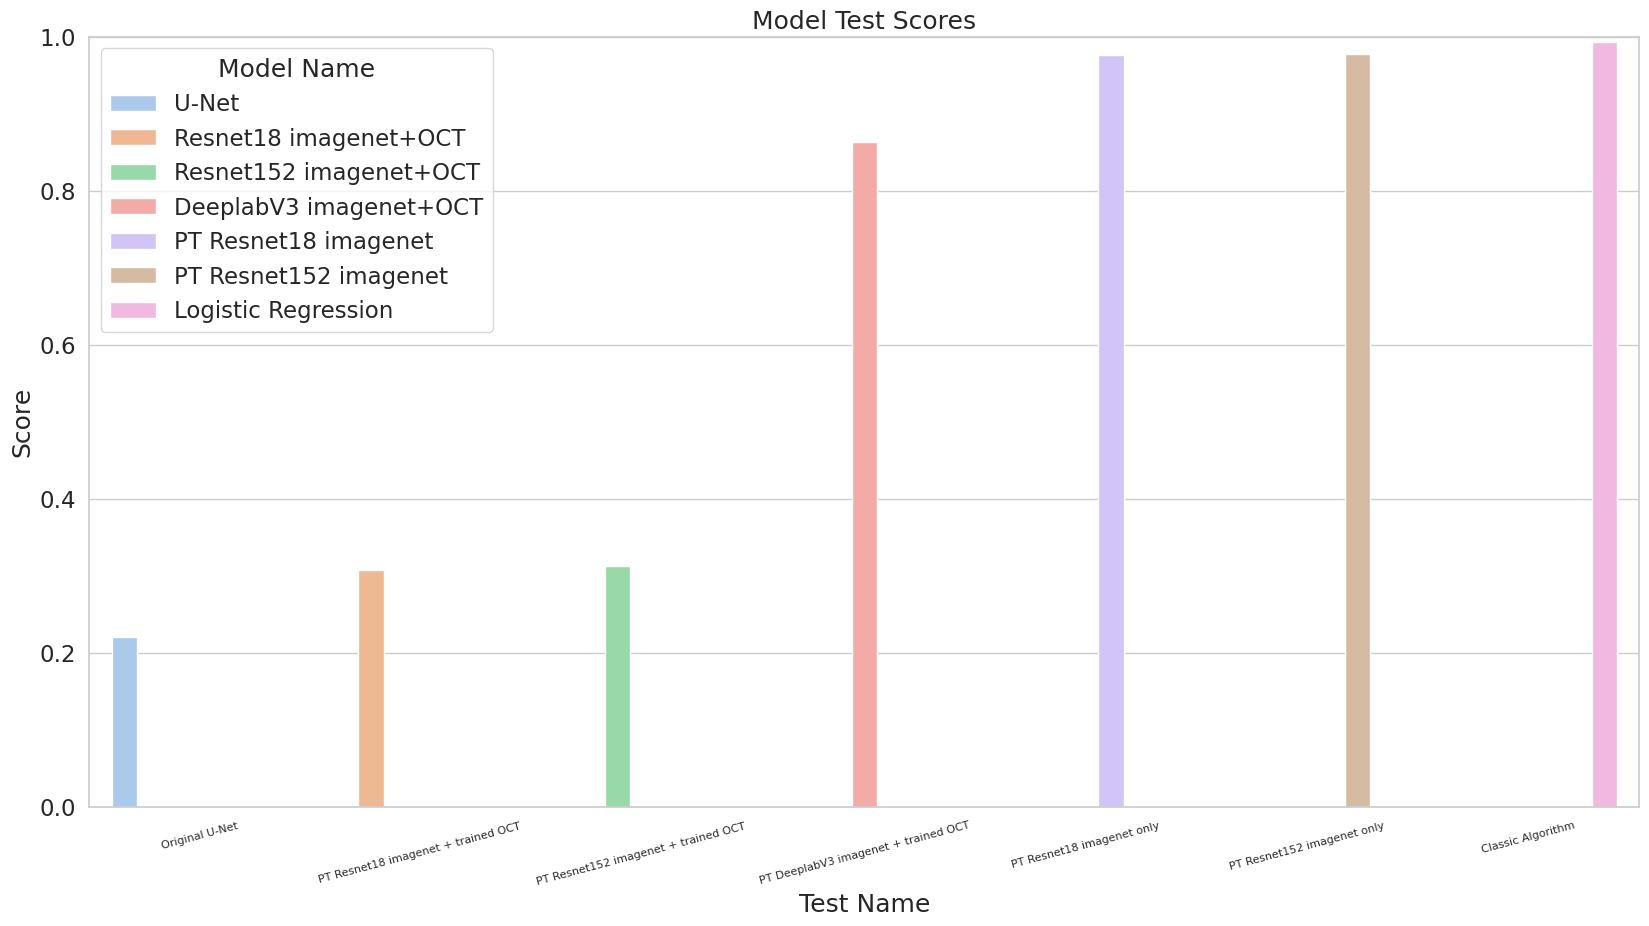

In [117]:
visualize_models_tests_scores()

We observe that the results are not so good. The model can't seem to generalize well, and can't get good results even on the training dataset. The model architecture should be state-of-the-art. Maybe using pre-trained on imagenet only harms. Let's check that theory by training a DeepLabV3 model, which was not pre-trained.

In [118]:
deeplabv3_model_fresh = smp.DeepLabV3(
    in_channels=3,                  
    classes=1,                     
    activation='sigmoid',
)
deeplabv3_model_fresh = deeplabv3_model_fresh.double()
deeplabv3_model_fresh = deeplabv3_model_fresh.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [119]:
train_logs_list, valid_logs_list = train(deeplabv3_model_fresh, train_dataloader, val_dataloader, epochs=EPOCHS, verbose=False)


Epoch: 1
Dice loss of 0.981
This is a new best model!

Epoch: 2
Dice loss of 0.942
This is a new best model!

Epoch: 3
Dice loss of 0.887
This is a new best model!

Epoch: 4
Dice loss of 0.865
This is a new best model!

Epoch: 5
Dice loss of 0.816
This is a new best model!

Epoch: 6
Dice loss of 0.764
This is a new best model!

Epoch: 7
Dice loss of 0.726
This is a new best model!

Epoch: 8
Dice loss of 0.686
This is a new best model!

Epoch: 9
Dice loss of 0.657
This is a new best model!

Epoch: 10
Dice loss of 0.640
This is a new best model!

Epoch: 11
Dice loss of 0.611
This is a new best model!

Epoch: 12
Dice loss of 0.591
This is a new best model!

Epoch: 13
Dice loss of 0.601

Epoch: 14
Dice loss of 0.601

Epoch: 15
Dice loss of 0.585
This is a new best model!

Epoch: 16
Dice loss of 0.576
This is a new best model!

Epoch: 17
Dice loss of 0.580

Epoch: 18
Dice loss of 0.565
This is a new best model!

Epoch: 19
Dice loss of 0.566

Epoch: 20
Dice loss of 0.626

Epoch: 21
Dice los

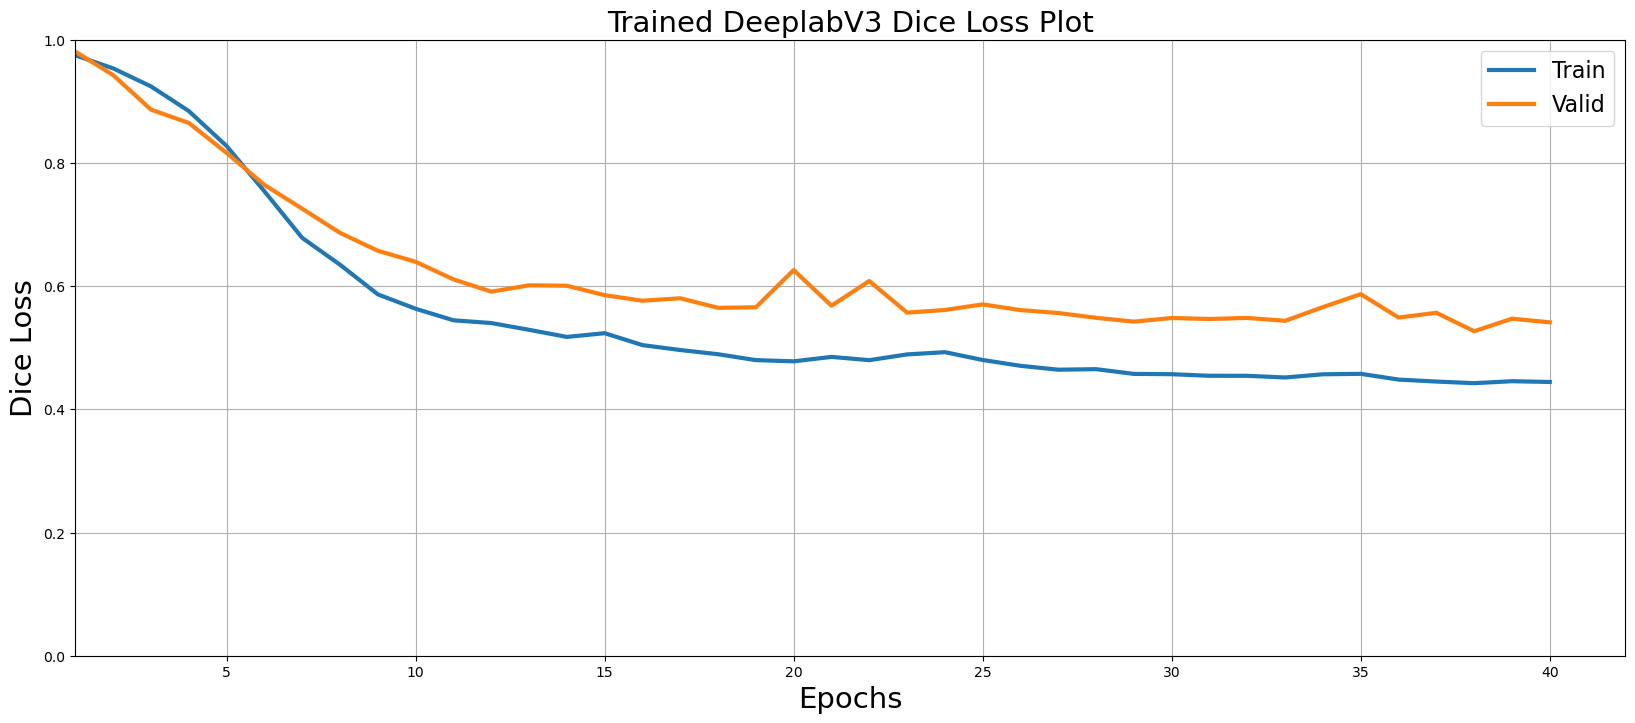

In [120]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
deeplabv3_train_logs = train_logs_df
deeplabv3_val_logs = valid_logs_df

plot_train_scores(train_logs_df, valid_logs_df, "Dice_loss", "Dice Loss", "Trained DeeplabV3 Dice Loss")

In [121]:
deeplabv3_fresh_best_model = load_current_best_model(DEVICE)
deeplabv3_fresh_model_test_logs = test_model(deeplabv3_fresh_best_model, test_dataloader)
insert_model_test(model_test=ModelTest("DeeplabV3 OCT", "DeeplabV3 OCT", deeplabv3_fresh_model_test_logs['Dice_loss'], "DeeplabV3 which was trained on OCT data only, from the start."))
print("Dice loss for test dataset with fresh deeplabv3_model model: {:.3f}".format(deeplabv3_fresh_model_test_logs['Dice_loss']))

valid: 100%|██████████| 202/202 [00:05<00:00, 38.28it/s, Dice_loss - 0.7425, recall - 0.9588, precision - 1.147] 
Dice loss for test dataset with fresh deeplabv3_model model: 0.742


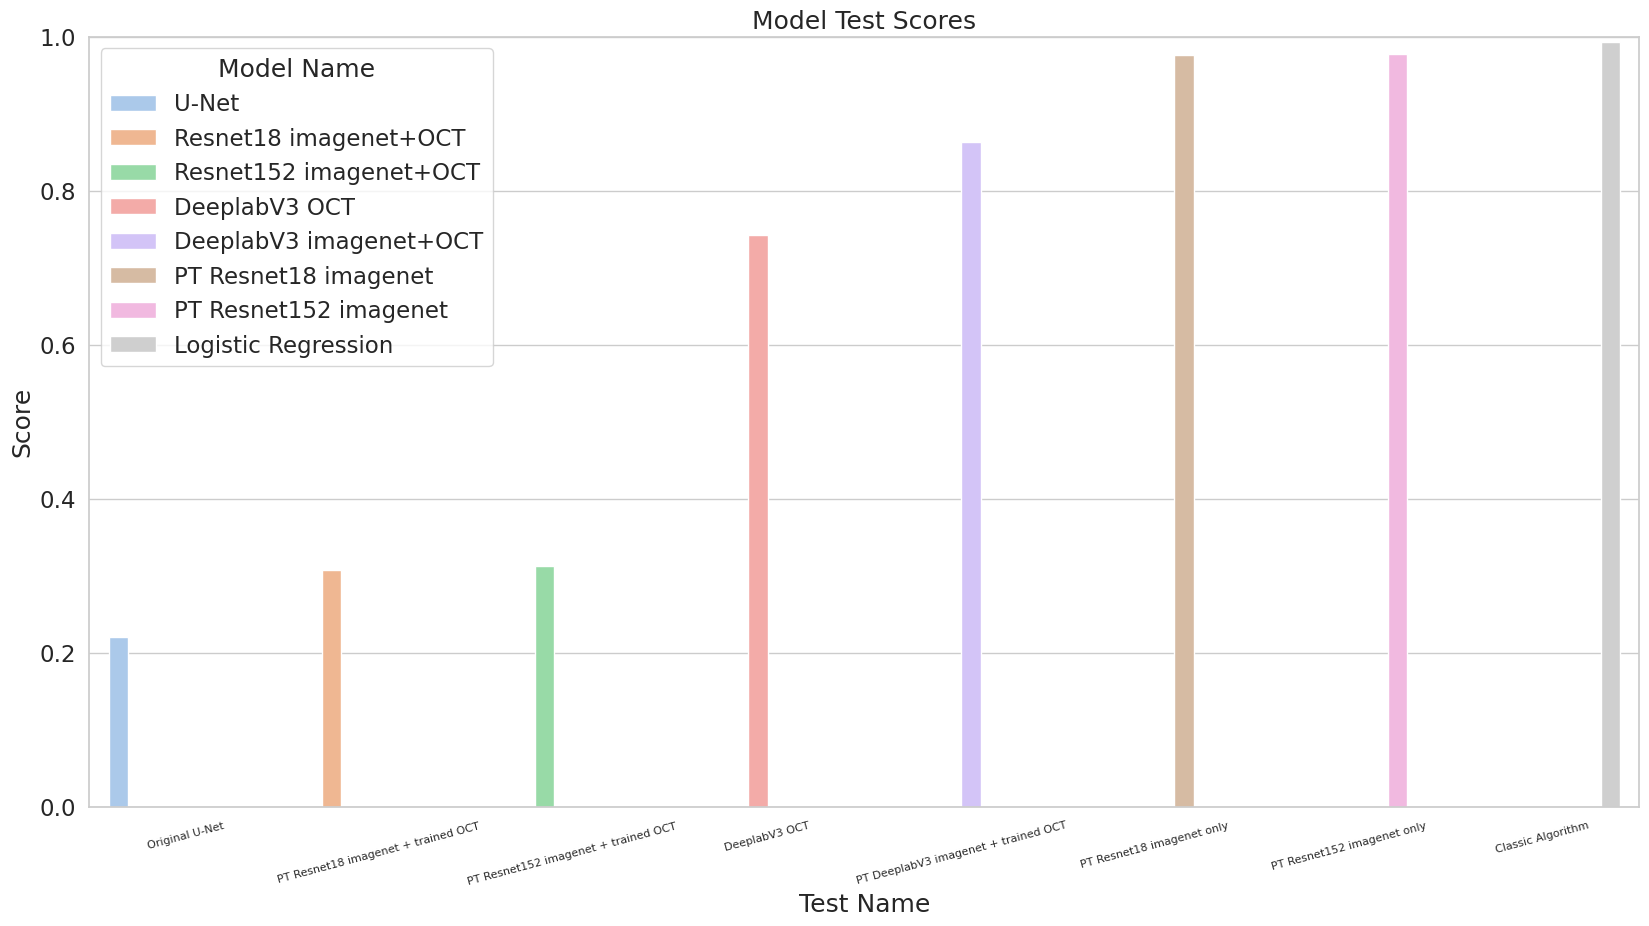

In [122]:
visualize_models_tests_scores()

We can indeed see that using a "fresh" model that was not pre-trained, does indeed beat our last try, but the results are still not satisfying. Using a pre-trained model still sounded like a good idea to us, and we thought about how can we harness the pre-trained strength to improve our results. We came to the conclusion that we do not need to train the whole pre-trained model again: we just need to train the decoder and use the pre-trained encoder weights as is.

In [123]:
clean_memory()

### 4.7.2. Fine Tuning Advanced Models

Firstly, we create two functions to freeze and to un-freeze the encoder. This is essential to our fine-tuning: before training the model, we will freeze the encoder, so the encoder weights will not be changed during the training process.

In [124]:
def freeze_encoder(model):
    for child in model.encoder.children():
        for param in child.parameters():
            param.requires_grad = False
    return

def unfreeze(model):
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = True
    return

Next, we will create a pre-trained Unet with resnet152 encoder.

In [125]:
pt_resnet152_model = smp.Unet(
    encoder_name="resnet152",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    activation='sigmoid',
)
pt_resnet152_model = pt_resnet152_model
pt_resnet152_model = pt_resnet152_model.to(DEVICE)

Using the summary function, we can view our model layers and parameters.

In [126]:
summary(pt_resnet152_model, input_size=(100, 3, 64, 64))

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [100, 1, 64, 64]          --
├─ResNetEncoder: 1-1                          [100, 3, 64, 64]          --
│    └─Conv2d: 2-1                            [100, 64, 32, 32]         9,408
│    └─BatchNorm2d: 2-2                       [100, 64, 32, 32]         128
│    └─ReLU: 2-3                              [100, 64, 32, 32]         --
│    └─MaxPool2d: 2-4                         [100, 64, 16, 16]         --
│    └─Sequential: 2-5                        [100, 256, 16, 16]        --
│    │    └─Bottleneck: 3-1                   [100, 256, 16, 16]        75,008
│    │    └─Bottleneck: 3-2                   [100, 256, 16, 16]        70,400
│    │    └─Bottleneck: 3-3                   [100, 256, 16, 16]        70,400
│    └─Sequential: 2-6                        [100, 512, 8, 8]          --
│    │    └─Bottleneck: 3-4                   [100, 512, 8, 8]          379,392

We can see that the number of trainable parameters is high - 67M.  
Now, we will freeze our encoder, and print a summary again.

In [127]:
freeze_encoder(pt_resnet152_model)
summary(pt_resnet152_model, input_size=(100, 3, 64, 64))

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [100, 1, 64, 64]          --
├─ResNetEncoder: 1-1                          [100, 3, 64, 64]          --
│    └─Conv2d: 2-1                            [100, 64, 32, 32]         (9,408)
│    └─BatchNorm2d: 2-2                       [100, 64, 32, 32]         (128)
│    └─ReLU: 2-3                              [100, 64, 32, 32]         --
│    └─MaxPool2d: 2-4                         [100, 64, 16, 16]         --
│    └─Sequential: 2-5                        [100, 256, 16, 16]        --
│    │    └─Bottleneck: 3-1                   [100, 256, 16, 16]        (75,008)
│    │    └─Bottleneck: 3-2                   [100, 256, 16, 16]        (70,400)
│    │    └─Bottleneck: 3-3                   [100, 256, 16, 16]        (70,400)
│    └─Sequential: 2-6                        [100, 512, 8, 8]          --
│    │    └─Bottleneck: 3-4                   [100, 512, 8, 8]       

We can see the number of trainable parameters is substantially decreased: from 67M parameters, to merely 9M. 
Now, let's try and train the frozen pre-trained resnet152 model.

In [128]:
pt_resnet152_model = pt_resnet152_model.double()
train_logs_list, valid_logs_list = train(pt_resnet152_model, train_dataloader, val_dataloader, epochs=EPOCHS, verbose=False)


Epoch: 1
Dice loss of 0.988
This is a new best model!

Epoch: 2
Dice loss of 0.983
This is a new best model!

Epoch: 3
Dice loss of 0.957
This is a new best model!

Epoch: 4
Dice loss of 0.944
This is a new best model!

Epoch: 5
Dice loss of 0.933
This is a new best model!

Epoch: 6
Dice loss of 0.903
This is a new best model!

Epoch: 7
Dice loss of 0.862
This is a new best model!

Epoch: 8
Dice loss of 0.820
This is a new best model!

Epoch: 9
Dice loss of 0.728
This is a new best model!

Epoch: 10
Dice loss of 0.625
This is a new best model!

Epoch: 11
Dice loss of 0.598
This is a new best model!

Epoch: 12
Dice loss of 0.485
This is a new best model!

Epoch: 13
Dice loss of 0.432
This is a new best model!

Epoch: 14
Dice loss of 0.396
This is a new best model!

Epoch: 15
Dice loss of 0.384
This is a new best model!

Epoch: 16
Dice loss of 0.328
This is a new best model!

Epoch: 17
Dice loss of 0.352

Epoch: 18
Dice loss of 0.310
This is a new best model!

Epoch: 19
Dice loss of 0.3

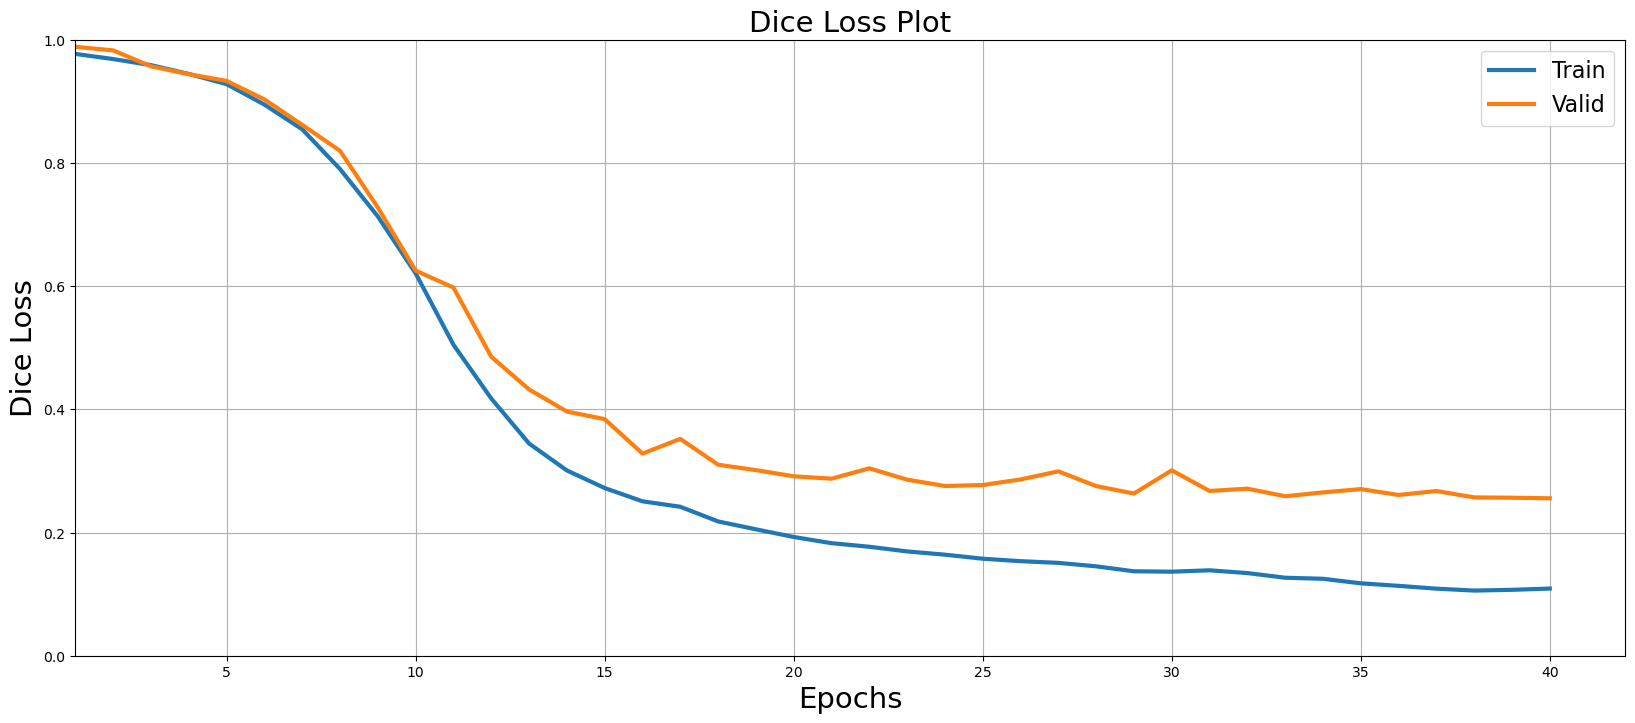

In [129]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list) 
resnet152_train_logs = train_logs_df
resnet152_val_logs = valid_logs_df

plot_train_scores(train_logs_df, valid_logs_df, "Dice_loss", "Dice Loss")

The model doesn't seem to generalize well. Let's add some drouput layers to avoid overfitting. We will add the drouput layers to the decoder only, because the encoder is staying frozen (fine tuning). The dropout "drop" value is set to 0.1, after some trial and error we have done.

In [130]:
for name, module in pt_resnet152_model.named_modules():
    if "conv" in name and "decoder" in name and "dropout" not in name:
        module.add_module("dropout", nn.Dropout2d(p=0.1))

Now, armed with the powerfull U-Net model with reset152 as a pre-trained forzen-encoder and some dropouts layers to avoid overfitting, let's fine-tune the model and train it.

In [131]:
pt_resnet152_model = pt_resnet152_model.double()
train_logs_list, valid_logs_list = train(pt_resnet152_model, train_dataloader, val_dataloader, epochs=EPOCHS, verbose=False)


Epoch: 1
Dice loss of 0.287
This is a new best model!

Epoch: 2
Dice loss of 0.280
This is a new best model!

Epoch: 3
Dice loss of 0.274
This is a new best model!

Epoch: 4
Dice loss of 0.263
This is a new best model!

Epoch: 5
Dice loss of 0.264

Epoch: 6
Dice loss of 0.268

Epoch: 7
Dice loss of 0.262
This is a new best model!

Epoch: 8
Dice loss of 0.260
This is a new best model!

Epoch: 9
Dice loss of 0.265

Epoch: 10
Dice loss of 0.261

Epoch: 11
Dice loss of 0.259
This is a new best model!

Epoch: 12
Dice loss of 0.254
This is a new best model!

Epoch: 13
Dice loss of 0.253
This is a new best model!

Epoch: 14
Dice loss of 0.253

Epoch: 15
Dice loss of 0.255

Epoch: 16
Dice loss of 0.255

Epoch: 17
Dice loss of 0.250
This is a new best model!

Epoch: 18
Dice loss of 0.253

Epoch: 19
Dice loss of 0.253

Epoch: 20
Dice loss of 0.247
This is a new best model!

Epoch: 21
Dice loss of 0.256

Epoch: 22
Dice loss of 0.245
This is a new best model!

Epoch: 23
Dice loss of 0.243
This is

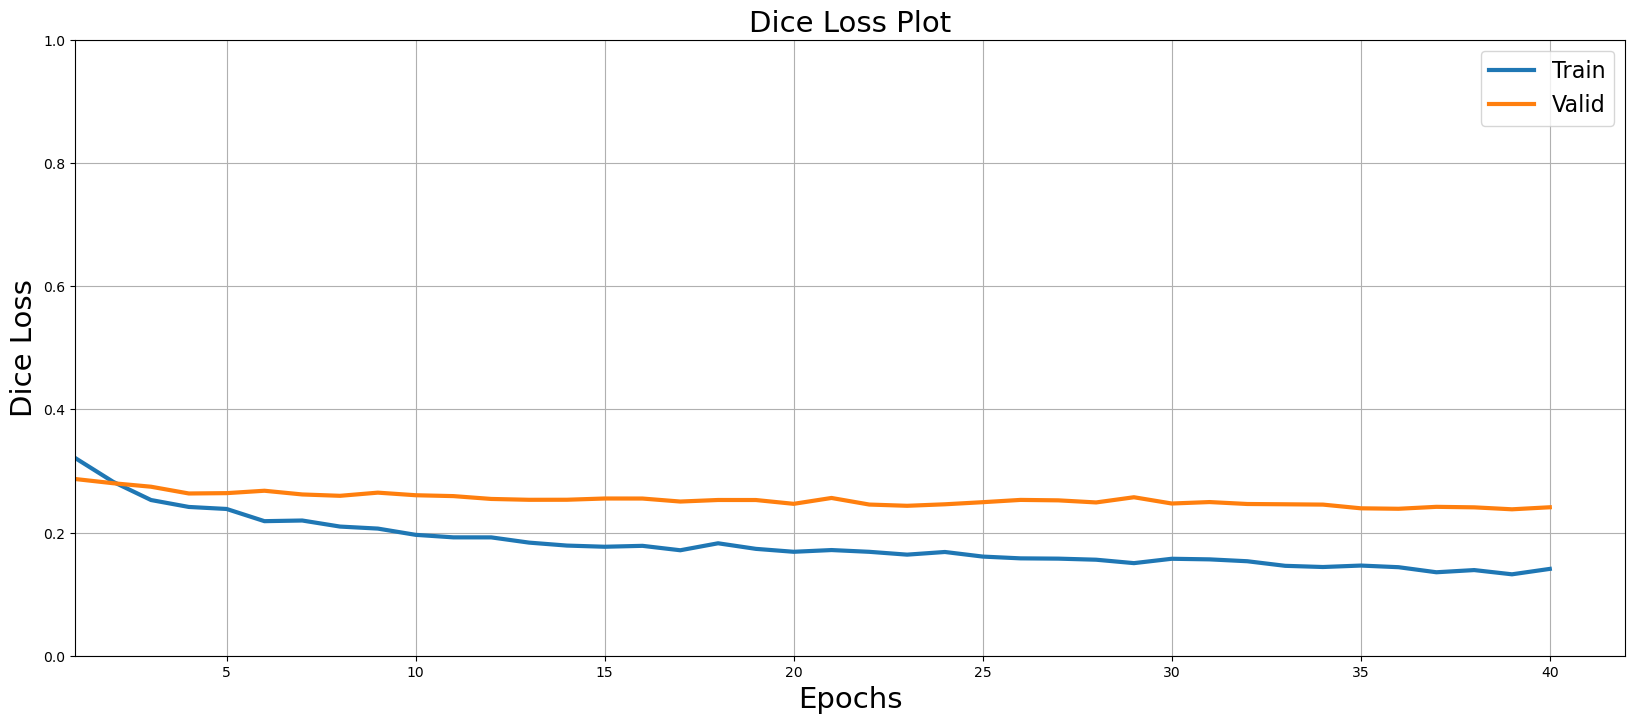

In [132]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
resnet152_train_logs = train_logs_df
resnet152_val_logs = valid_logs_df

plot_train_scores(train_logs_df, valid_logs_df, "Dice_loss", "Dice Loss")

In [133]:
ft_resnet152_best_model = load_current_best_model(DEVICE)
ft_resnet152_model_test_logs = test_model(ft_resnet152_best_model, test_dataloader)
insert_model_test(model_test=ModelTest("Fine tuned Resnet152 ", "Fine tuned Resnet152 imagenet+OCT", ft_resnet152_model_test_logs['Dice_loss'], "Pre-trained resnet152 which was pre-trained on imagenet data, and later was trained on OCT data."))
print("Dice loss for test dataset with fine tuned resnet152 model: {}".format(ft_resnet152_model_test_logs['Dice_loss']))

valid: 100%|██████████| 202/202 [00:12<00:00, 15.72it/s, Dice_loss - 0.2834, recall - 0.7704, precision - 0.821] 
Dice loss for test dataset with fine tuned resnet152 model: 0.2833550075442916


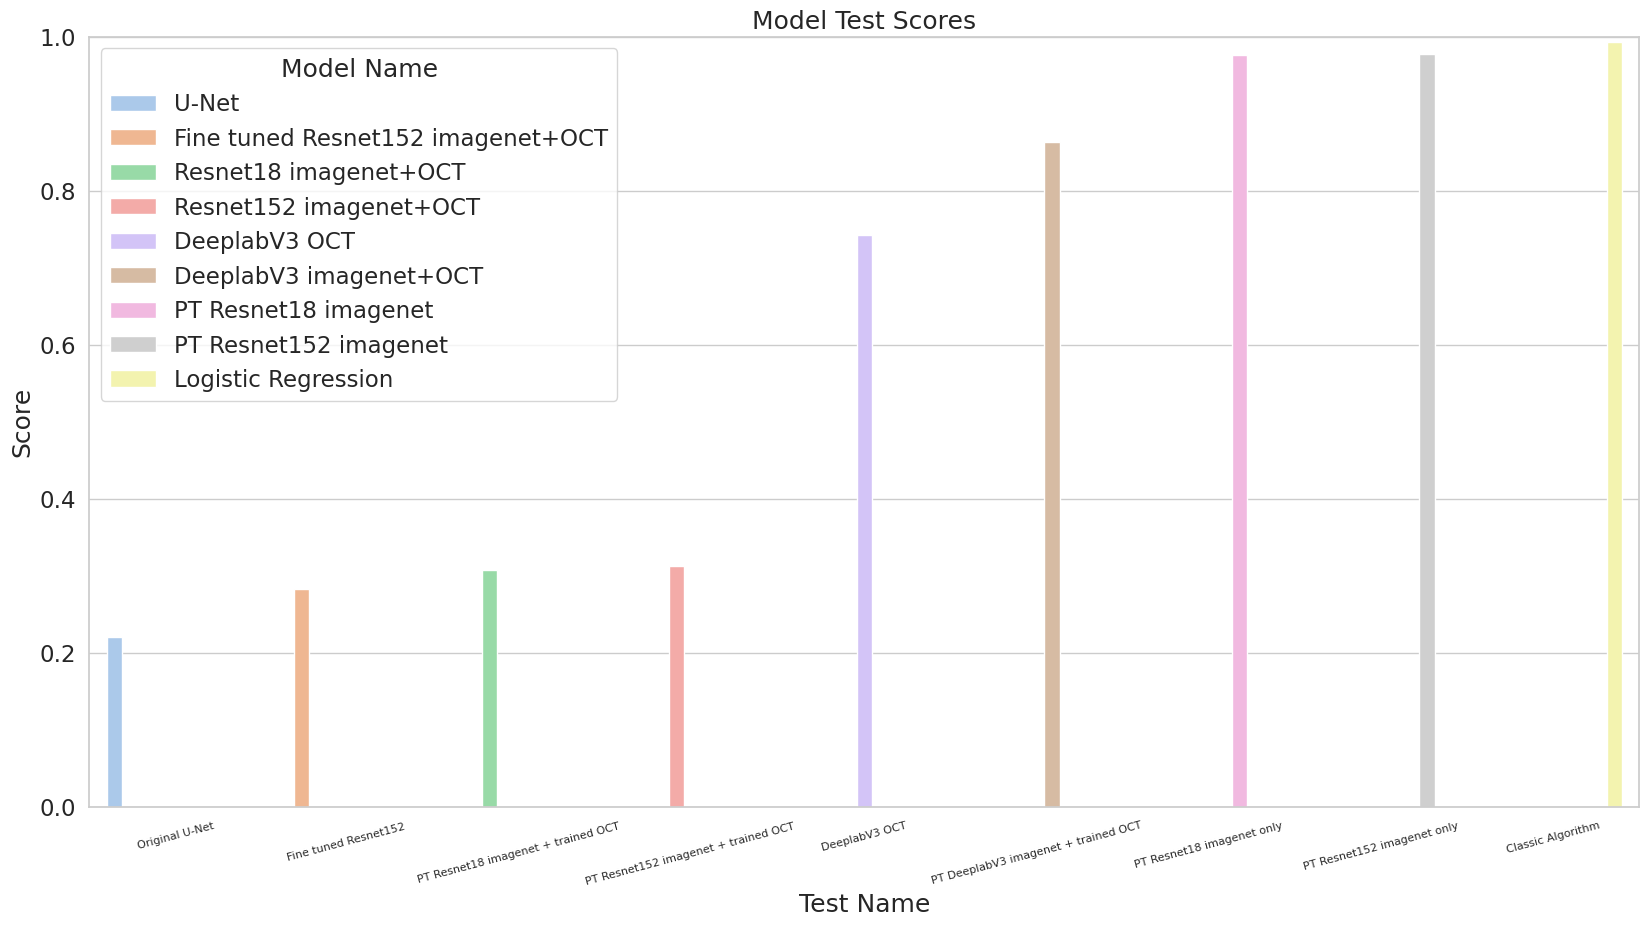

In [134]:
visualize_models_tests_scores()

The results are indeed better when the model is fine-tuned, rather than trained with all of the weights.   
Another effective way of dealing with over-fitting, among many possible solutions, is using the early stop mechanism. The idea behind the mechanism is basic but effective: interrupting the training process before the model's performance on a validation set starts to decline. This is done by monitoring the performance of the model on the validation set during training and stopping the training process when the performance stops improving or starts to degrade, after X epochs.

So, same as before, we will create a pre-trained U-Net model with pre-trained Resnet152 as an encoder. We will once again freeze the encoder as part of the fine-tuning. This time, we will use the early stopping mechanism.

In [135]:
pt_resnet152_model = smp.Unet(
    encoder_name="resnet152",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    activation='sigmoid',
)
pt_resnet152_model = pt_resnet152_model
pt_resnet152_model = pt_resnet152_model.to(DEVICE)
freeze_encoder(pt_resnet152_model)

The early stopping code is taken from the github repository: https://github.com/Bjarten/early-stopping-pytorch  
The github repository holds a python package, but it is old and did not work with our dependencies. We made few minor changes to the class. 

In [136]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path=None, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str or None): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). ')
        self.val_loss_min = val_loss

Now, we will re-define our training process, incorporating the early stopping mechanism.

In [137]:
def train(model, train_dataloader, val_dataloader, epochs = 10, patience=10, verbose=False):
    loss, metrics, optimizer = get_run_configs(model)
    train_epoch = get_train_epoch(model, loss, metrics, optimizer, DEVICE, verbose)
    valid_epoch = get_val_epoch(model, loss, metrics, optimizer, DEVICE, verbose)
    
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    best_dice_loss = 1.0
    train_logs_list, valid_logs_list = [], []

    for current_epoch in range(1, epochs+1):

        print('\nEpoch: {}'.format(current_epoch))
        train_logs = train_epoch.run(train_dataloader)
        valid_logs = valid_epoch.run(val_dataloader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        print('Dice loss of {:.3f}'.format(valid_logs['Dice_loss']))
        if valid_logs['Dice_loss'] < best_dice_loss:
            best_dice_loss = valid_logs['Dice_loss']
            print('This is a new best model!')
            torch.save(model, './best_model.pth')
                
                
        early_stopping(valid_logs['Dice_loss'], model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

    
    return train_logs_list, valid_logs_list

In [138]:
pt_resnet152_model = pt_resnet152_model.double()
train_logs_list, valid_logs_list = train(pt_resnet152_model, train_dataloader, val_dataloader, epochs=EPOCHS, verbose=False)


Epoch: 1
Dice loss of 0.984
This is a new best model!
Validation loss decreased (inf --> 0.983732). 

Epoch: 2
Dice loss of 0.968
This is a new best model!
Validation loss decreased (0.983732 --> 0.968155). 

Epoch: 3
Dice loss of 0.972

Epoch: 4
Dice loss of 0.941
This is a new best model!
Validation loss decreased (0.968155 --> 0.940561). 

Epoch: 5
Dice loss of 0.902
This is a new best model!
Validation loss decreased (0.940561 --> 0.902435). 

Epoch: 6
Dice loss of 0.853
This is a new best model!
Validation loss decreased (0.902435 --> 0.852657). 

Epoch: 7
Dice loss of 0.810
This is a new best model!
Validation loss decreased (0.852657 --> 0.810133). 

Epoch: 8
Dice loss of 0.728
This is a new best model!
Validation loss decreased (0.810133 --> 0.727667). 

Epoch: 9
Dice loss of 0.616
This is a new best model!
Validation loss decreased (0.727667 --> 0.616150). 

Epoch: 10
Dice loss of 0.521
This is a new best model!
Validation loss decreased (0.616150 --> 0.521418). 

Epoch: 11
D

We will modify the plot train scores function, to add a mark for the early stop.

In [139]:
def plot_train_scores(train_logs_df, valid_logs_df, metric_name, metric_display_name, title=None):
    if title is None:
        title = metric_display_name
    plt.figure(figsize=(20,8))
    train_indices = [x+1 for x in train_logs_df.index.tolist()]
    val_indices = [x+1 for x in valid_logs_df.index.tolist()]
    plt.plot(train_indices, train_logs_df[metric_name].tolist(), lw=3, label = 'Train')
    plt.plot(val_indices, valid_logs_df[metric_name].tolist(), lw=3, label = 'Valid')
    
    plt.xlabel('Epochs', fontsize=21)
    plt.ylabel('{}'.format(metric_display_name), fontsize=21)
    plt.title('{} Plot'.format(title), fontsize=21)
    
    min_pos = valid_logs_df[metric_name].idxmin()+1
    plt.axvline(min_pos, linestyle='--', color='r',label='Early Stopping Checkpoint')
         
    plt.ylim(0, 1)
    plt.xlim(1, len(train_indices)+2)
    
    plt.legend(loc='best', fontsize=16)
    plt.grid()
    plt.savefig('{}_plot.png'.format(metric_name))
    plt.show()

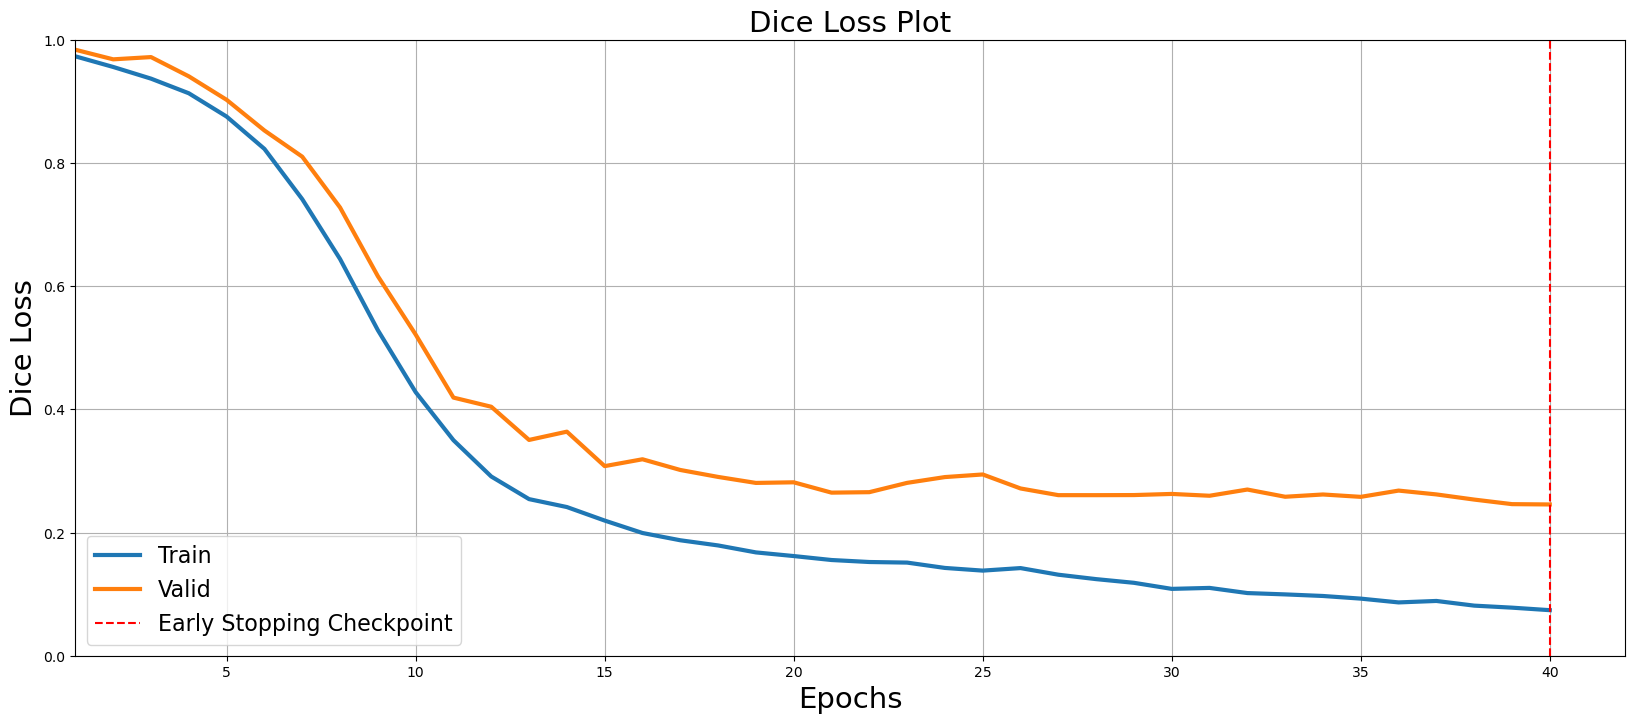

In [140]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
resnet152_train_logs = train_logs_df
resnet152_val_logs = valid_logs_df

plot_train_scores(train_logs_df, valid_logs_df, "Dice_loss", "Dice Loss")

In [141]:
clean_memory()

## 4.8. Ensembling

## 4.8.1. U-Nets Ensembling

We will now try a different method, called ensembling. First, let's begin by explaining what ensembling is. Ensembling is the process of combining the predictions of multiple models in order to improve the overall performance. This is typically done by training multiple models independently, and then using some combination of their predictions at prediction time, such as calculating the average or majority vote. The idea behind ensembling is that by combining the predictions of multiple models, the overall performance can be made more robust and less sensitive to the specific initialization or training of any one model.  
We will begin by creating 4 U-Nets.  
We chose 4 and not more because of hardware constraints. We chose 4 and not less because the results were improved with more models, as we could expect. 

In [142]:
num_ensemble_models = 4
ensemble_models = []

for i in range(0, num_ensemble_models):
    unet = UNet(in_channels=3, out_channels=1)
    unet = unet.double()
    unet = unet.to(DEVICE)
    ensemble_models.append(unet)

Now, we want to select in a random manner X% (0<X<100) of the training data for each of the ensemble models to train on, for better robustness of the final output.
We will define a function that creates a dataloader with X% of the data from the original train dataloader.
Then, we will use those new dataloaders and train our ensemble models.

In [143]:
def create_random_subset_dataloader(original_dataloader, percentage):
    data_indices = list(range(len(original_dataloader.dataset)))
    
    random.shuffle(data_indices)
    num_data = int(len(data_indices) * percentage)
    
    subset_indices = data_indices[:num_data]
    subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)
    subset_dataloader = DataLoader(original_dataloader.dataset, sampler=subset_sampler, batch_size=original_dataloader.batch_size, drop_last=original_dataloader.drop_last)
    return subset_dataloader

For each ensemble model (a U-Net that's part of the ensembling models) we will create a dataloader containing 85% of the data, and train the model on the newly created dataloader. 85% was selected after many experiments we had. We will use 20 epochs, which gave us good results in the accuracy-gpu time trade-off.


Epoch: 1
Dice loss of 0.984
This is a new best model!
Validation loss decreased (inf --> 0.984390). 

Epoch: 2
Dice loss of 0.963
This is a new best model!
Validation loss decreased (0.984390 --> 0.963285). 

Epoch: 3
Dice loss of 0.691
This is a new best model!
Validation loss decreased (0.963285 --> 0.690890). 

Epoch: 4
Dice loss of 0.668
This is a new best model!
Validation loss decreased (0.690890 --> 0.668015). 

Epoch: 5
Dice loss of 0.567
This is a new best model!
Validation loss decreased (0.668015 --> 0.567205). 

Epoch: 6
Dice loss of 0.510
This is a new best model!
Validation loss decreased (0.567205 --> 0.509727). 

Epoch: 7
Dice loss of 0.478
This is a new best model!
Validation loss decreased (0.509727 --> 0.478348). 

Epoch: 8
Dice loss of 0.436
This is a new best model!
Validation loss decreased (0.478348 --> 0.435847). 

Epoch: 9
Dice loss of 0.393
This is a new best model!
Validation loss decreased (0.435847 --> 0.392954). 

Epoch: 10
Dice loss of 0.371
This is a ne

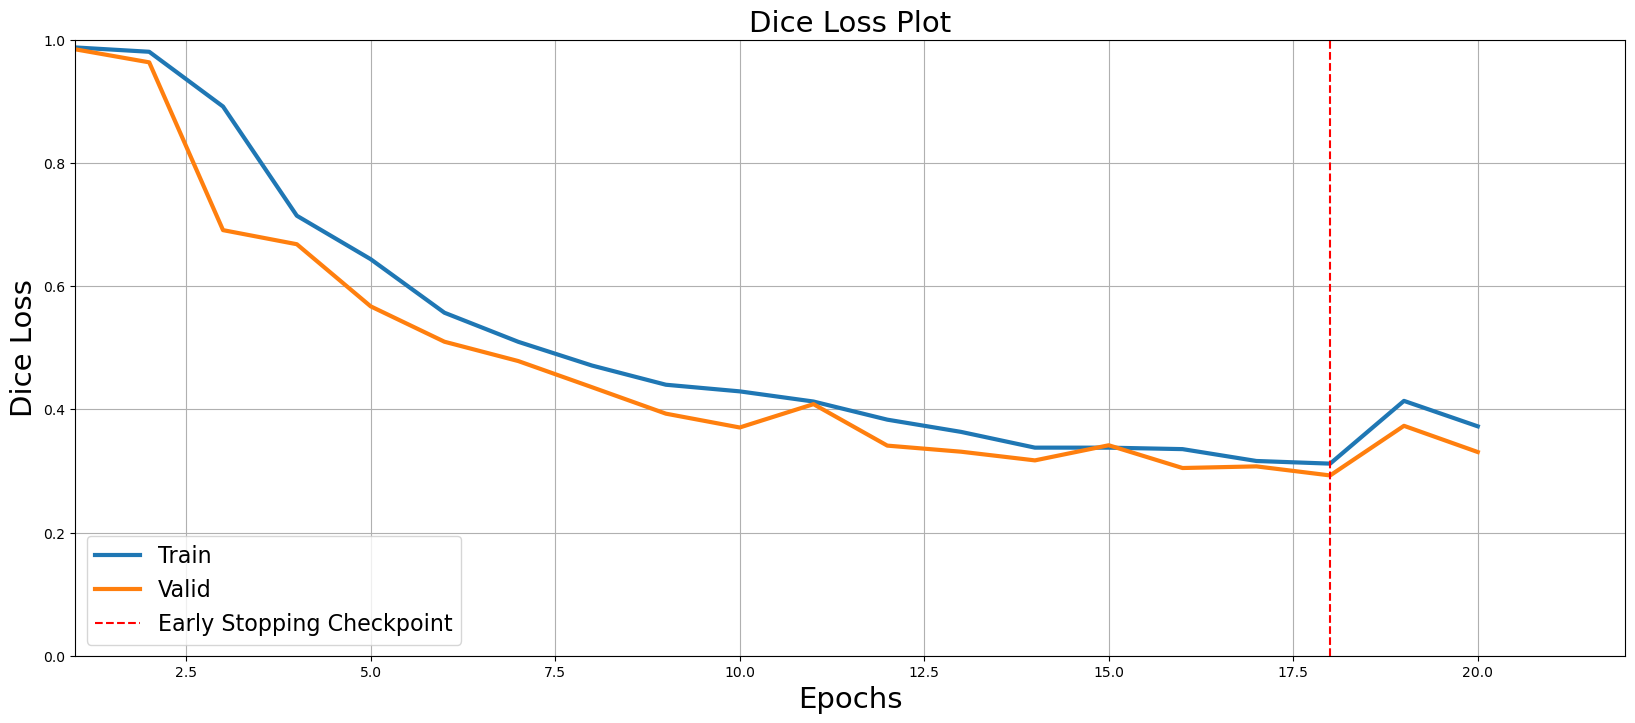


Epoch: 1
Dice loss of 0.976
This is a new best model!
Validation loss decreased (inf --> 0.975630). 

Epoch: 2
Dice loss of 0.929
This is a new best model!
Validation loss decreased (0.975630 --> 0.929119). 

Epoch: 3
Dice loss of 0.704
This is a new best model!
Validation loss decreased (0.929119 --> 0.704013). 

Epoch: 4
Dice loss of 0.557
This is a new best model!
Validation loss decreased (0.704013 --> 0.557172). 

Epoch: 5
Dice loss of 0.497
This is a new best model!
Validation loss decreased (0.557172 --> 0.497260). 

Epoch: 6
Dice loss of 0.472
This is a new best model!
Validation loss decreased (0.497260 --> 0.472069). 

Epoch: 7
Dice loss of 0.460
This is a new best model!
Validation loss decreased (0.472069 --> 0.459535). 

Epoch: 8
Dice loss of 0.529

Epoch: 9
Dice loss of 0.438
This is a new best model!
Validation loss decreased (0.459535 --> 0.437834). 

Epoch: 10
Dice loss of 0.386
This is a new best model!
Validation loss decreased (0.437834 --> 0.385506). 

Epoch: 11
D

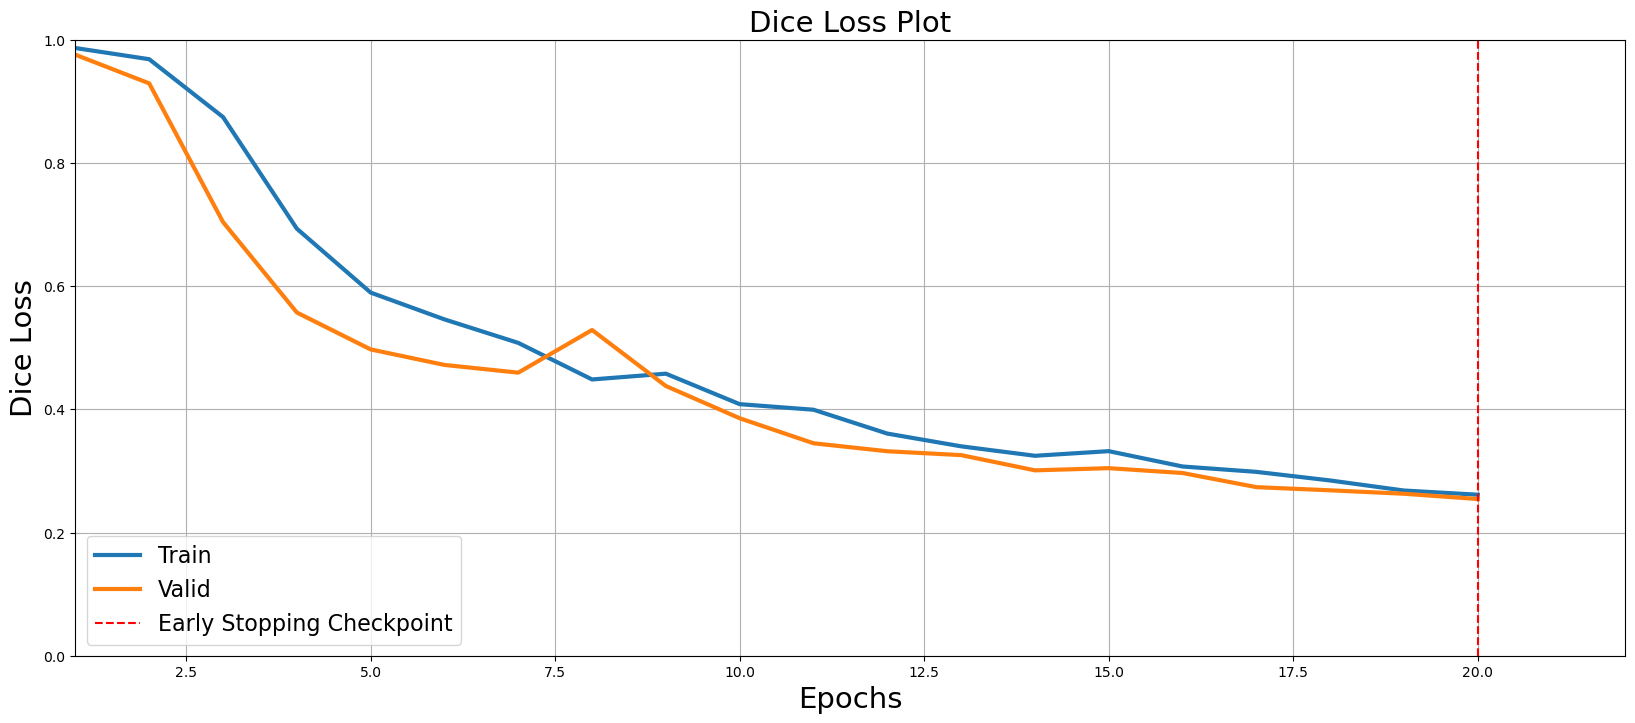


Epoch: 1
Dice loss of 0.983
This is a new best model!
Validation loss decreased (inf --> 0.982966). 

Epoch: 2
Dice loss of 0.977
This is a new best model!
Validation loss decreased (0.982966 --> 0.976919). 

Epoch: 3
Dice loss of 0.944
This is a new best model!
Validation loss decreased (0.976919 --> 0.944229). 

Epoch: 4
Dice loss of 0.656
This is a new best model!
Validation loss decreased (0.944229 --> 0.655977). 

Epoch: 5
Dice loss of 0.789

Epoch: 6
Dice loss of 0.553
This is a new best model!
Validation loss decreased (0.655977 --> 0.553130). 

Epoch: 7
Dice loss of 0.462
This is a new best model!
Validation loss decreased (0.553130 --> 0.461769). 

Epoch: 8
Dice loss of 0.990

Epoch: 9
Dice loss of 0.435
This is a new best model!
Validation loss decreased (0.461769 --> 0.434723). 

Epoch: 10
Dice loss of 0.490

Epoch: 11
Dice loss of 0.398
This is a new best model!
Validation loss decreased (0.434723 --> 0.397923). 

Epoch: 12
Dice loss of 0.367
This is a new best model!
Vali

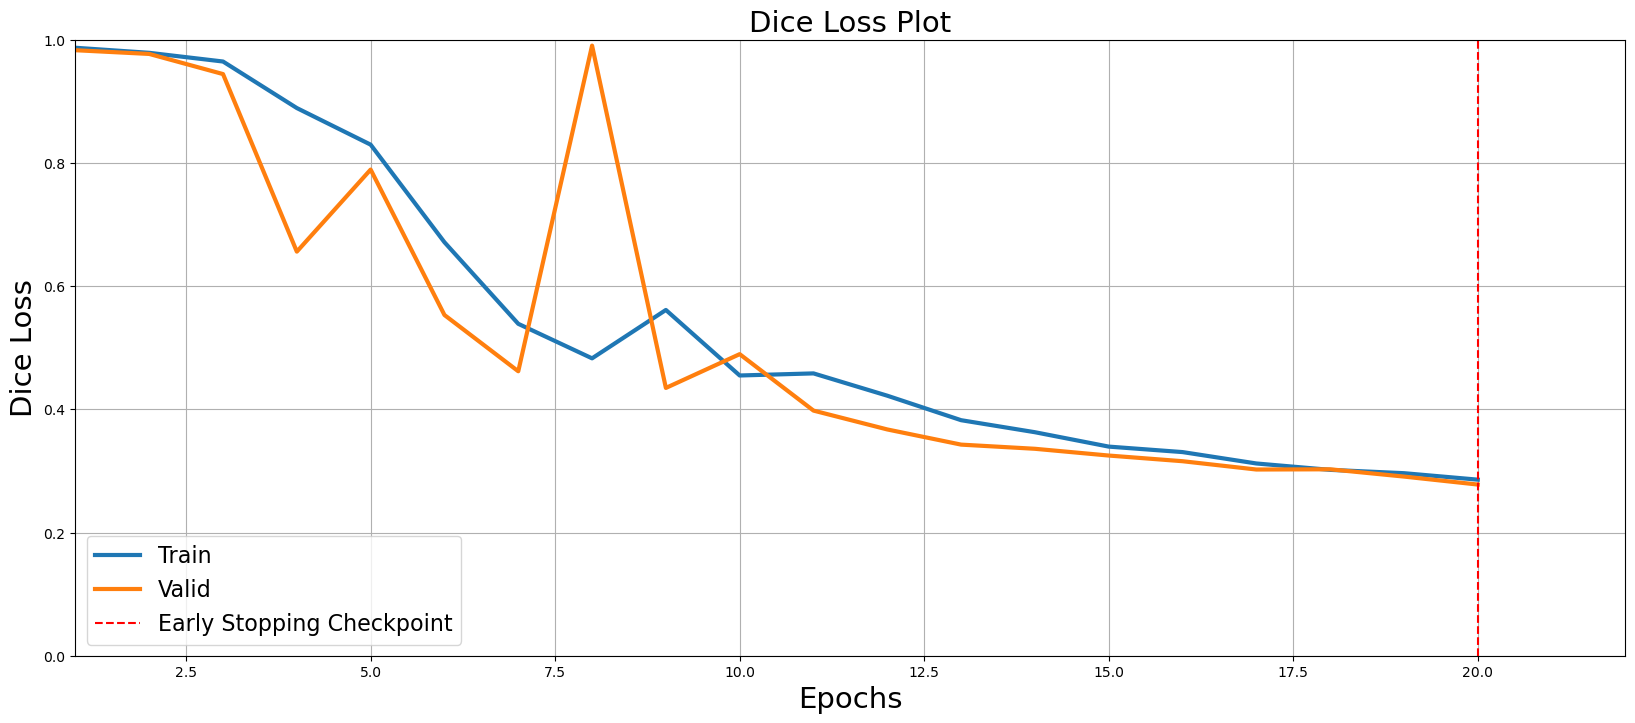


Epoch: 1
Dice loss of 0.983
This is a new best model!
Validation loss decreased (inf --> 0.983137). 

Epoch: 2
Dice loss of 0.972
This is a new best model!
Validation loss decreased (0.983137 --> 0.971825). 

Epoch: 3
Dice loss of 0.933
This is a new best model!
Validation loss decreased (0.971825 --> 0.932736). 

Epoch: 4
Dice loss of 0.689
This is a new best model!
Validation loss decreased (0.932736 --> 0.688876). 

Epoch: 5
Dice loss of 0.597
This is a new best model!
Validation loss decreased (0.688876 --> 0.597352). 

Epoch: 6
Dice loss of 0.539
This is a new best model!
Validation loss decreased (0.597352 --> 0.538502). 

Epoch: 7
Dice loss of 0.436
This is a new best model!
Validation loss decreased (0.538502 --> 0.436081). 

Epoch: 8
Dice loss of 0.465

Epoch: 9
Dice loss of 0.439

Epoch: 10
Dice loss of 0.372
This is a new best model!
Validation loss decreased (0.436081 --> 0.372102). 

Epoch: 11
Dice loss of 0.356
This is a new best model!
Validation loss decreased (0.37210

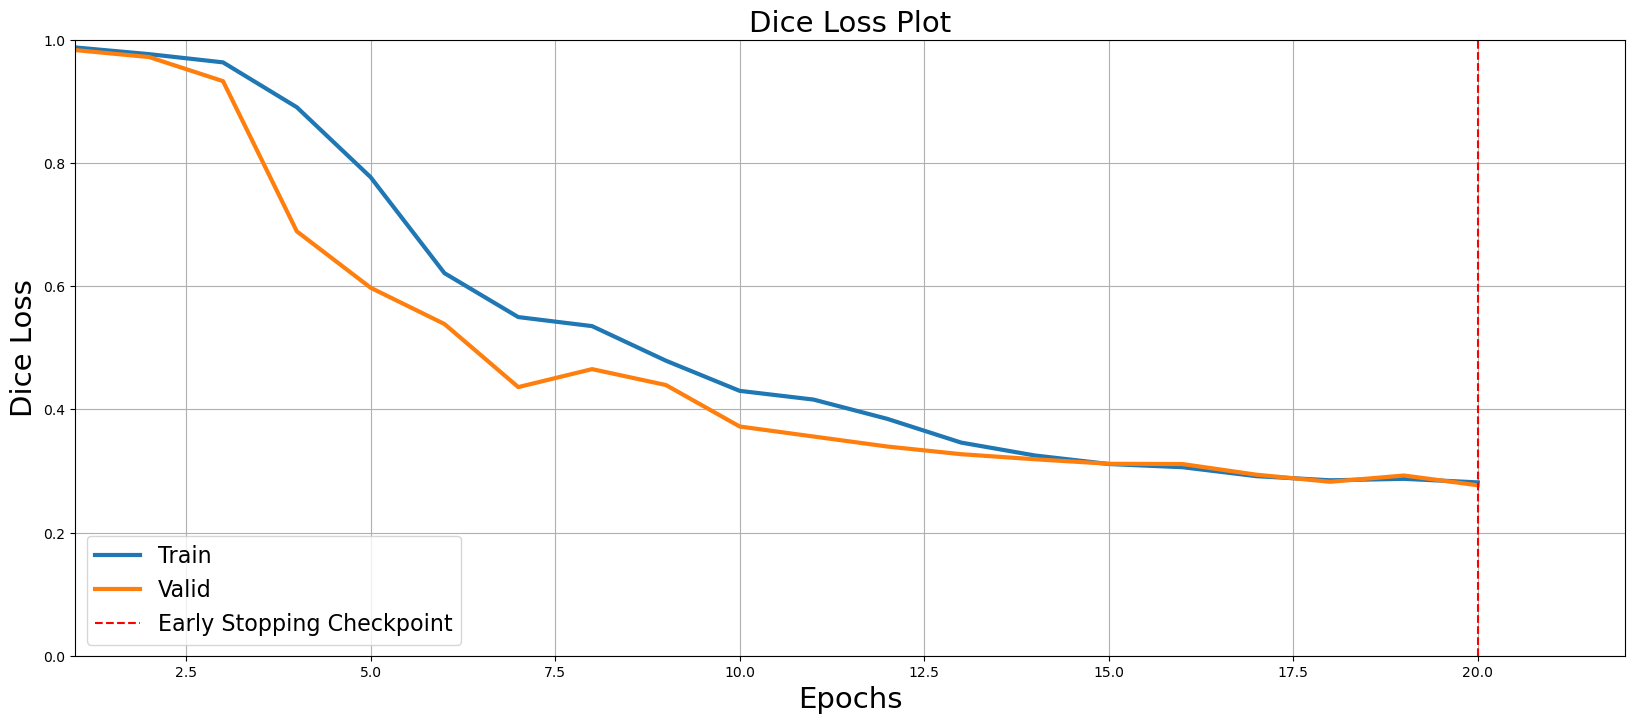

In [144]:
data_perc_to_ensemble = 0.9

for i in range(0, len(ensemble_models)):
    random_subset_dataloader = create_random_subset_dataloader(train_dataloader, data_perc_to_ensemble)
    train_logs_list, valid_logs_list = train(ensemble_models[i], random_subset_dataloader, val_dataloader, epochs=20, verbose=False)
    
    train_logs_df = pd.DataFrame(train_logs_list)
    valid_logs_df = pd.DataFrame(valid_logs_list)

    plot_train_scores(train_logs_df, valid_logs_df, "Dice_loss", "Dice Loss")
    clean_memory()

Next, we write a function that will create the final output of the ensemble. It takes the ensemble models, and a test dataloader, and predicts the test data with each one of the ensemble models. In the end, we calculate the mean of the predictions as the final result.

In [145]:
def ensemble_predict(ensemble_models, test_dataloader):
    [model.eval() for model in ensemble_models]
    
    ensemble_predictions = []
    
    with torch.no_grad():
        for inputs, _ in test_dataloader:
            inputs = inputs.to(DEVICE)
            
            model_predictions = [model(inputs).cpu().numpy() for model in ensemble_models]
            ensemble_predictions.append(np.mean(model_predictions, axis=0)) 
            
    ensemble_predictions = np.concatenate(ensemble_predictions)
    return ensemble_predictions

We will run the ensemble models with the previous function on our test dataset to evaluate the ensemble method. 

In [146]:
ensemble_predictions = ensemble_predict(ensemble_models, test_dataloader)

This time, we are not using the smp library, so we will calculate the dice loss ourselves.

In [147]:
def calculate_ensemble_dice_loss(ensemble_predictions, test_dataloader):
    dice_loss = 0
    for i, (inputs, labels) in enumerate(test_dataloader):
        labels = labels.to(DEVICE)
        pred = torch.from_numpy(ensemble_predictions[i]).to(DEVICE)
        dice = 2 * (pred * labels).sum() / (pred.sum() + labels.sum() + 1e-7)
        dice_loss += 1 - dice
    dice_loss /= len(test_dataloader)
    return dice_loss.item()

In [148]:
unets_ensemble_dice_loss = calculate_ensemble_dice_loss(ensemble_predictions, test_dataloader)
insert_model_test(model_test=ModelTest("U-Nets Ensemble", "5 U-Nets ensemble", unets_ensemble_dice_loss, "An ensemble of 5 basic U-Nets. Each is trained with random {}% of the OCT data.".format(data_perc_to_ensemble*100)))
print("Dice loss for U-Nets ensemble: {}".format(unets_ensemble_dice_loss))

Dice loss for U-Nets ensemble: 0.281690274550229


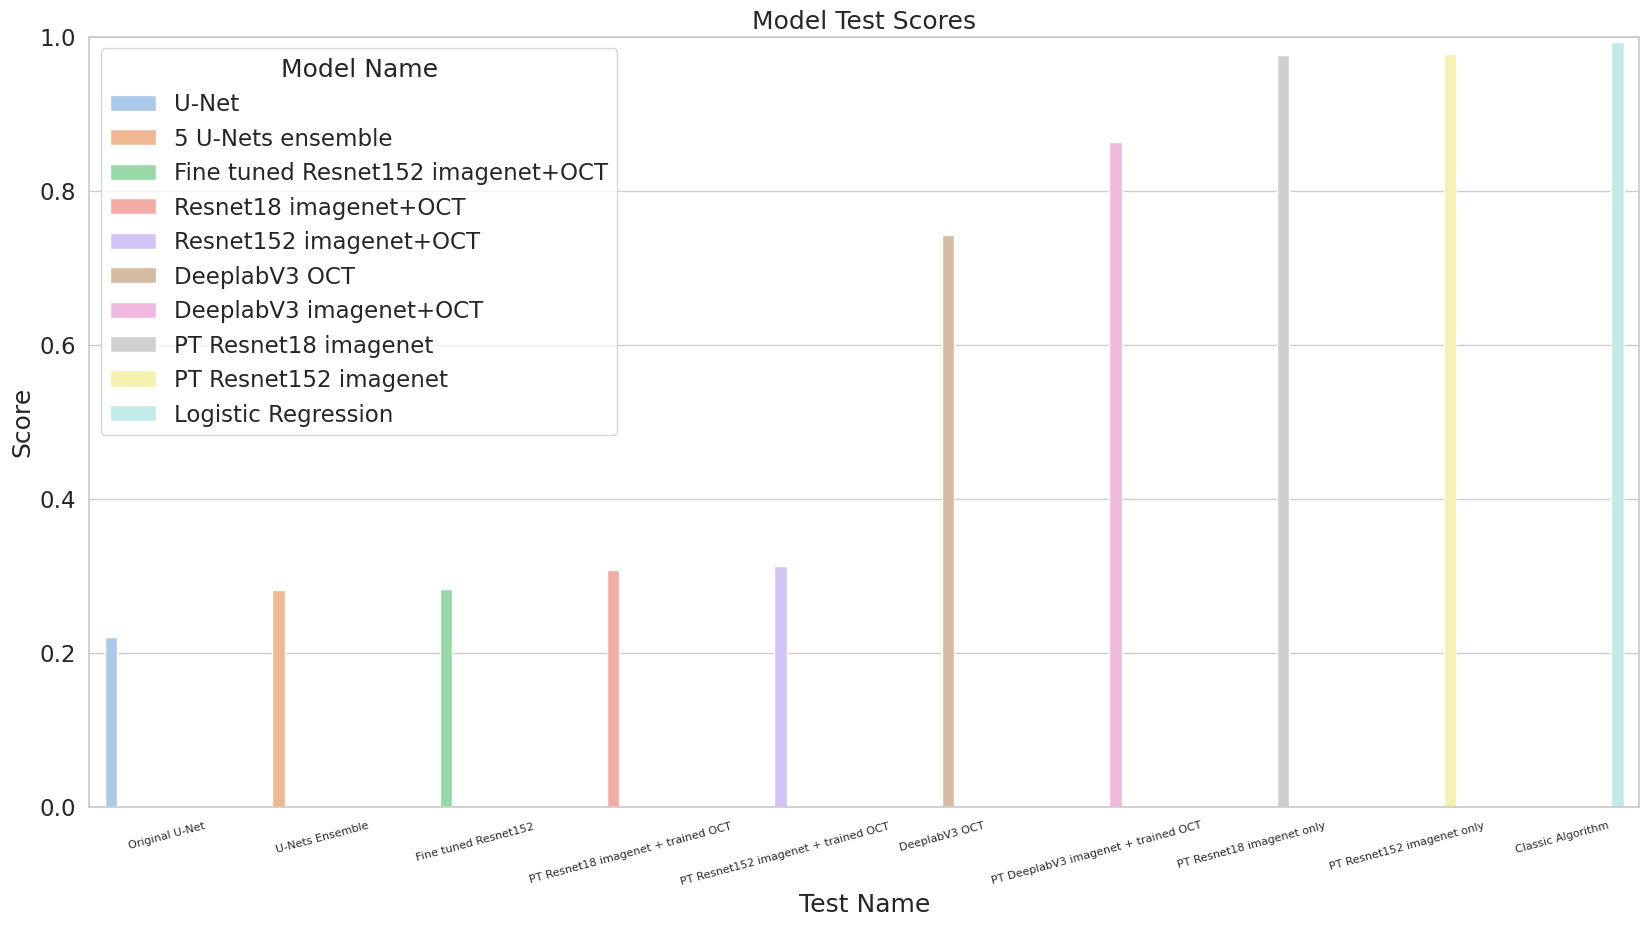

In [149]:
visualize_models_tests_scores()

## 4.8.2. Mixed Models Ensembling

The results are good - but not good enough. Still, the original U-Nets passes the ensemble.  
We still believe that the ensembling method can give us even better results. Now, we will try ensembling with different models. There are some advantages to using different models in the ensembling process. Let's review the key advantages:
1. Different models can be good in different areas, and by ensembling multiple models, their strengths can be combined to achieve better overall performance.
1. By using different types of models, the ensemble can capture a wider range of patterns and features in the data, leading to more robust predictions.
1. Using different models can reduce overfitting, as each model may have different architectures and learn different features. So, the errors made by one model may be compensated by the other models.  

We will create 2 new U-Nets, and 2 pre-trained U-Nets with resnet18 as their pre-trained encoder. We will freeze the encoder for those 2 models, and add dropouts layers, like we did before.

In [150]:
clean_memory()
num_unet_ensemble_models = 2
num_resnet_ensemble_models = 2
mixed_ensemble_models = []

for i in range(0, num_unet_ensemble_models):
    unet = UNet(in_channels=3, out_channels=1)
    unet = unet.double()
    unet = unet.to(DEVICE)
    mixed_ensemble_models.append(unet)

for i in range(0, num_resnet_ensemble_models):
    pt_resnet18_model = smp.Unet(
    encoder_name="resnet18",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=1,                      
    activation='sigmoid',
    )
    pt_resnet18_model = pt_resnet18_model.to(DEVICE)
    freeze_encoder(pt_resnet18_model)
    
    for name, module in pt_resnet18_model.named_modules():
        if "conv" in name and "decoder" in name and "dropout" not in name:
            module.add_module("dropout", nn.Dropout2d(p=0.1))
    
    pt_resnet18_model = pt_resnet18_model.double()
    mixed_ensemble_models.append(pt_resnet18_model)

We will now train the models the same way as before - on a random subset of the origianl train data.


Epoch: 1
Dice loss of 0.982
This is a new best model!
Validation loss decreased (inf --> 0.981600). 

Epoch: 2
Dice loss of 0.981
This is a new best model!
Validation loss decreased (0.981600 --> 0.981090). 

Epoch: 3
Dice loss of 1.000

Epoch: 4
Dice loss of 1.000

Epoch: 5
Dice loss of 1.000

Epoch: 6
Dice loss of 1.000

Epoch: 7
Dice loss of 1.000

Epoch: 8
Dice loss of 1.000

Epoch: 9
Dice loss of 1.000

Epoch: 10
Dice loss of 1.000

Epoch: 11
Dice loss of 1.000

Epoch: 12
Dice loss of 1.000
Early stopping


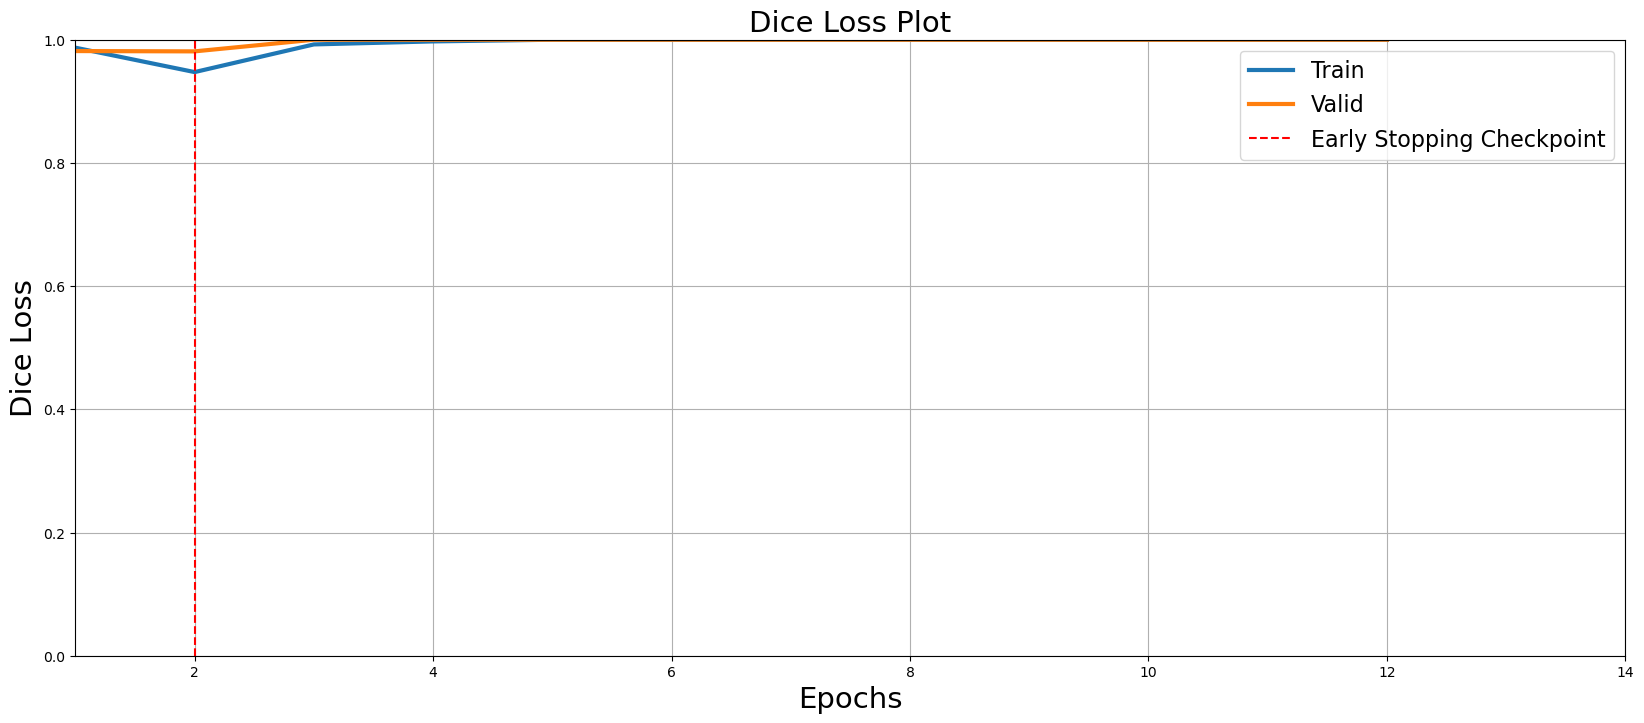


Epoch: 1
Dice loss of 0.984
This is a new best model!
Validation loss decreased (inf --> 0.984279). 

Epoch: 2
Dice loss of 0.935
This is a new best model!
Validation loss decreased (0.984279 --> 0.934601). 

Epoch: 3
Dice loss of 0.999

Epoch: 4
Dice loss of 0.997

Epoch: 5
Dice loss of 1.000

Epoch: 6
Dice loss of 1.000

Epoch: 7
Dice loss of 0.968

Epoch: 8
Dice loss of 0.664
This is a new best model!
Validation loss decreased (0.934601 --> 0.664046). 

Epoch: 9
Dice loss of 0.585
This is a new best model!
Validation loss decreased (0.664046 --> 0.585352). 

Epoch: 10
Dice loss of 0.671

Epoch: 11
Dice loss of 0.615

Epoch: 12
Dice loss of 0.503
This is a new best model!
Validation loss decreased (0.585352 --> 0.502967). 

Epoch: 13
Dice loss of 0.457
This is a new best model!
Validation loss decreased (0.502967 --> 0.456638). 

Epoch: 14
Dice loss of 0.404
This is a new best model!
Validation loss decreased (0.456638 --> 0.403724). 

Epoch: 15
Dice loss of 0.429

Epoch: 16
Dice lo

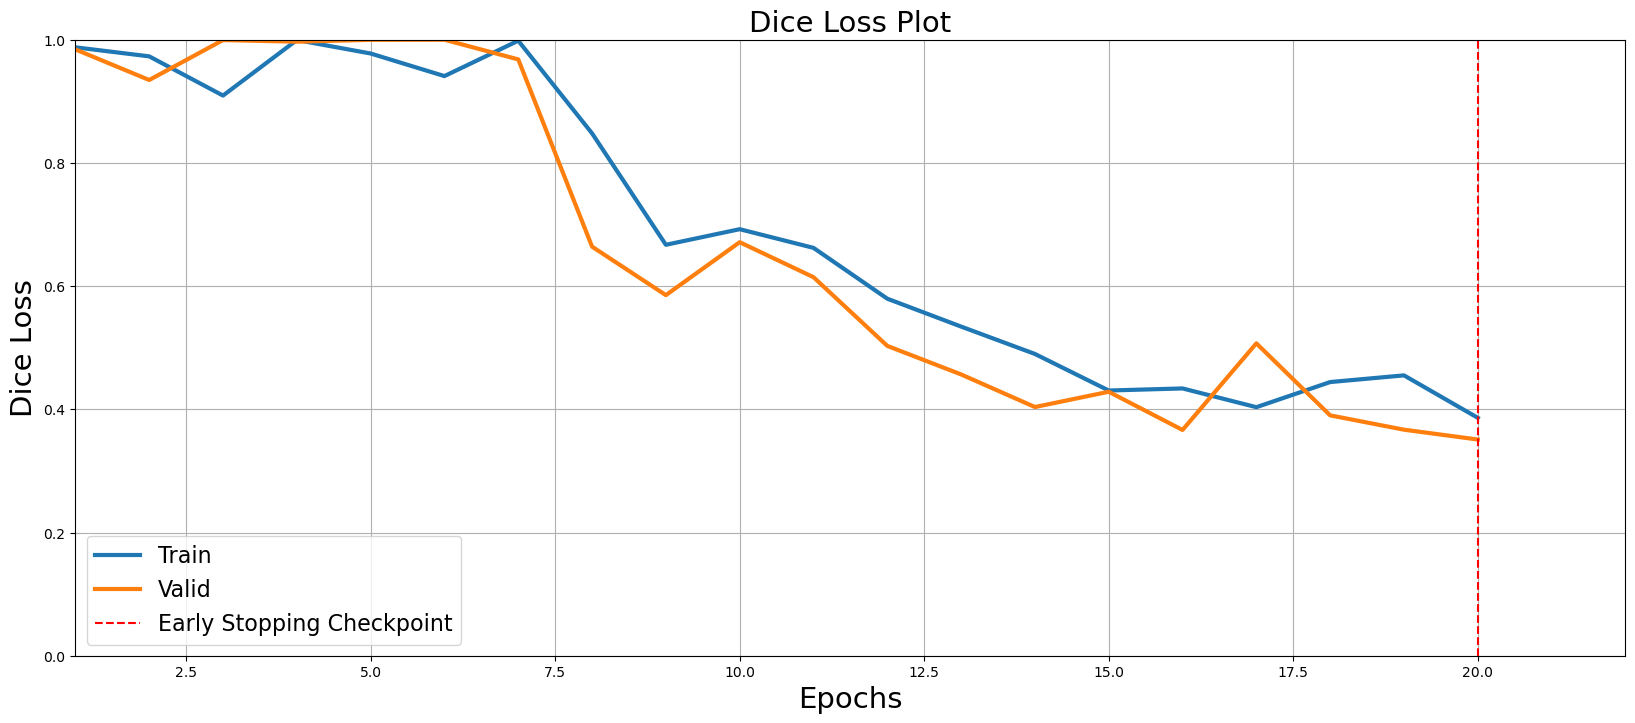


Epoch: 1
Dice loss of 0.987
This is a new best model!
Validation loss decreased (inf --> 0.987425). 

Epoch: 2
Dice loss of 0.985
This is a new best model!
Validation loss decreased (0.987425 --> 0.984999). 

Epoch: 3
Dice loss of 0.978
This is a new best model!
Validation loss decreased (0.984999 --> 0.978016). 

Epoch: 4
Dice loss of 0.974
This is a new best model!
Validation loss decreased (0.978016 --> 0.973553). 

Epoch: 5
Dice loss of 0.962
This is a new best model!
Validation loss decreased (0.973553 --> 0.961653). 

Epoch: 6
Dice loss of 0.954
This is a new best model!
Validation loss decreased (0.961653 --> 0.954020). 

Epoch: 7
Dice loss of 0.948
This is a new best model!
Validation loss decreased (0.954020 --> 0.947905). 

Epoch: 8
Dice loss of 0.934
This is a new best model!
Validation loss decreased (0.947905 --> 0.934316). 

Epoch: 9
Dice loss of 0.915
This is a new best model!
Validation loss decreased (0.934316 --> 0.914705). 

Epoch: 10
Dice loss of 0.887
This is a ne

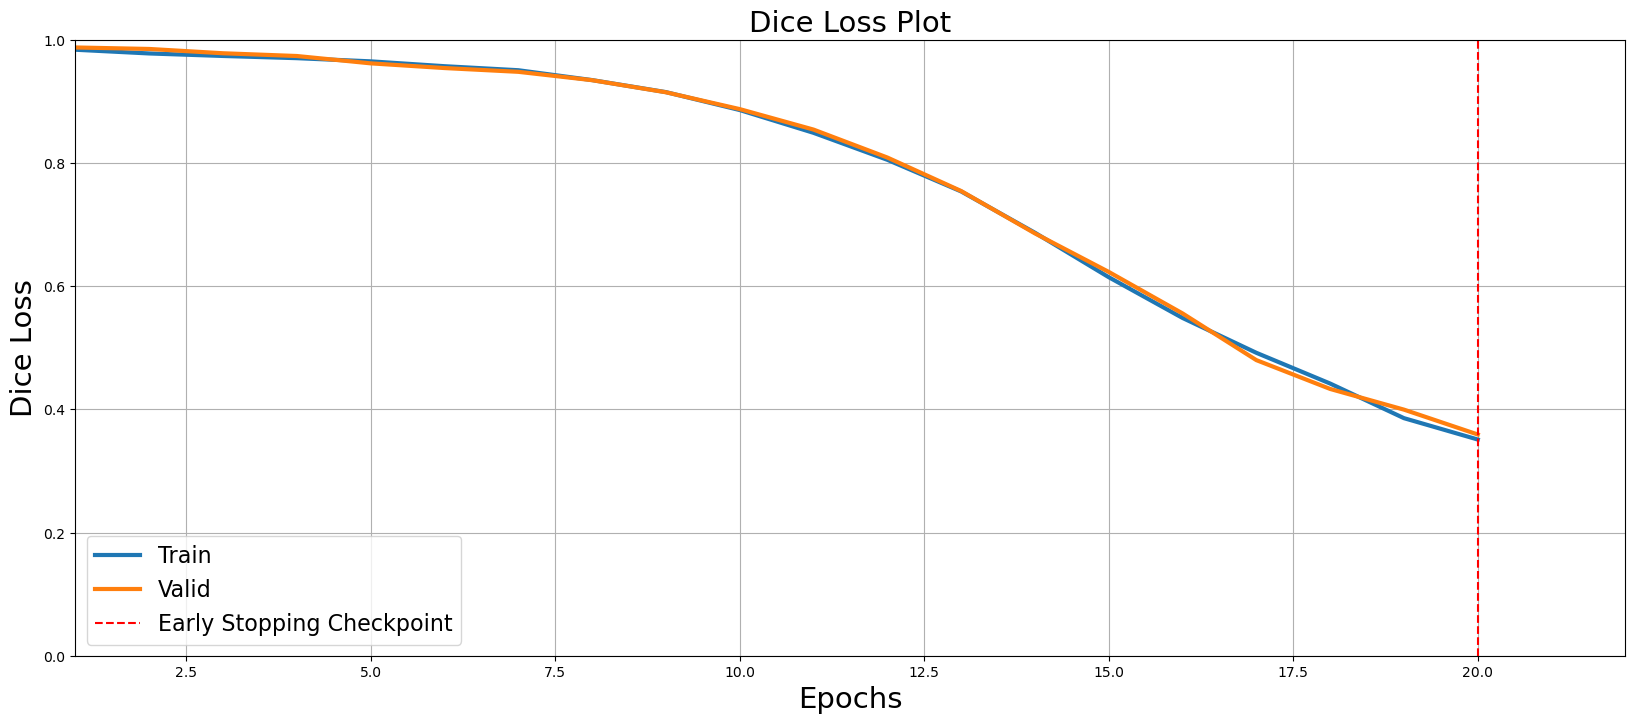


Epoch: 1
Dice loss of 0.984
This is a new best model!
Validation loss decreased (inf --> 0.983599). 

Epoch: 2
Dice loss of 0.983
This is a new best model!
Validation loss decreased (0.983599 --> 0.982959). 

Epoch: 3
Dice loss of 0.973
This is a new best model!
Validation loss decreased (0.982959 --> 0.972597). 

Epoch: 4
Dice loss of 0.953
This is a new best model!
Validation loss decreased (0.972597 --> 0.953196). 

Epoch: 5
Dice loss of 0.949
This is a new best model!
Validation loss decreased (0.953196 --> 0.948758). 

Epoch: 6
Dice loss of 0.915
This is a new best model!
Validation loss decreased (0.948758 --> 0.915269). 

Epoch: 7
Dice loss of 0.890
This is a new best model!
Validation loss decreased (0.915269 --> 0.889852). 

Epoch: 8
Dice loss of 0.860
This is a new best model!
Validation loss decreased (0.889852 --> 0.859923). 

Epoch: 9
Dice loss of 0.813
This is a new best model!
Validation loss decreased (0.859923 --> 0.813035). 

Epoch: 10
Dice loss of 0.759
This is a ne

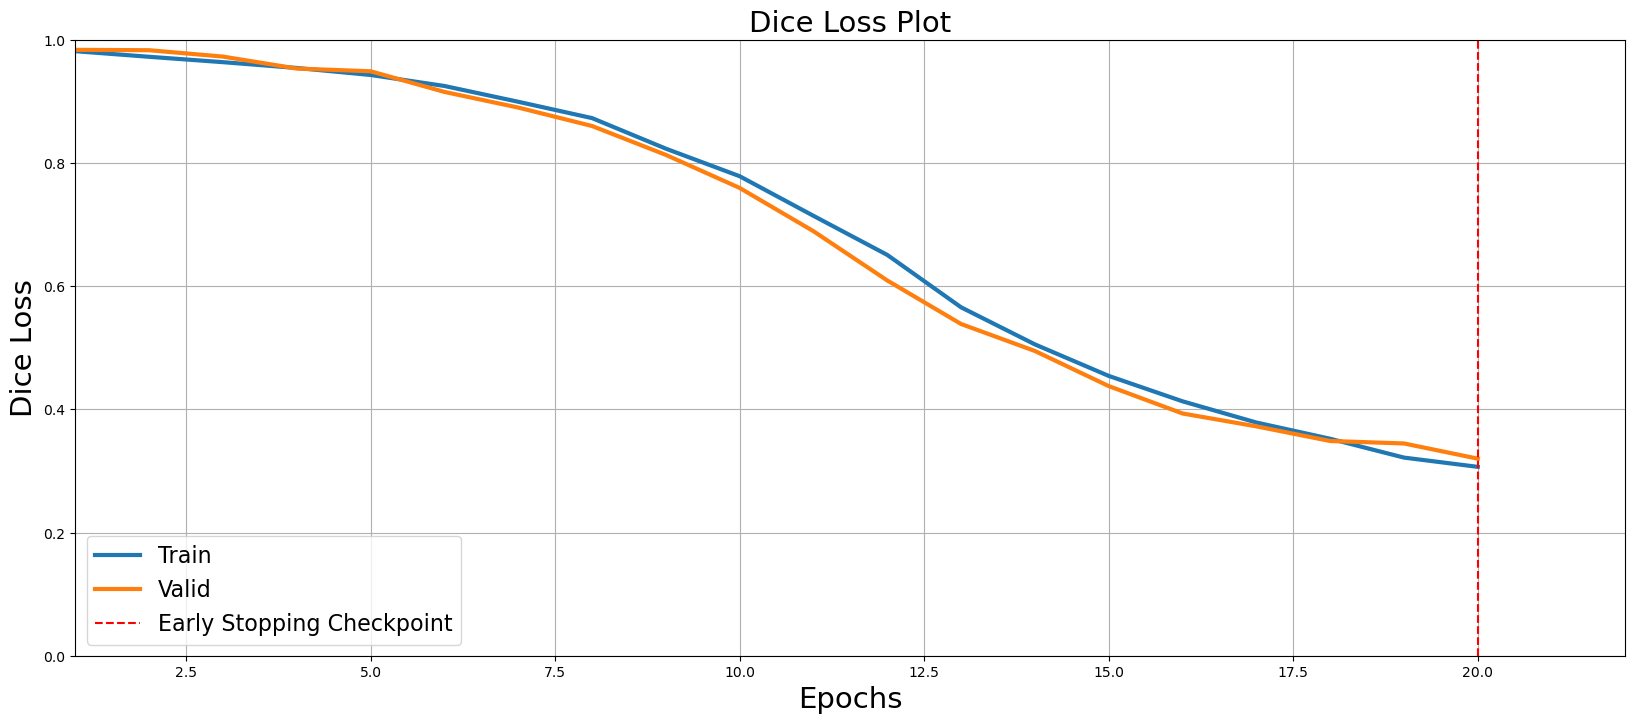

In [151]:
data_perc_to_ensemble = 0.85

for i in range(0, len(mixed_ensemble_models)):
    random_subset_dataloader = create_random_subset_dataloader(train_dataloader, data_perc_to_ensemble)
    train_logs_list, valid_logs_list = train(mixed_ensemble_models[i], random_subset_dataloader, val_dataloader, epochs=20, verbose=False)
    
    train_logs_df = pd.DataFrame(train_logs_list)
    valid_logs_df = pd.DataFrame(valid_logs_list)

    plot_train_scores(train_logs_df, valid_logs_df, "Dice_loss", "Dice Loss")

Let's evaluate our new ensemble:

In [152]:
ensemble_predictions = ensemble_predict(mixed_ensemble_models, test_dataloader)

In [153]:
mixed_ensemble_dice_loss = calculate_ensemble_dice_loss(ensemble_predictions, test_dataloader)
insert_model_test(model_test=ModelTest("Mixed Ensemble", "Mixed ensemble - 2 U-Nets and 2 Resnet18", mixed_ensemble_dice_loss, "A mixed ensemble - 2 basic U-Nets, 2 resnet18. Each is trained with random {}% of the OCT data.".format(data_perc_to_ensemble*100)))
print("Dice loss for the mixed ensemble: {:.3f}".format(mixed_ensemble_dice_loss))

Dice loss for the mixed ensemble: 0.314


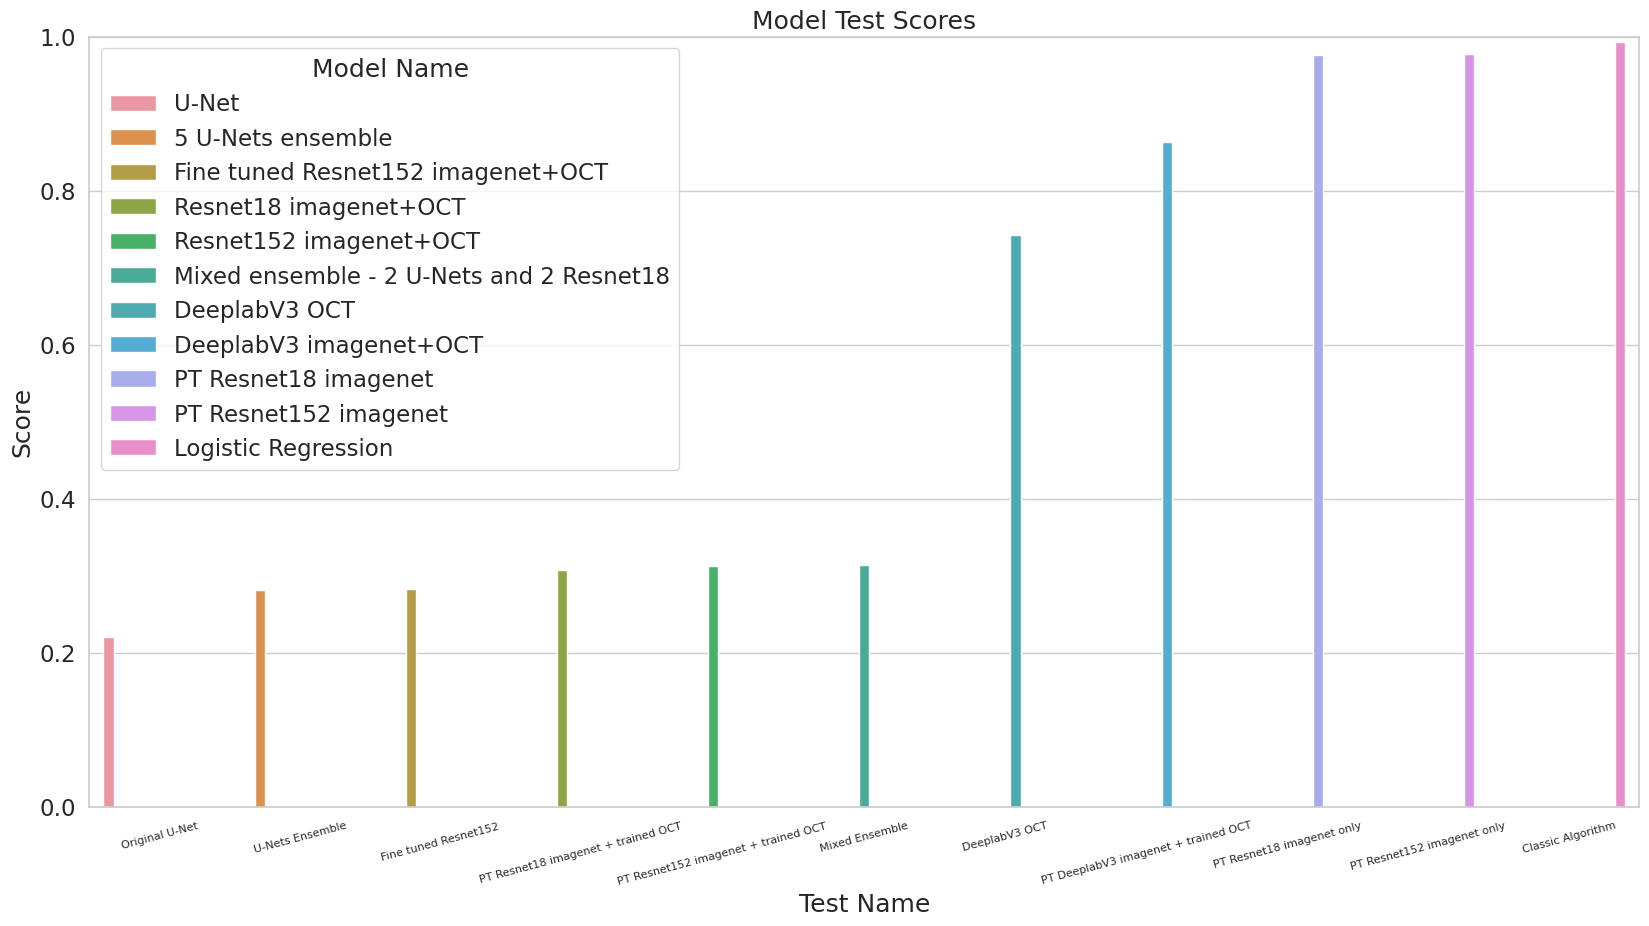

In [154]:
visualize_models_tests_scores()

# 5. Conclusion

## 5.1. Work Conclusion

In this notebook, we presented the OCT scans fluid segmentation task, talked about its importance in the medical world, and explored the data - OCT scans of DME patients, and manual fluid labeling done by medical professionals. Afterward, we built classic model and then U-Net model, which gave us really good results (0.220 Dice loss on the test dataset). Later, we continued to pre-trained advanced models: we trained U-Nets with pre-trained encoders such as Resnet18 and his bigger brother Resnet152 and trained a DeepLabV3 model. We experimented with fine-tuning pre-trained models, which achieved good results (0.283 Dice loss on the test dataset, for a fine-tuned U-Net with a pre-trained Resnet152 encoder). Later on, we worked on the ensemble method. Our U-Nets ensembling achieved good results (0.281 Dice loss on the test dataset).
In the end, the mixed ensembling - an ensemble of 2 U-Nets, and 2 U-Nets with fine-tuned pre-trained Resnet18 encoder - gave us 0.314 Dice loss 


We tried to be creative, and try the methods that we thought will give the best results. As we can see,our more advanced methods were not able to beat our first solution, but experimenting and thinking of new ideas in hope of achieving a better results is always good.
Even though we reached good segmentation results - there is still much to improve. The research is still ongoing, and many new articles and ideas come up with another great improvement.

References

[1] Ahmed Z, Panhwar SQ, Baqai A, Umrani FA, Ahmed M, Khan A. Deep learning based automated detection of intraretinal cystoid fluid. Int J Imaging Syst Technol. 2021;1-16.  

[2] Zeeshan Ahmed, Munawar Ahmed, Attiya Baqai, & Fahim Aziz Umrani. (2022). Intraretinal Cystoid Fluid [Data set]. Kaggle.  

[3] Ronneberger, O.; Fischer, P.; Brox, T. U-Net: Convolutional networks for biomedical image segmentation. In Proceedings of the International Conference on Medical Image Computing and Computer-Assisted Intervention (MICCAI 2015), Munich, Germany, 5–9 October 2015; pp. 234–241.

[4] Lin, M.; Bao, G.; Sang, X.; Wu, Y. Recent Advanced Deep Learning Architectures for Retinal Fluid Segmentation on Optical Coherence Tomography Images. Sensors 2022, 22, 3055.